In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import sys
import time
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from keras_tuner import BayesianOptimization
import keras


import AA_Import_LCP_Functions as chase_lcc
import AB_Import_Prep_XGB_Tune_TS as chase_xgb_tune
import AC_Import_AE_Tune as chase_ae_tune

2024-02-28 12:20:57.987461: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-28 12:20:57.987506: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-28 12:20:57.987541: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-28 12:20:57.995969: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-28 12:20:58.958533: W tensorflow/compiler/tf2t

# Read in prmtop and tractory data and execute internal distance measurements
-----
### CPPTRAJ files saved in cpptraj_folder
### LCCDATA files saved in lccdata_folder

In [2]:
# Configuration
prmtop_1 = 'myc_091-160_stripped.prmtop'
nc_1 = 'aMD_091-160_no1-4_stripped.nc'
prmtop_2 = 'myc_091-160_D132-H_stripped.prmtop'
nc_2 = 'aMD_091-160_D132-H_no1-4_stripped.nc'
protein_length = 70
window_range = range(2, 52)

# Setup folders and execute scripts
cpptraj_folder, lccdata_folder, should_proceed = chase_lcc.setup_folders()
if should_proceed:
    chase_lcc.execute_cpptraj_scripts(prmtop_1, nc_1, prmtop_2, nc_2, protein_length, window_range, cpptraj_folder, lccdata_folder)
else:
    print("No need to regenerate cpptraj scripts or lccdata files.")

cpptraj files and lccdata_files already generated.
No need to regenerate cpptraj scripts or lccdata files.


In [3]:
# Create LCCDATA files
chase_lcc.execute_cpptraj_commands(cpptraj_folder, window_range)

cpptraj files and lccdata_files already generated.


# Load LCCDATA and attach to variables wt_dict[window] and D132H_dict[window]

In [4]:
lccdata_folder = 'lccdata_files'

# Import LCC data files for wild type protein and mutant protein
wt_dict = chase_lcc.import_lcc_data(lccdata_folder, 'w')
D132H_dict = chase_lcc.import_lcc_data(lccdata_folder, 'm')

# Create Local Compaction Plots

In [5]:
save_folder = 'Local_Compaction_Plot_Figures'
if not (os.path.isdir(save_folder) and len(os.listdir(save_folder)) == 50):
    for window in window_range:
        chase_lcc.LCC_plot_individual(window, wt_dict[window], D132H_dict[window], save_folder)
else:
    print("Local compaction plots already generated and saved in 'Local_Compaction_Plot_Figures'")

Local compaction plots already generated and saved in 'Local_Compaction_Plot_Figures'


# Feature Engineering:

#### XGBoost Hyperparameter Evaluation
- Pre-prepares data
- Runs XGBoost on each window size with default hyperparameters
- Performs XGBoost hyperparameter tuning
- Generates figures to compare the performance of hyperparameters

In [6]:
trainer = chase_xgb_tune.XGBoostTrainer(
    wt_dict=wt_dict,
    D132H_dict=D132H_dict,
    window_sizes=range(2, 52),
    default_hyperparameters={'use_label_encoder': False, 'eval_metric': 'logloss'},
    eta_values=[0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8],
    max_depth_values=[6, 9, 12, 15, 18, 21, 24],
    subsample_values=[0.6, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1]
)

In [7]:
# This cell takes ~39 minutes to tune and run if the trial number does not exist
try:
    trainer.load_tuning_results(1)  # Loads trial information if trial # exists
except FileNotFoundError as e:
    print(e)
    print("Running new tuning session instead.")
    trainer.tune_hyperparameters_and_save()

# Evaluate default hyperparameters after either loading or tuning
trainer.evaluate_default_hyperparameters()

Tuning results loaded from XGB_Tuning/XGB_Tuning_Trial_1/tuning_results.json


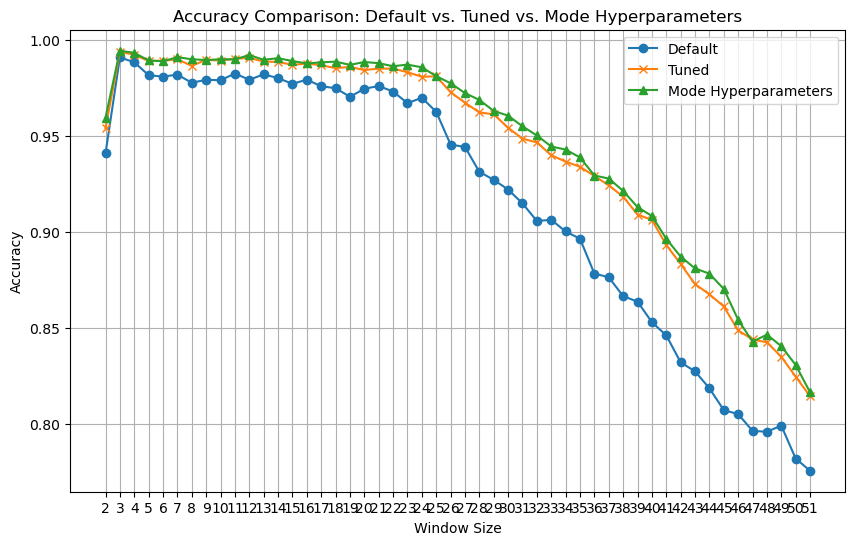

Average accuracy with default hyperparameters: 0.9167
Average accuracy with tuned hyperparameters: 0.9430
Average accuracy with mode hyperparameters: 0.9463


In [8]:
# Plot best hyperparameter values for each window size
trainer.plot_specific_hyperparameter_values(trainer.best_eta_values, 'Optimal Eta Values by Window Size', 'Eta', trainer.eta_values)
trainer.plot_specific_hyperparameter_values(trainer.best_max_depth_values, 'Optimal Max Depth Values by Window Size', 'Max Depth', trainer.max_depth_values)
trainer.plot_specific_hyperparameter_values(trainer.best_subsample_values, 'Optimal Subsample Values by Window Size', 'Subsample', trainer.subsample_values)

# Calculate accuracies using mode hyperparameters
mode_hyperparameter_accuracies = trainer.calculate_mode_hyperparameter_accuracies()

# Plot accuracy comparison including mode hyperparameters
trainer.plot_hyperparameter_values(trainer.window_sizes, trainer.default_accuracy_values, trainer.best_accuracy_values, mode_hyperparameter_accuracies, 'Accuracy Comparison: Default vs. Tuned vs. Mode Hyperparameters')

# Calculate and display average accuracies
average_default_accuracy = np.mean(list(trainer.default_accuracy_values.values()))
average_tuned_accuracy = np.mean(list(trainer.best_accuracy_values.values()))
average_common_hyperparameter_accuracy = sum(mode_hyperparameter_accuracies.values()) / len(mode_hyperparameter_accuracies)
print(f"Average accuracy with default hyperparameters: {average_default_accuracy:.4f}")
print(f"Average accuracy with tuned hyperparameters: {average_tuned_accuracy:.4f}")
print(f"Average accuracy with mode hyperparameters: {average_common_hyperparameter_accuracy:.4f}")

### Extracting Feature Importances

In [9]:
# Save feature importance using common best hyperparameters
trainer.save_feature_importance_and_plot()

Position importance already determined


### Position importance for each window size

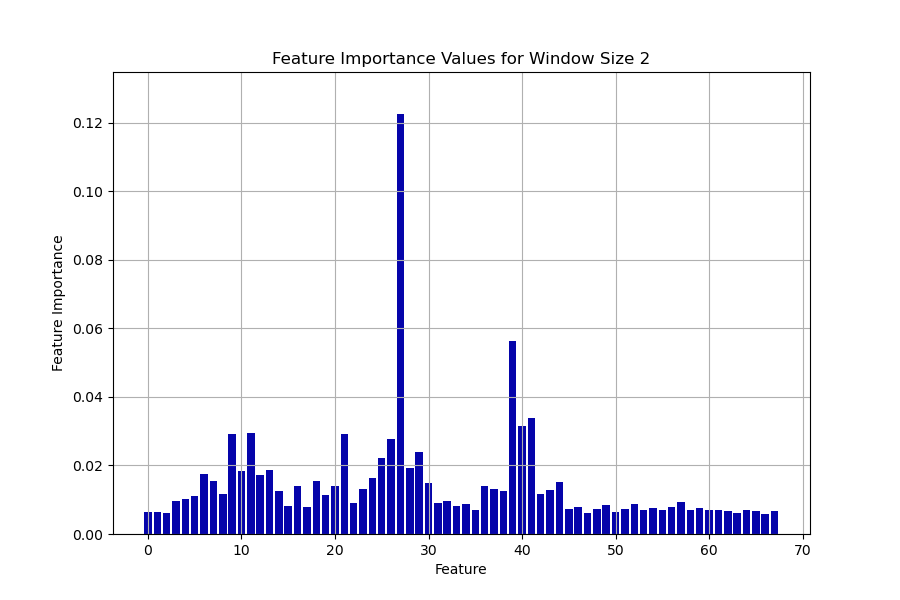

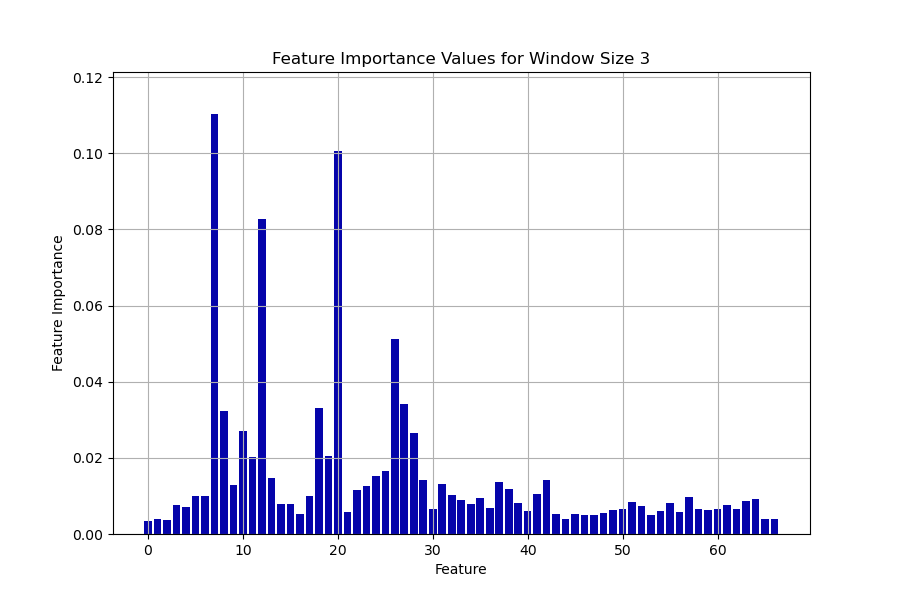

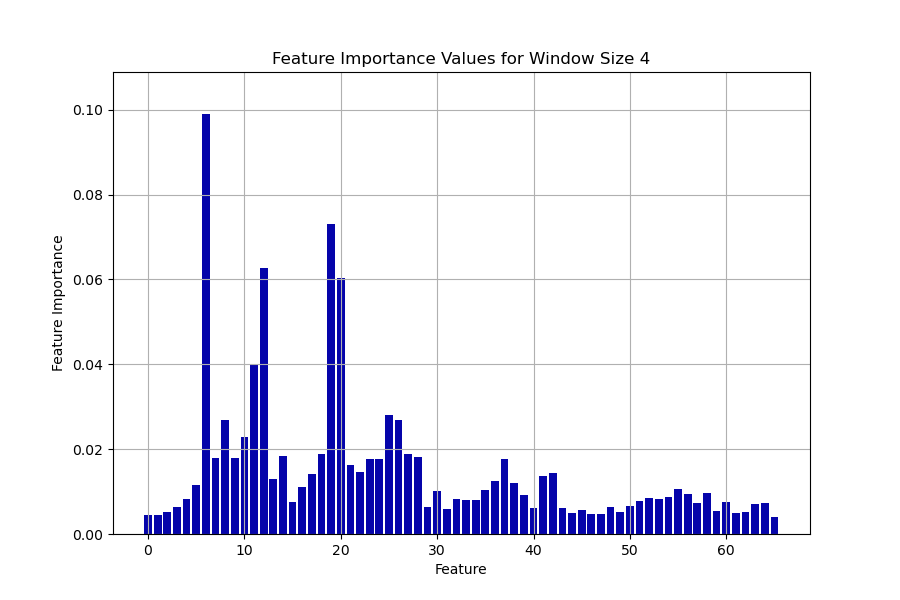

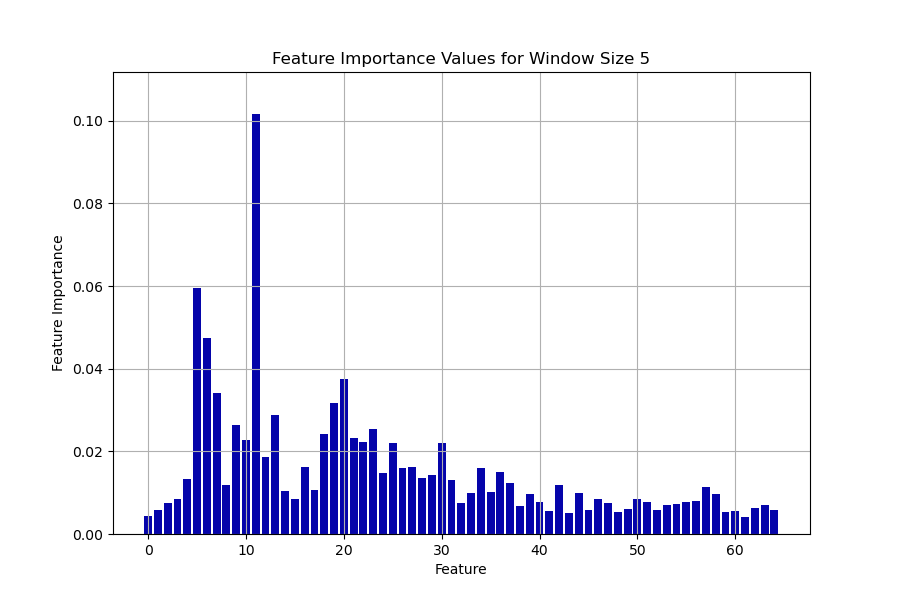

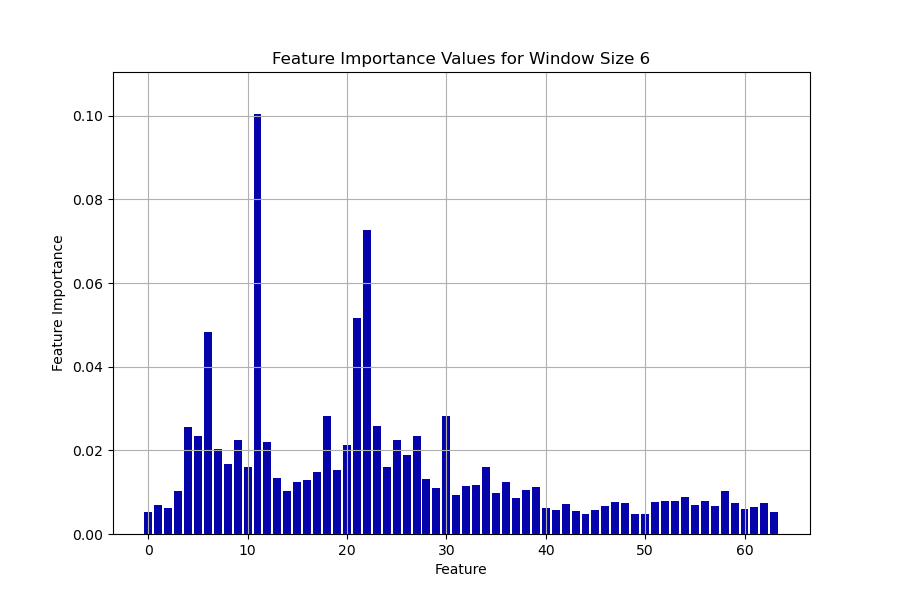

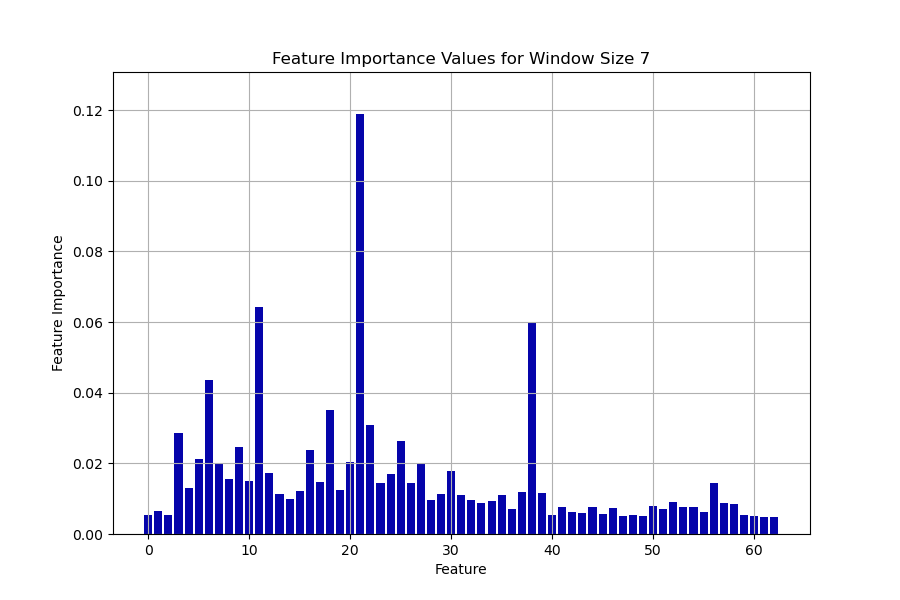

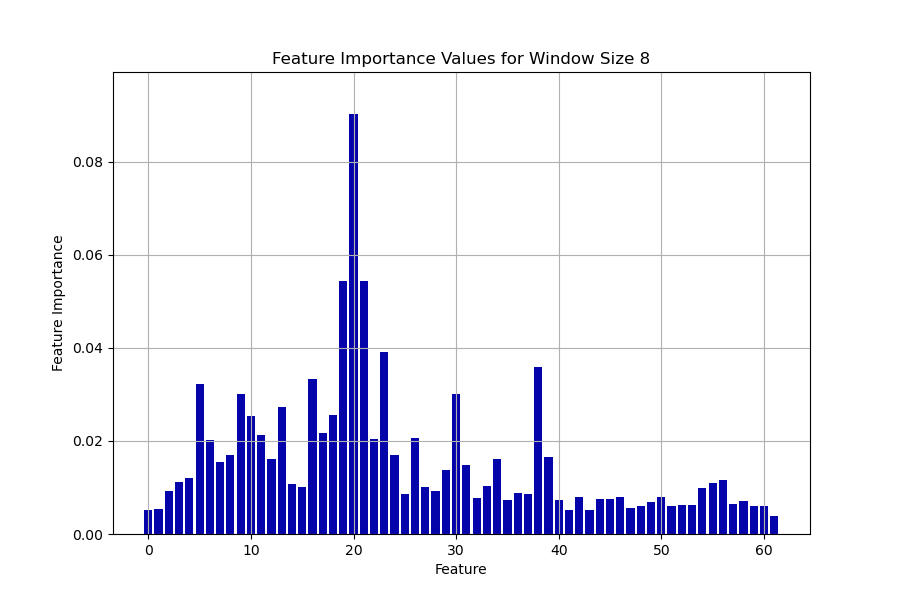

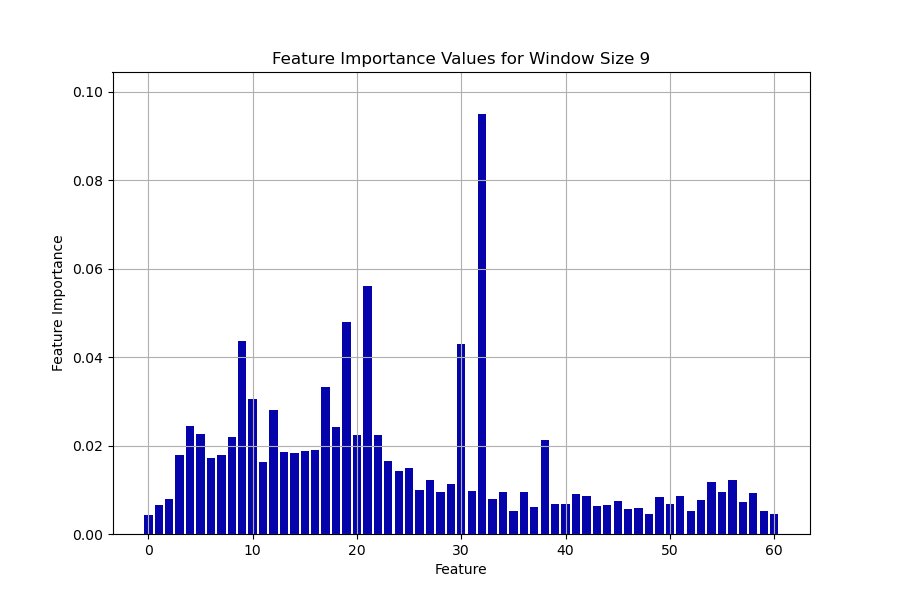

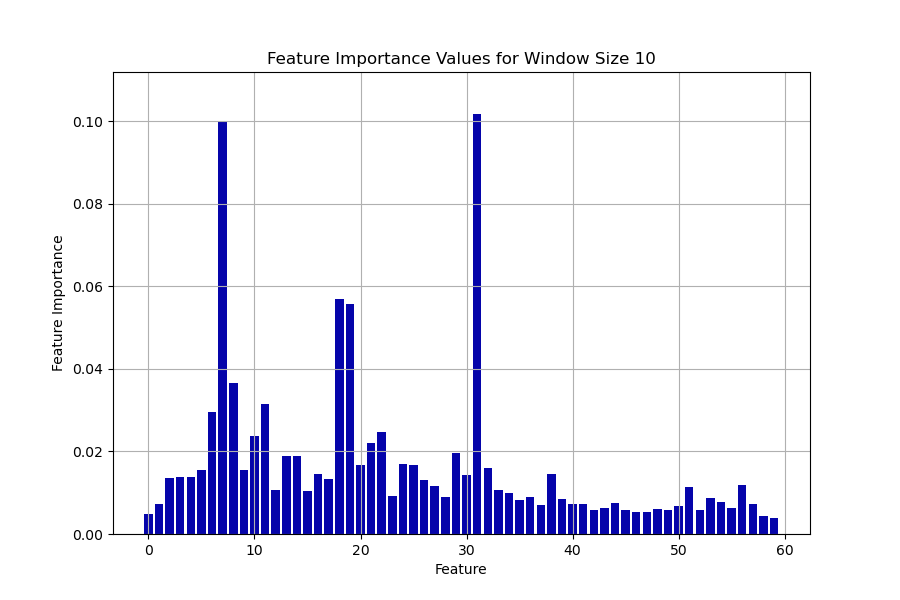

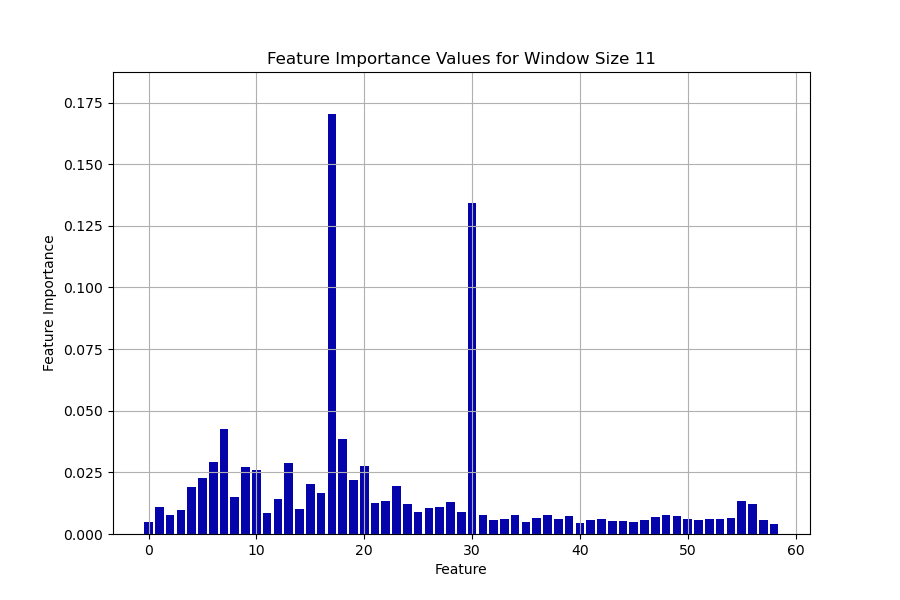

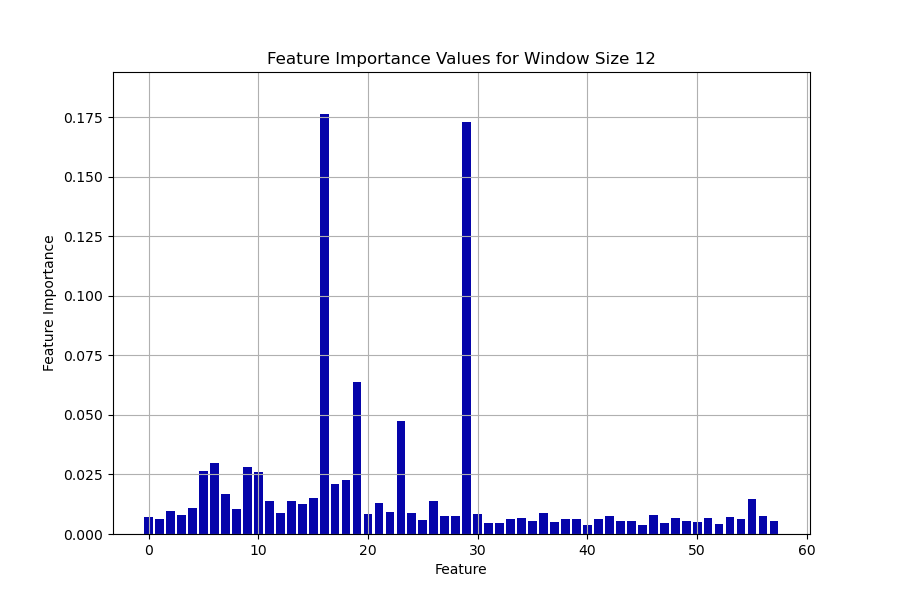

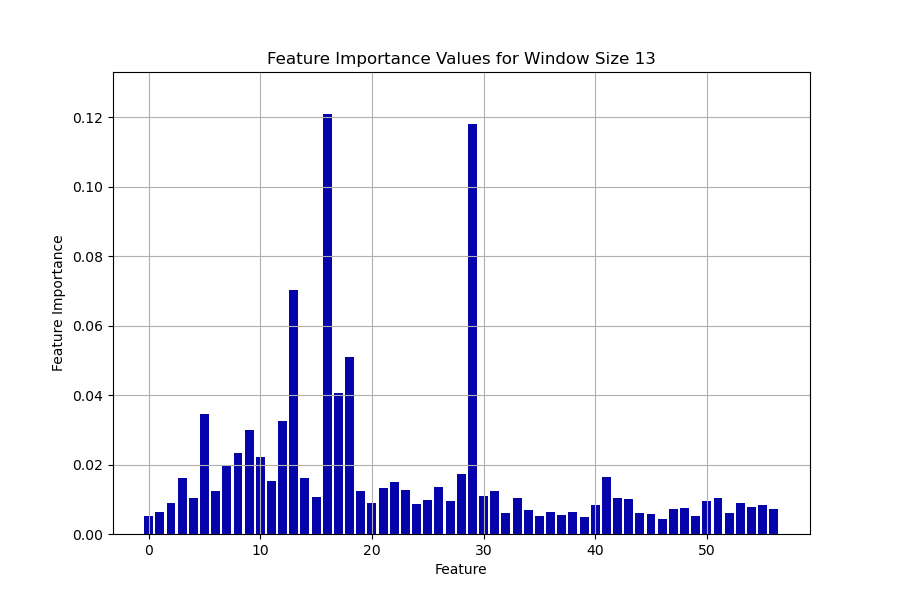

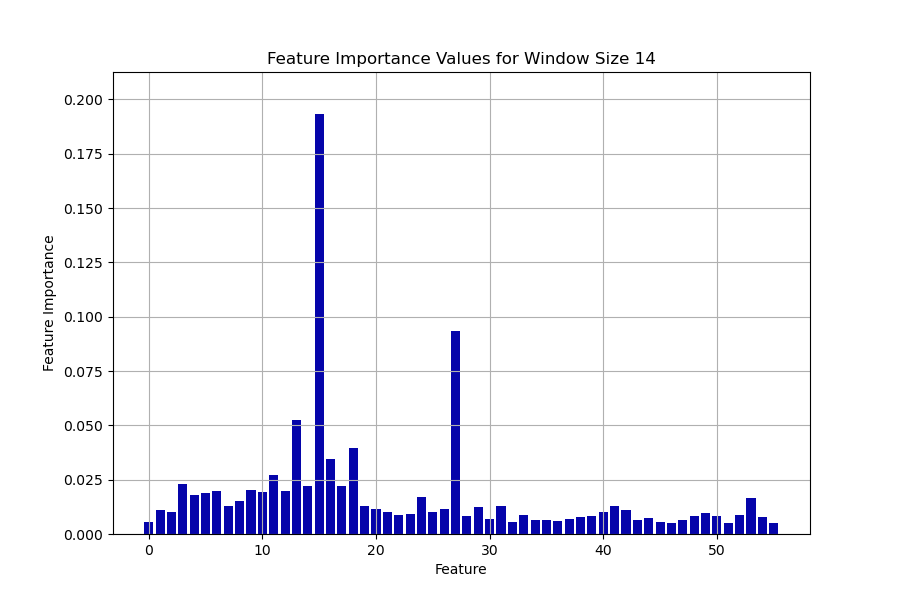

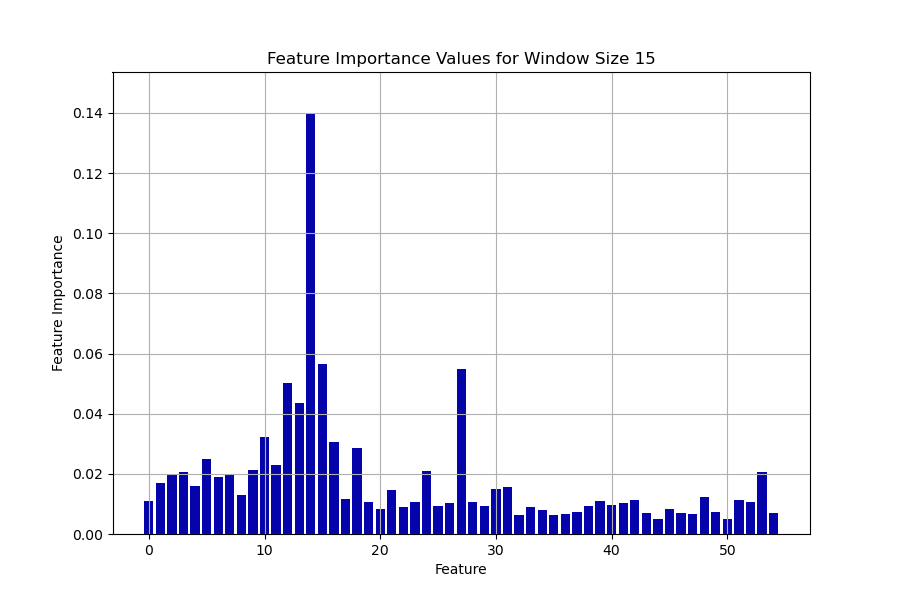

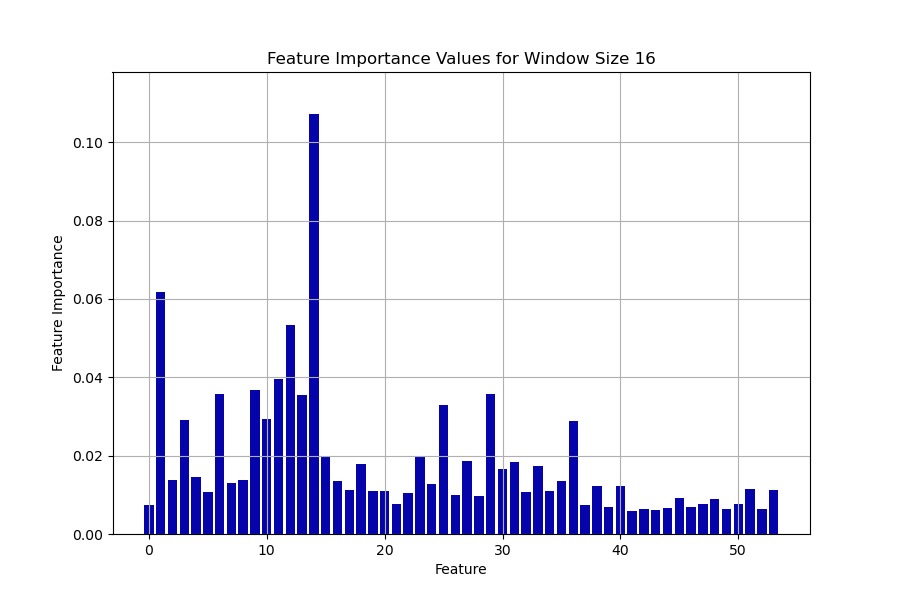

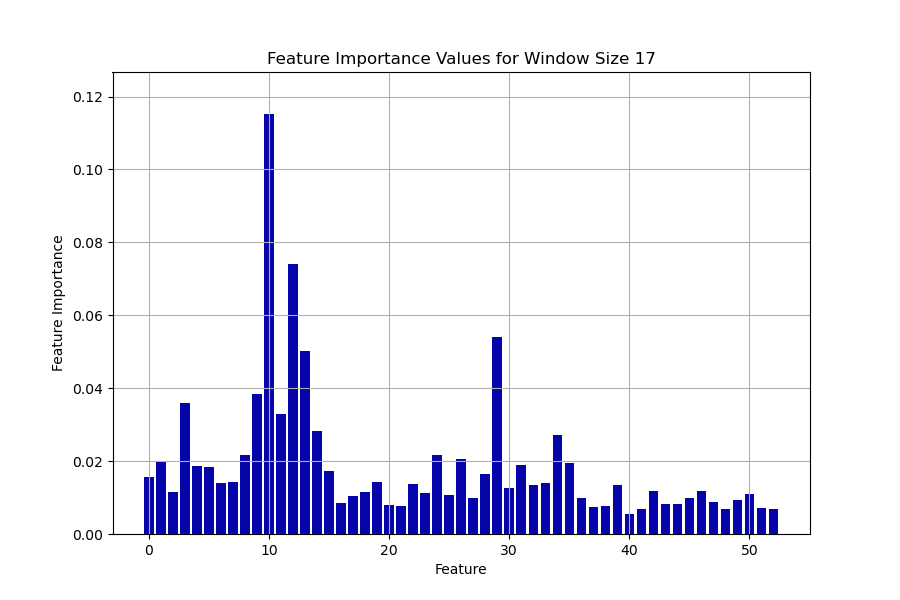

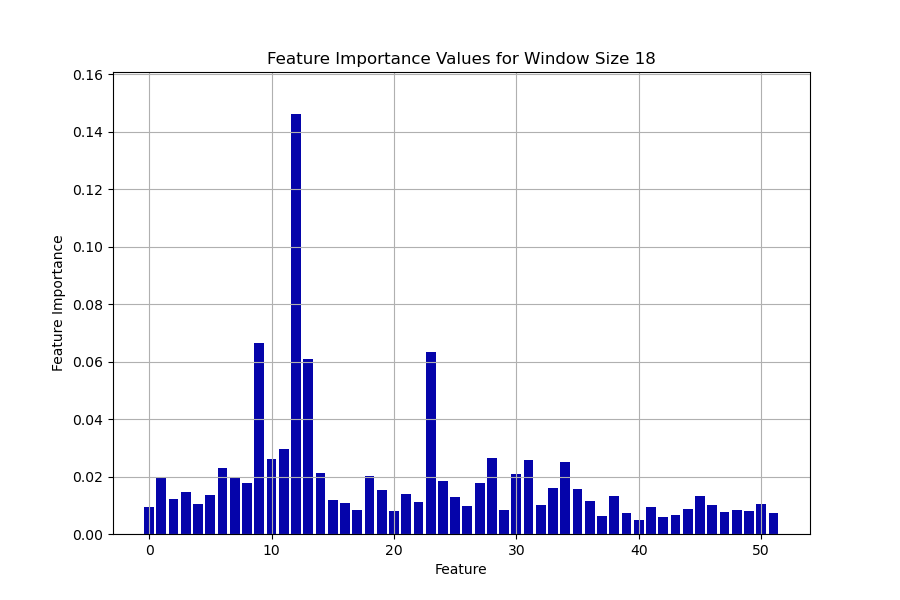

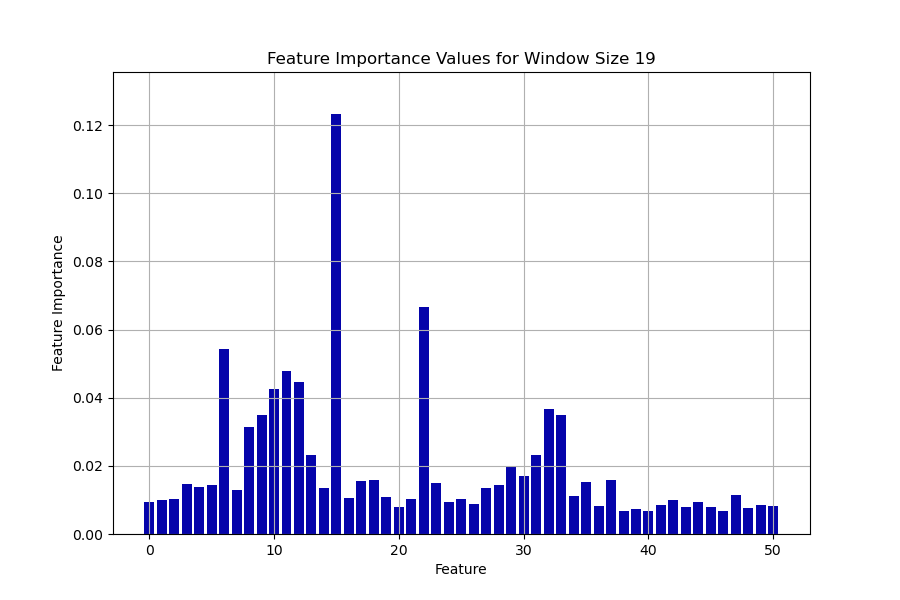

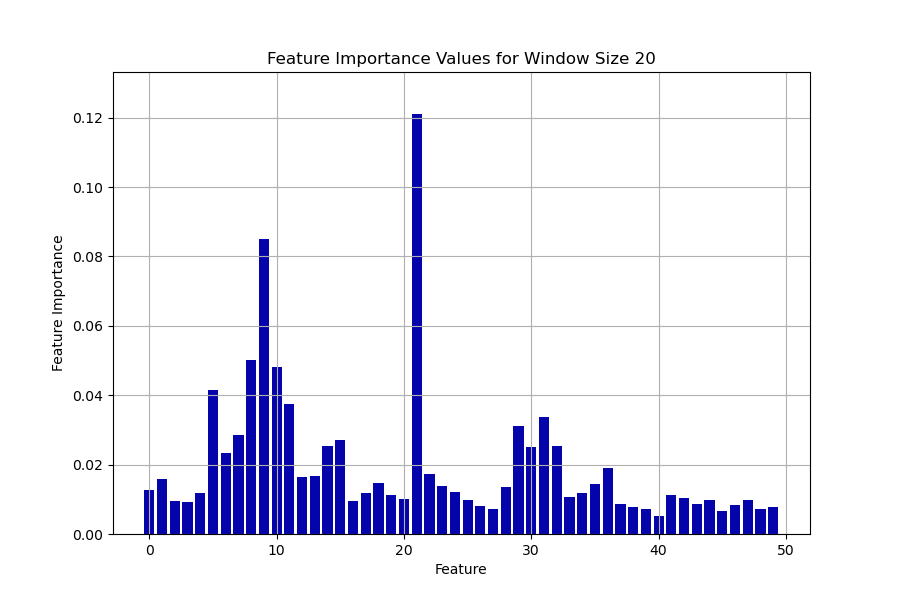

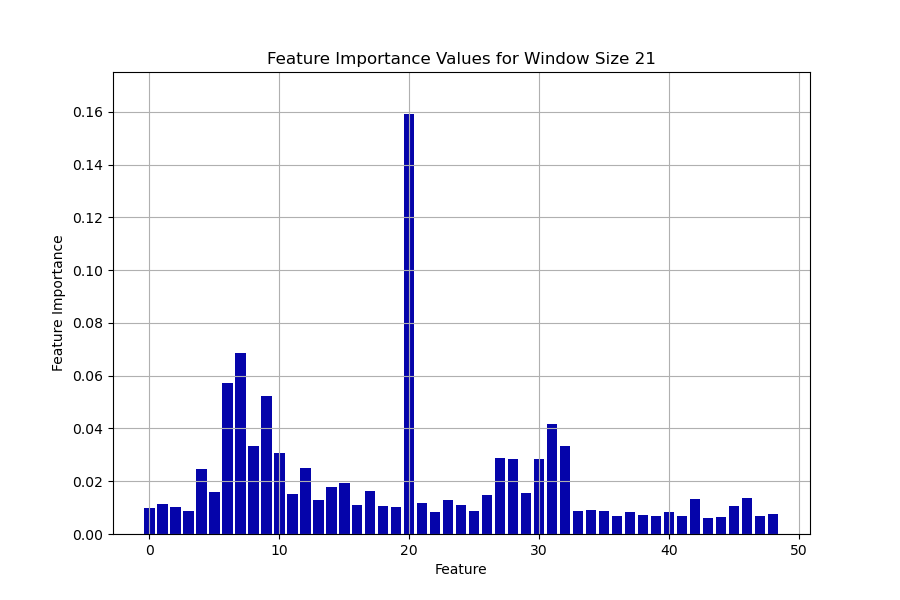

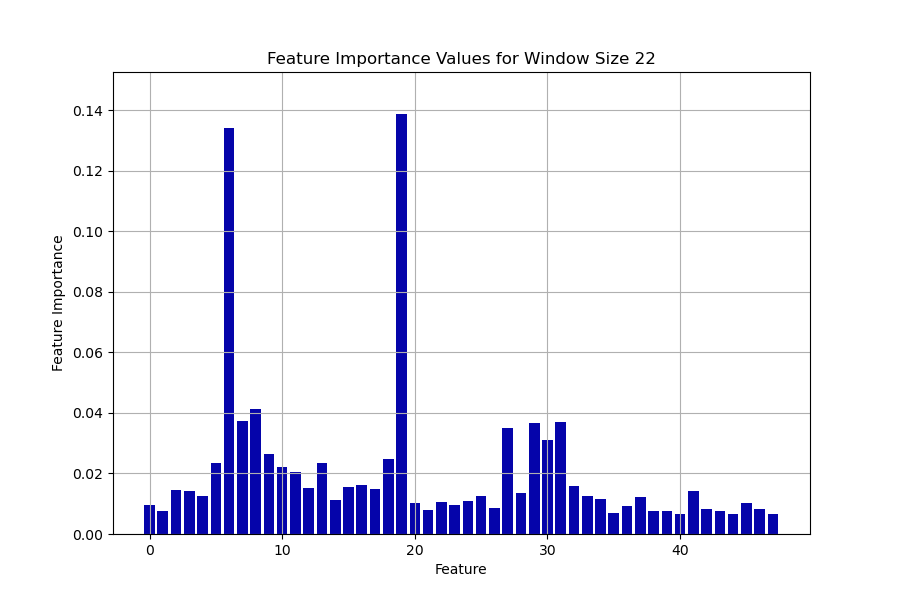

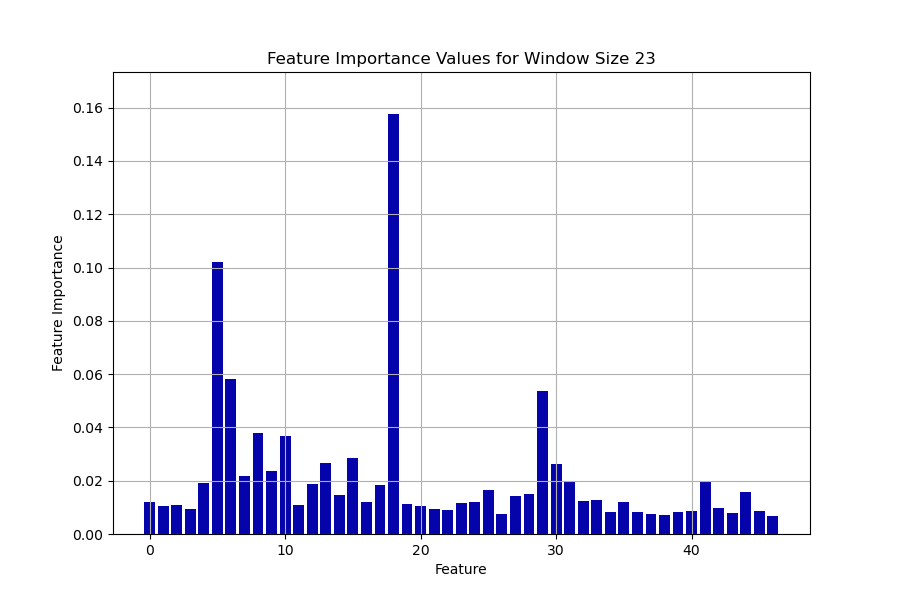

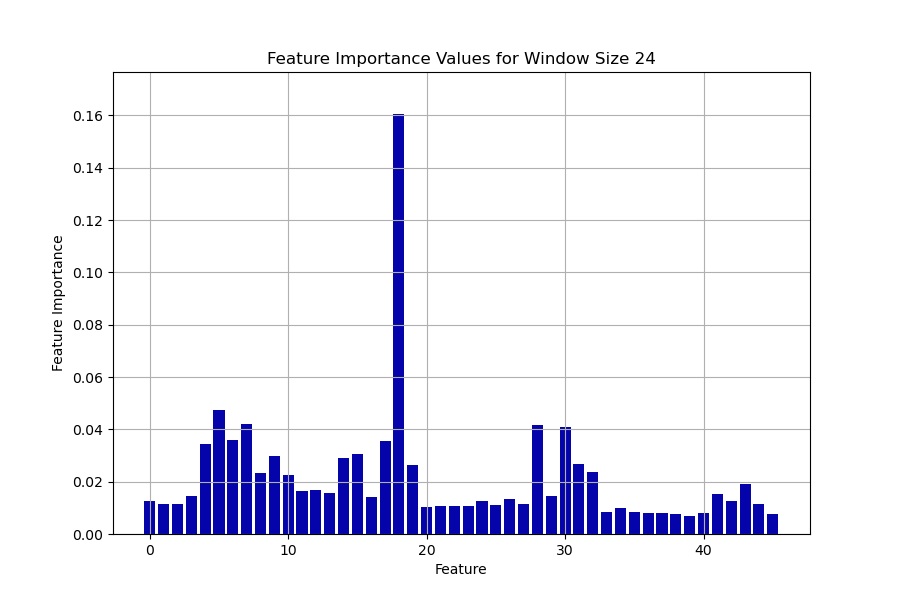

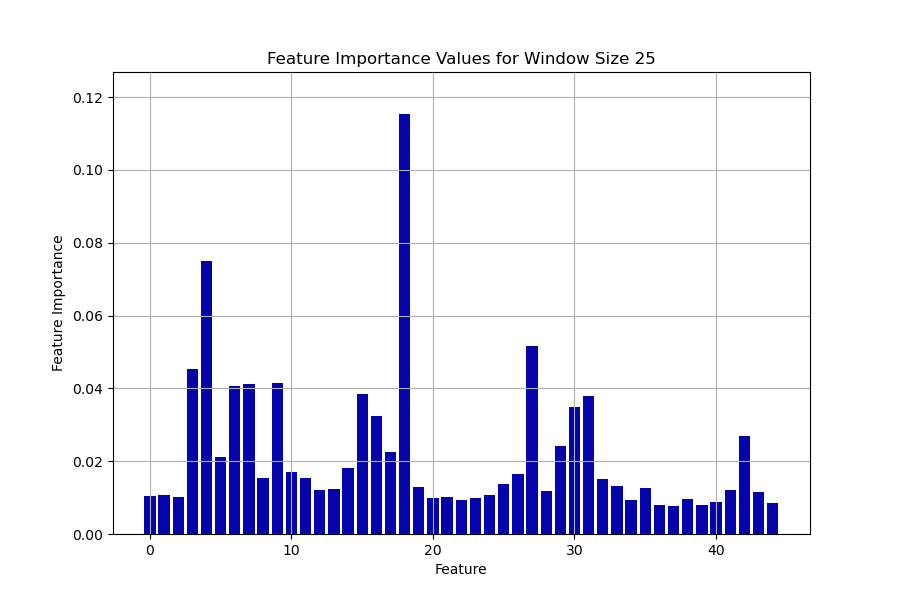

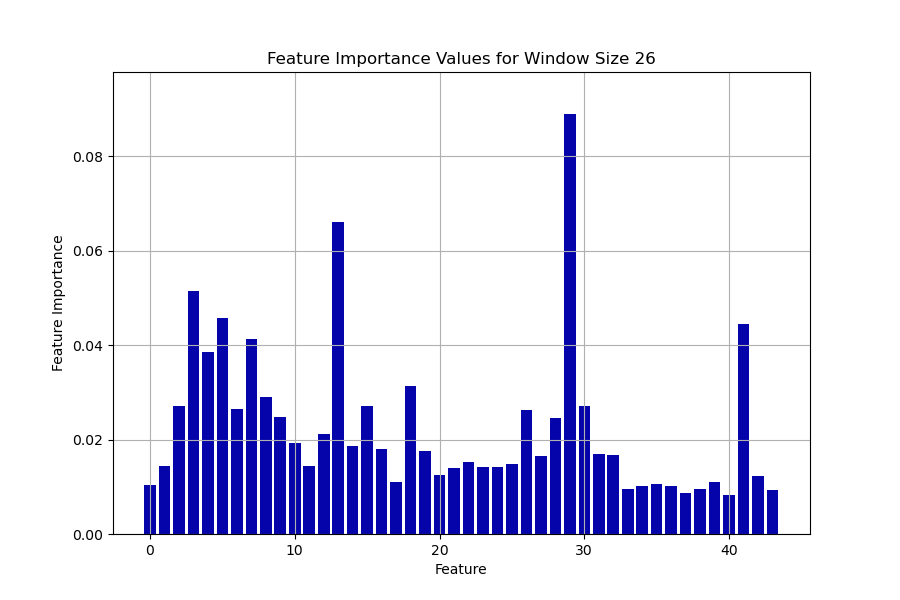

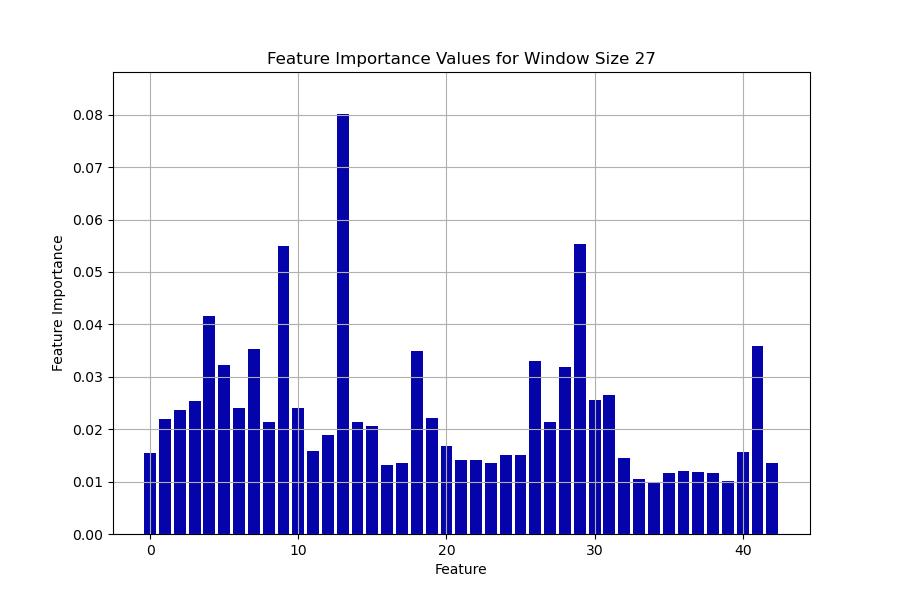

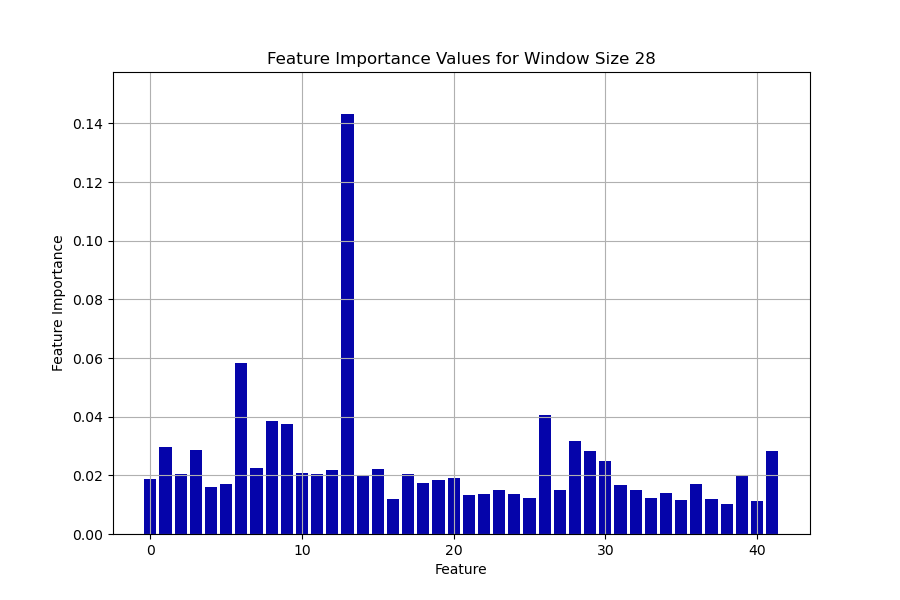

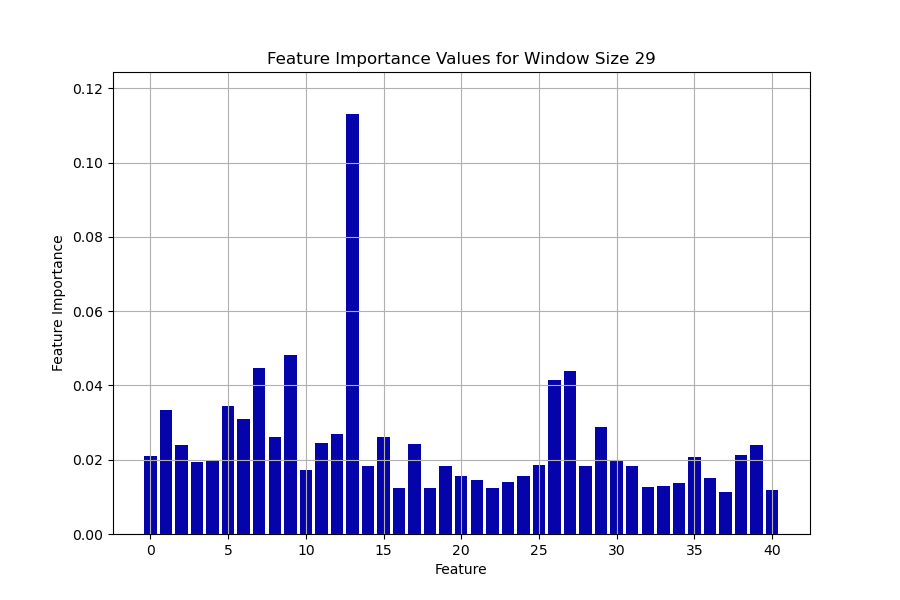

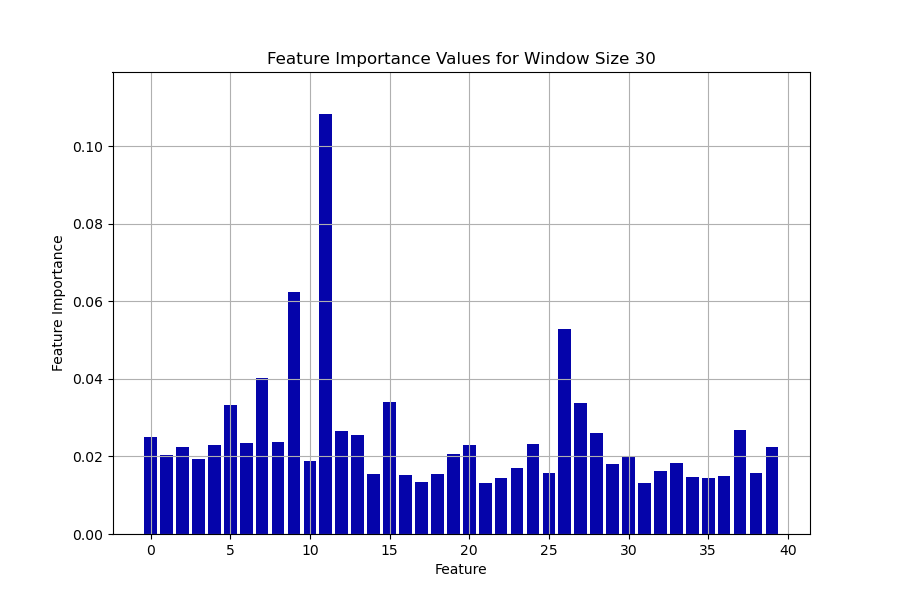

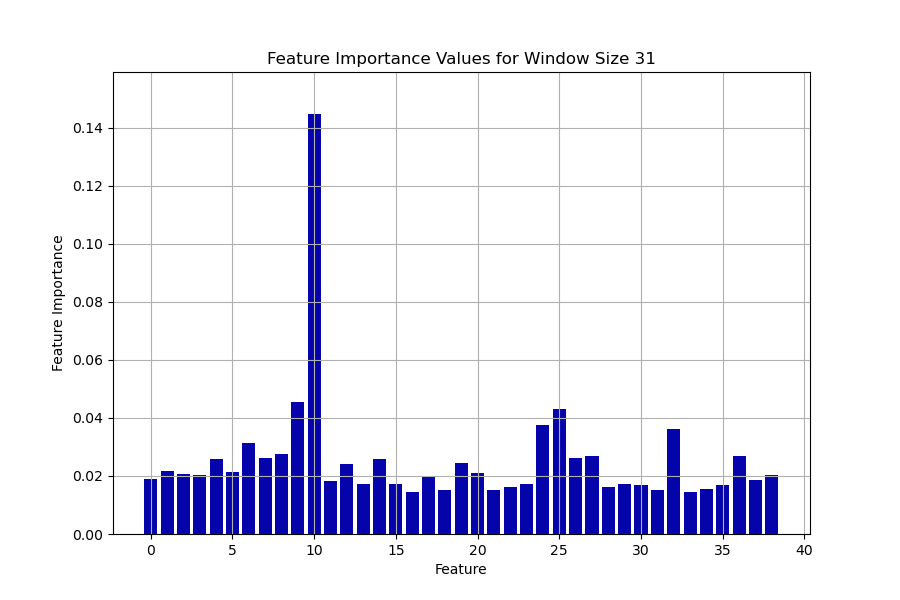

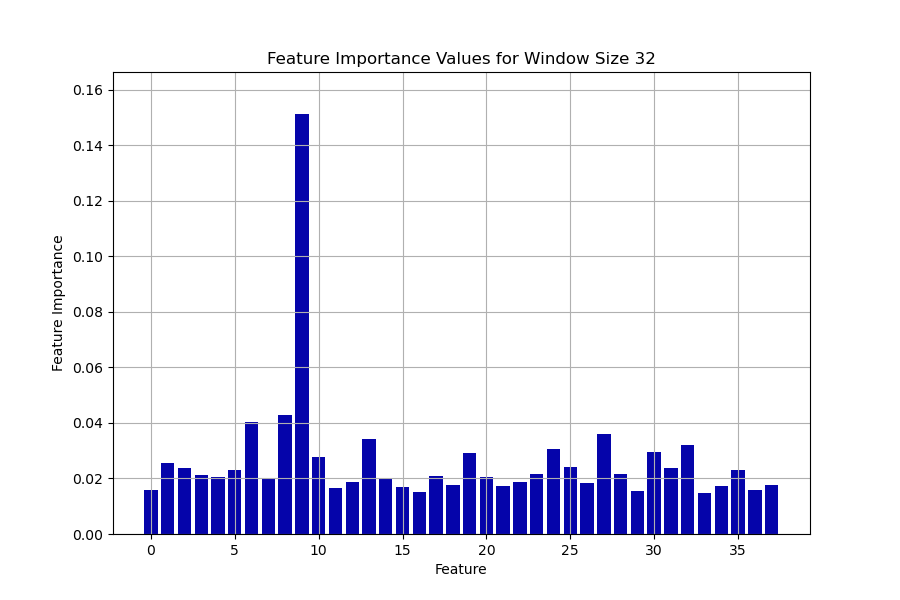

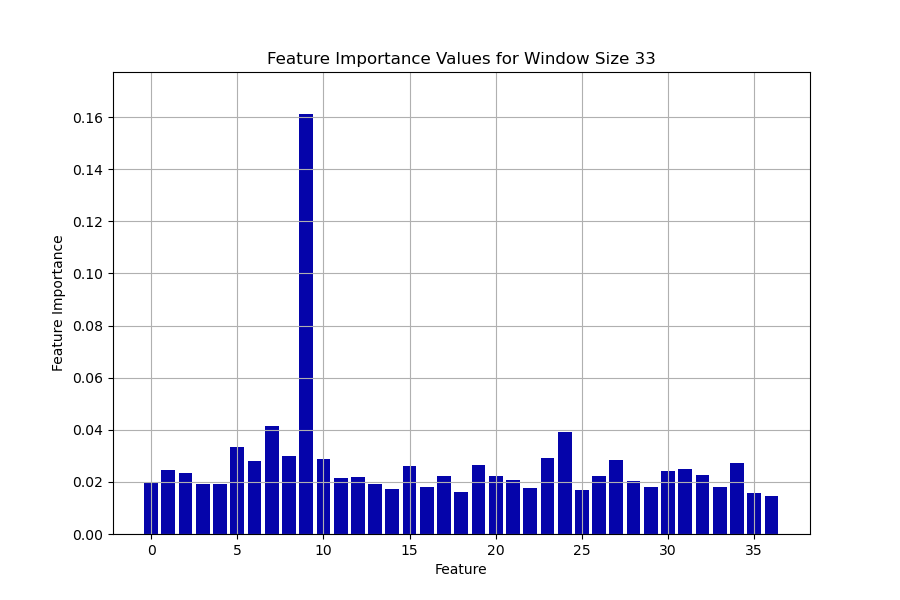

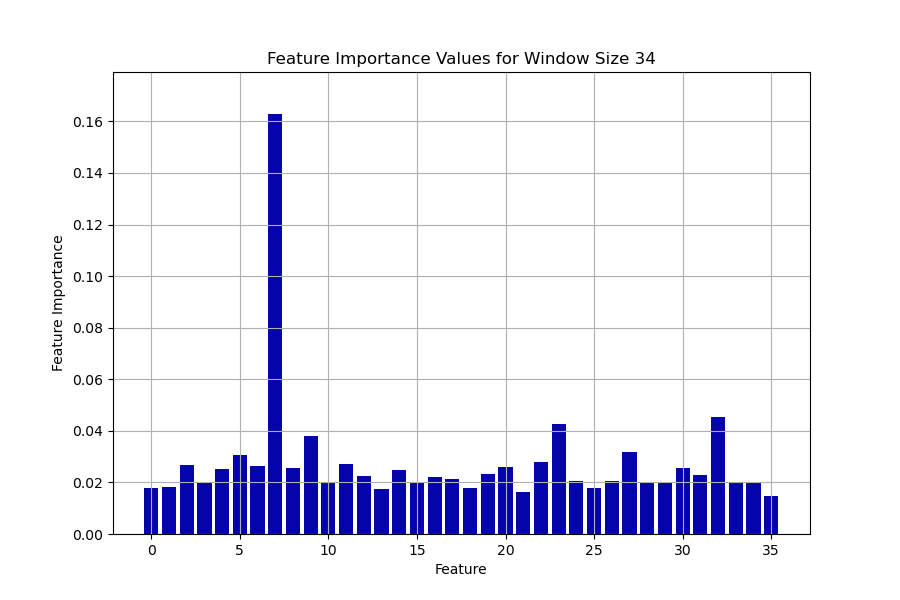

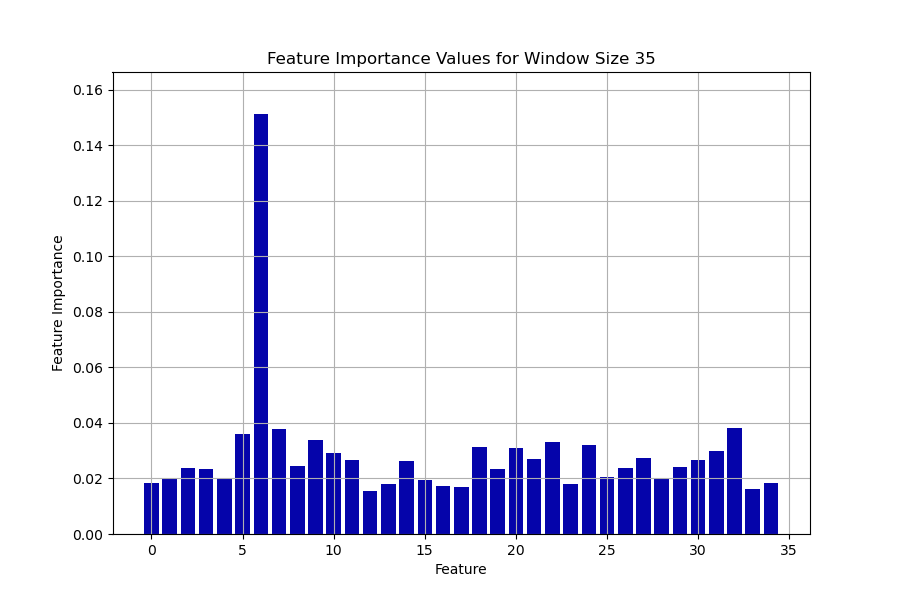

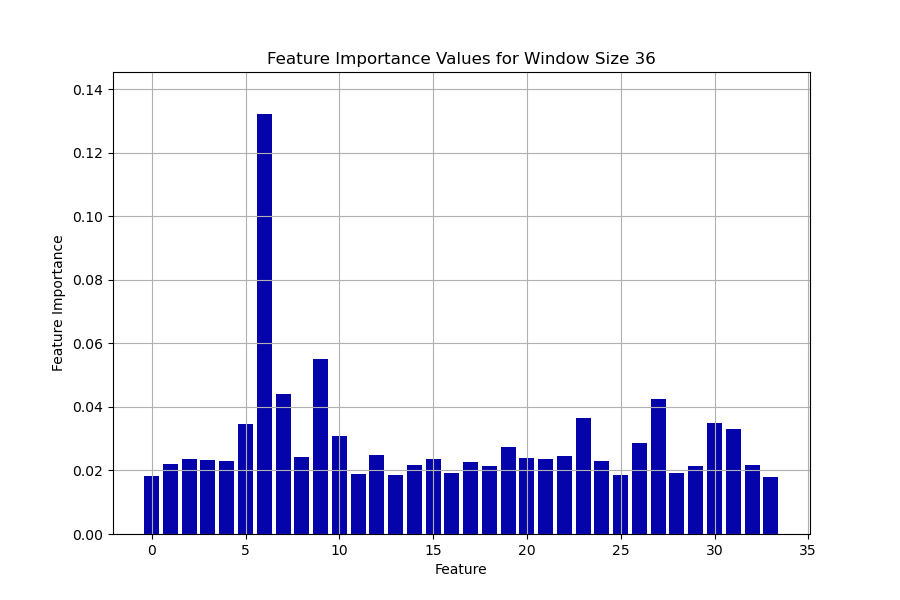

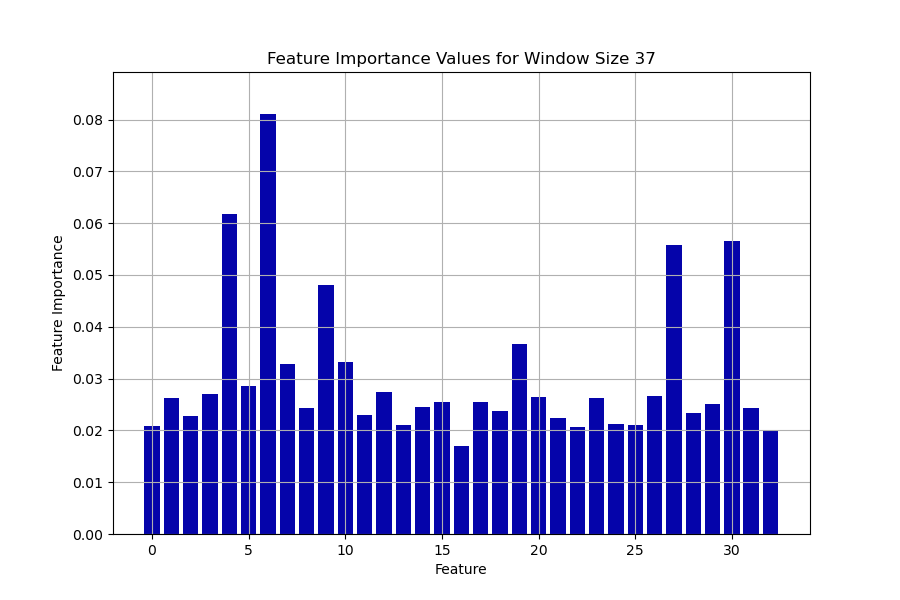

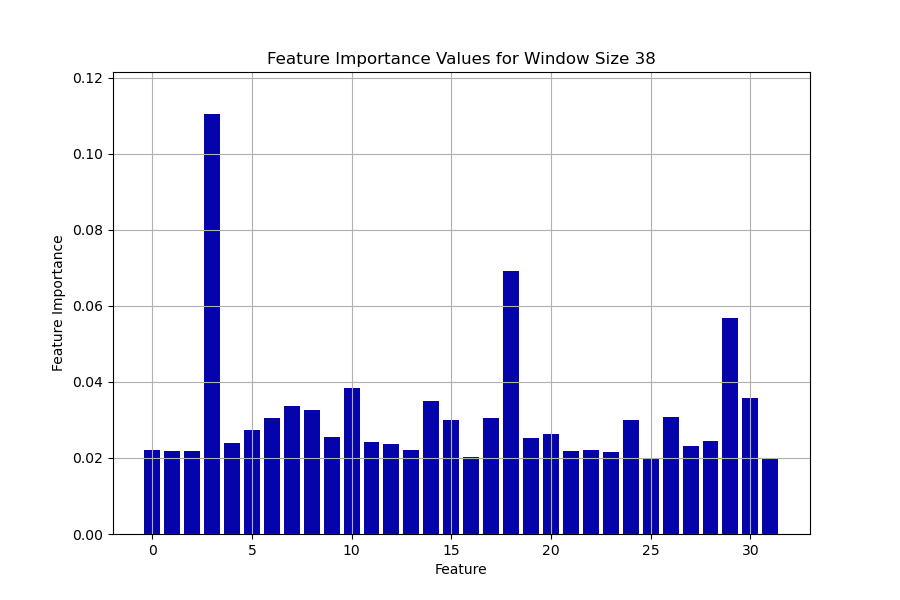

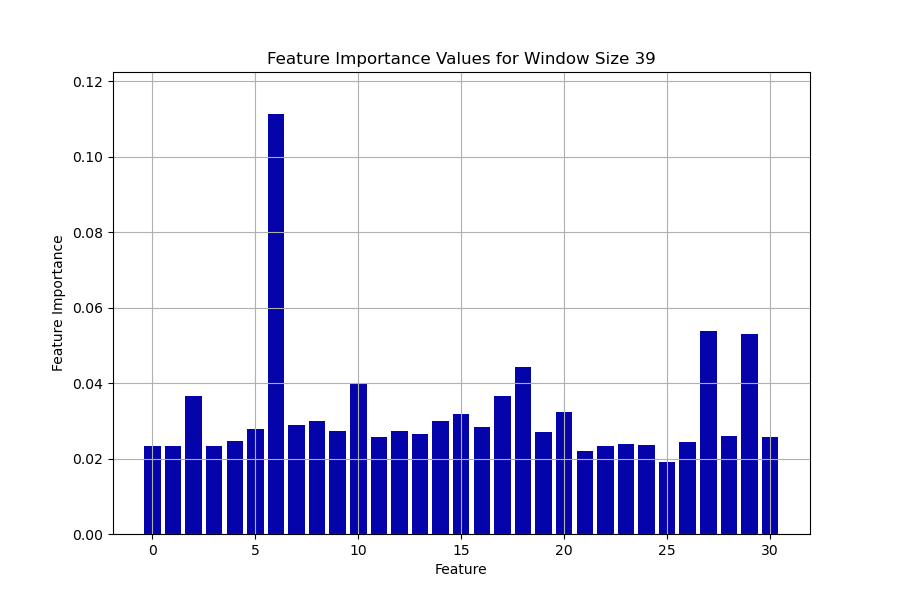

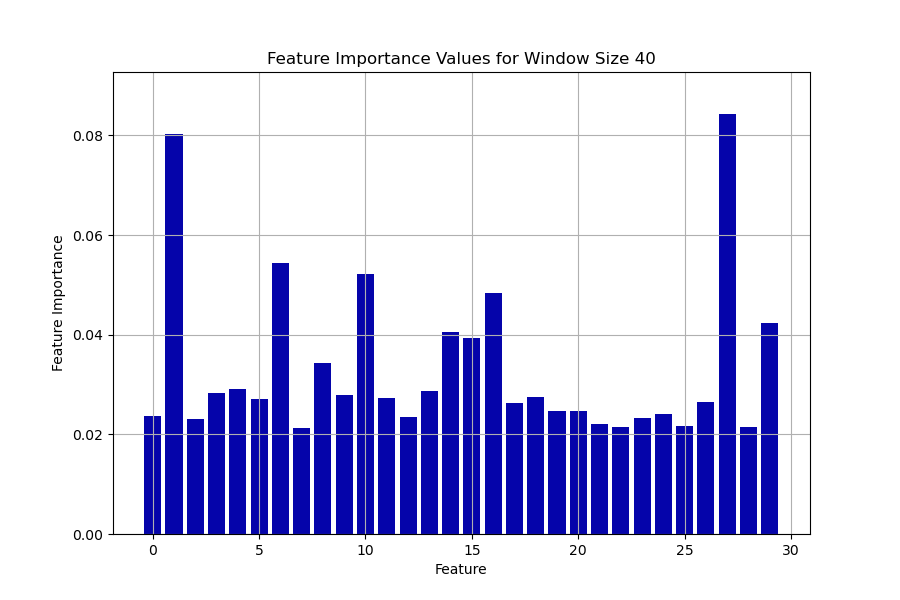

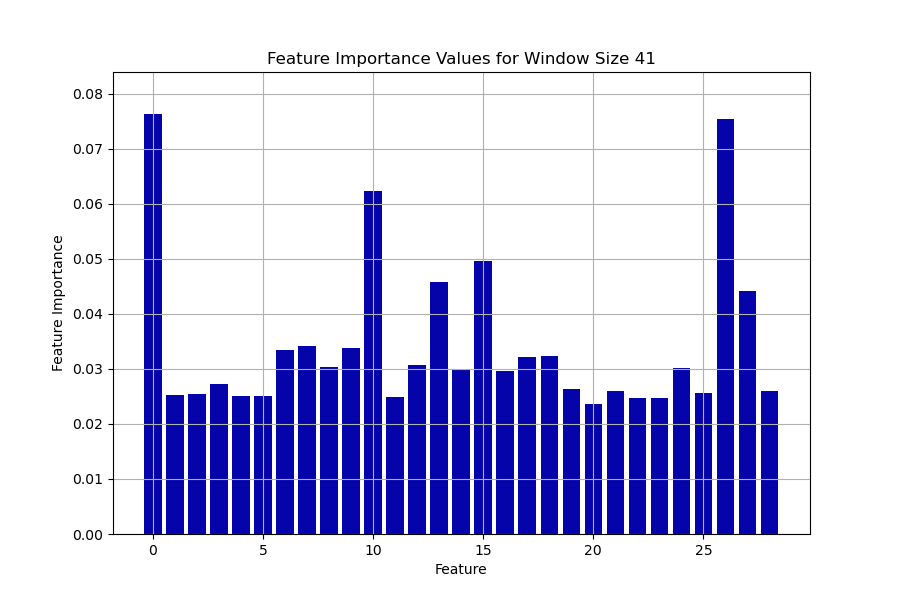

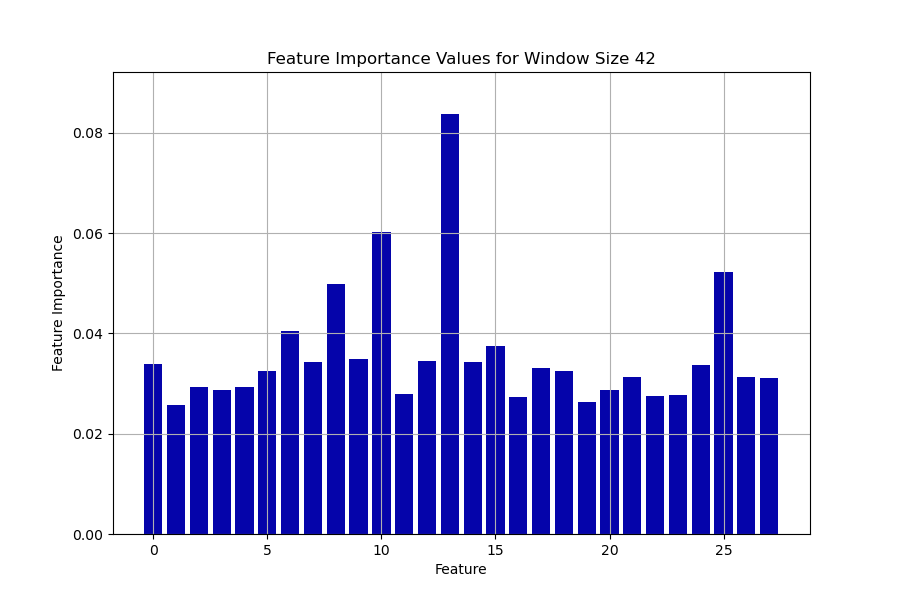

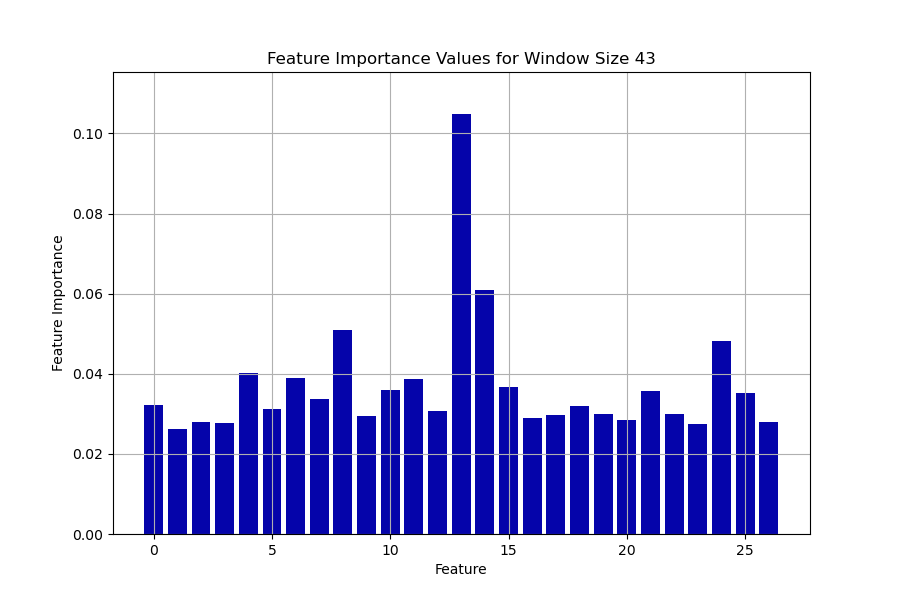

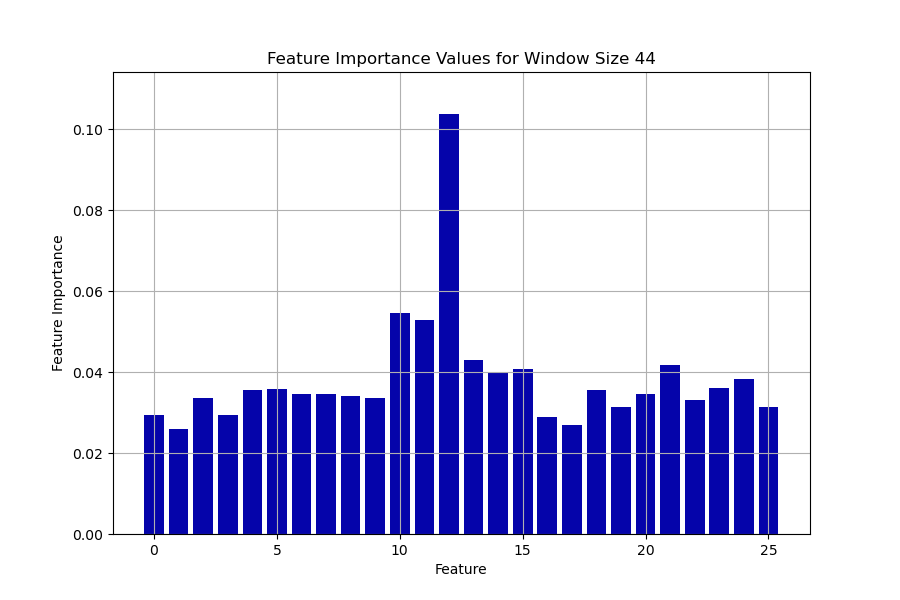

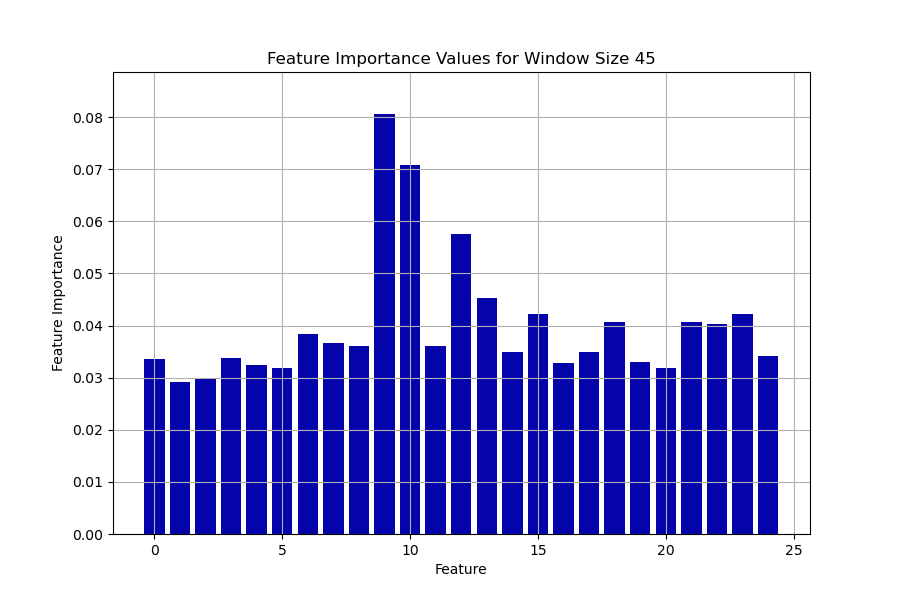

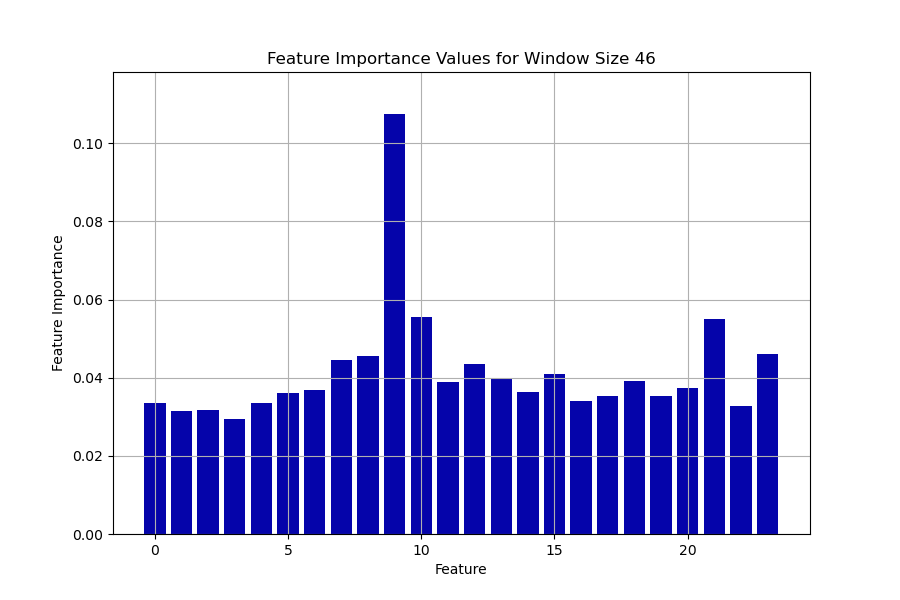

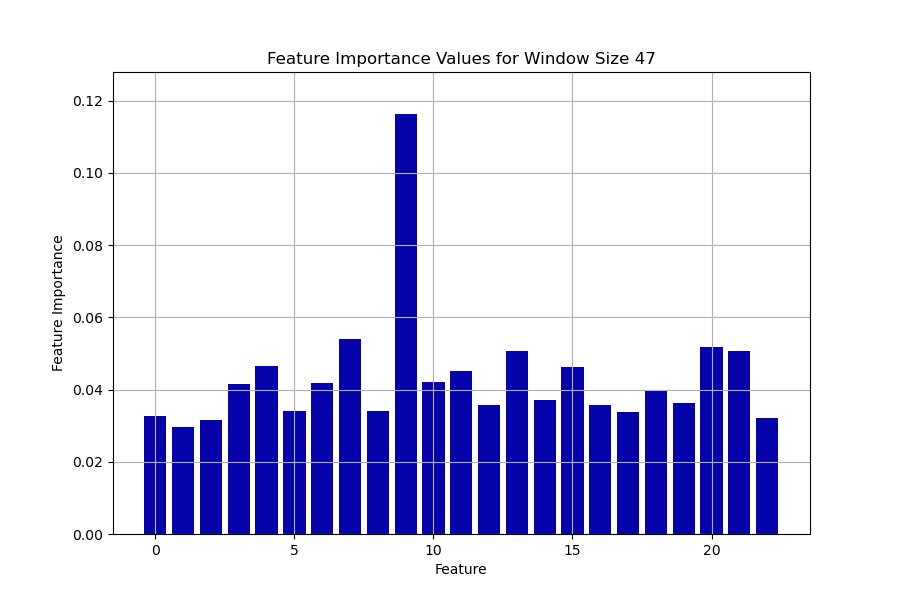

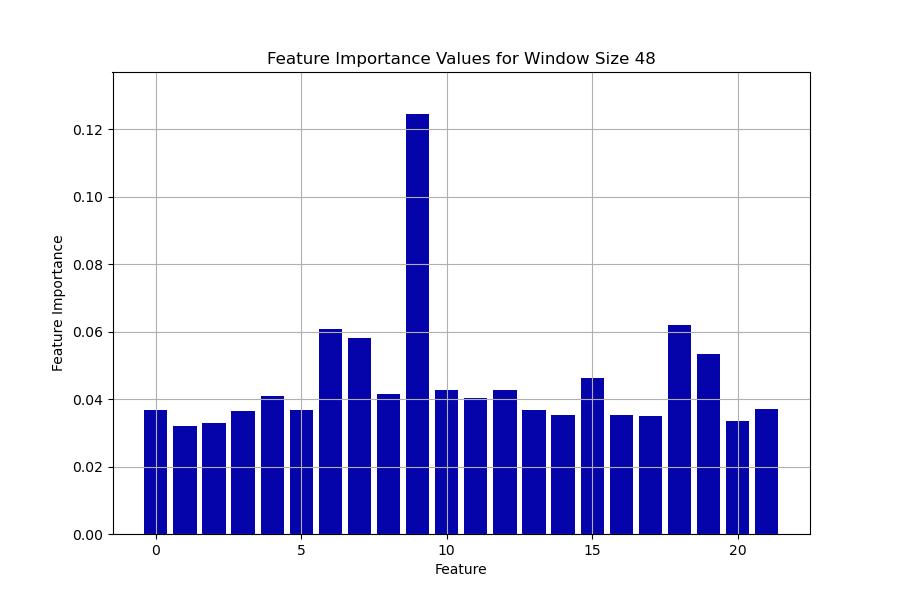

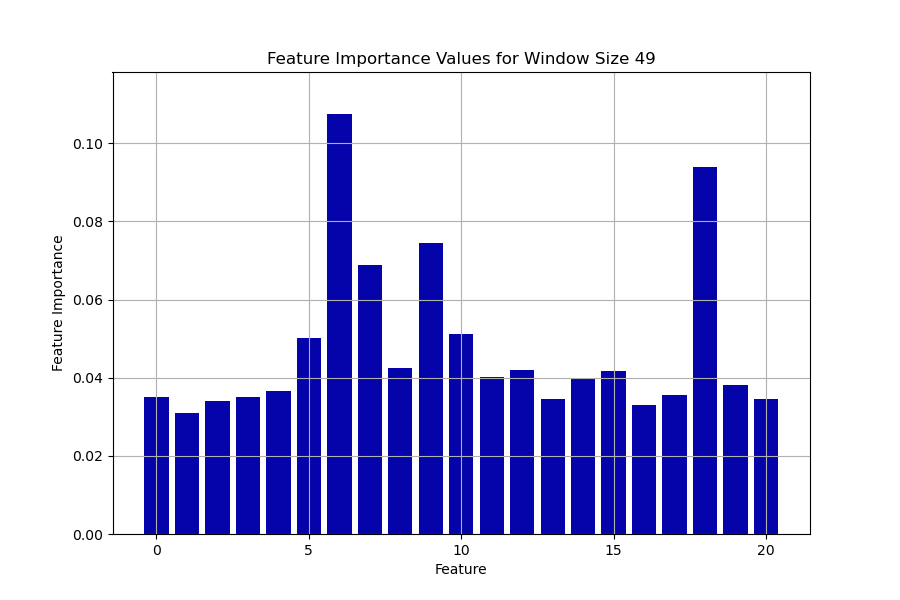

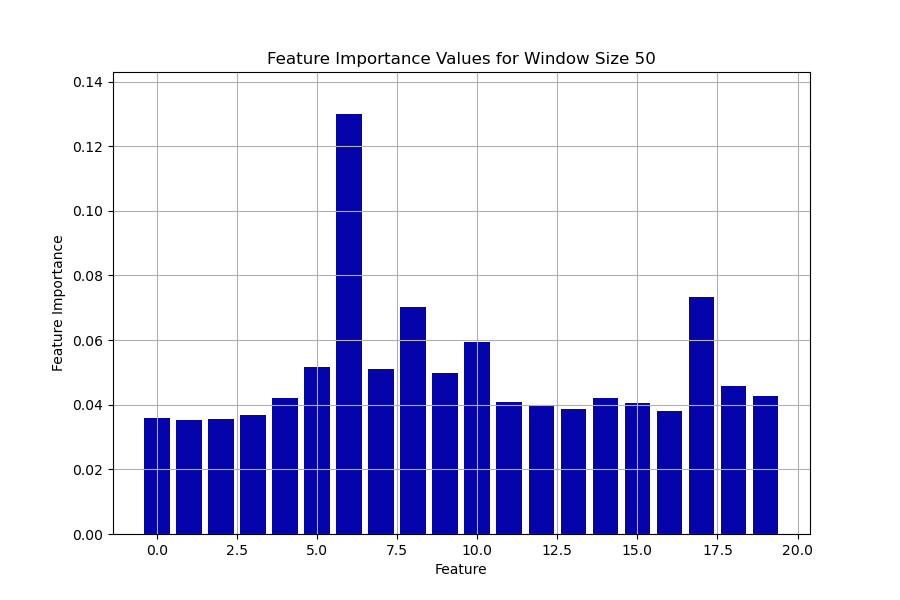

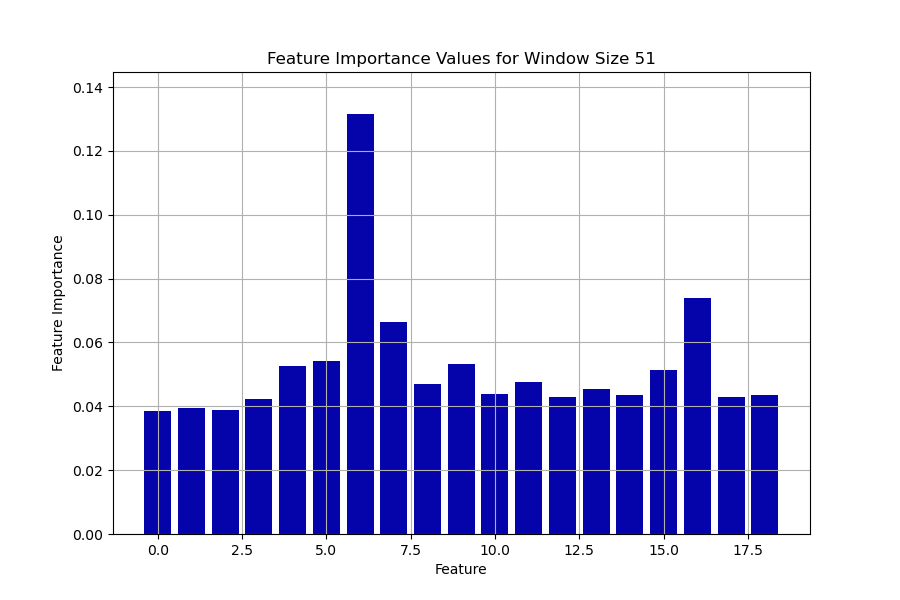

In [10]:
# Display the saved feature importance plots in the notebook
trainer.display_feature_importance_plots('XGB_Pos_Imp_Figs')

## Compare Positions Saved For Different Thresholds: 
- Saves positions above elbow threshold 

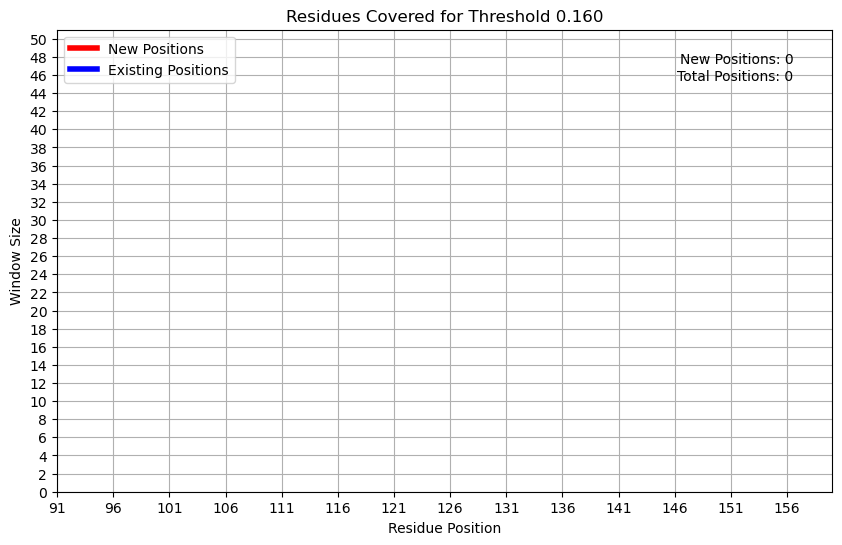

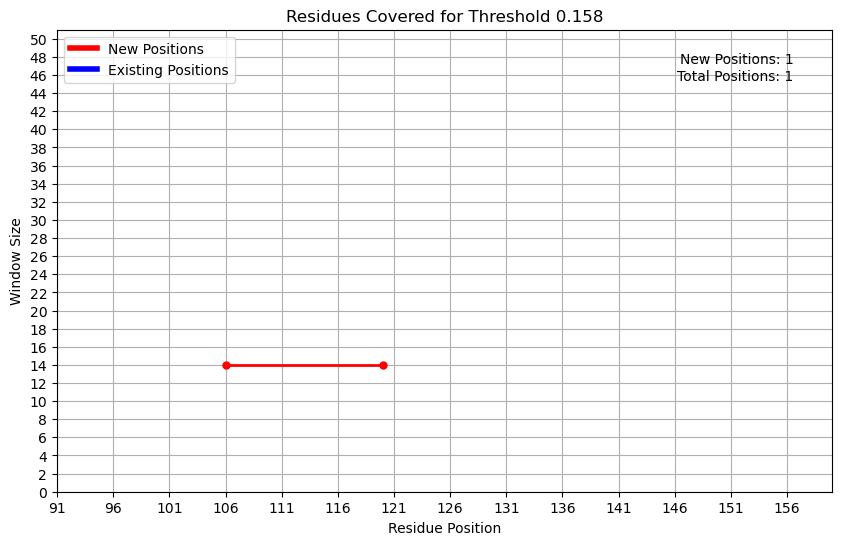

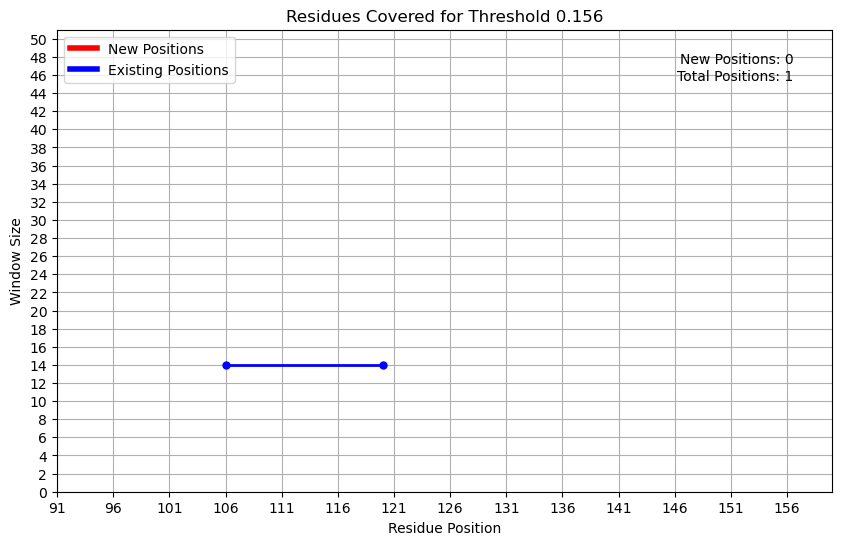

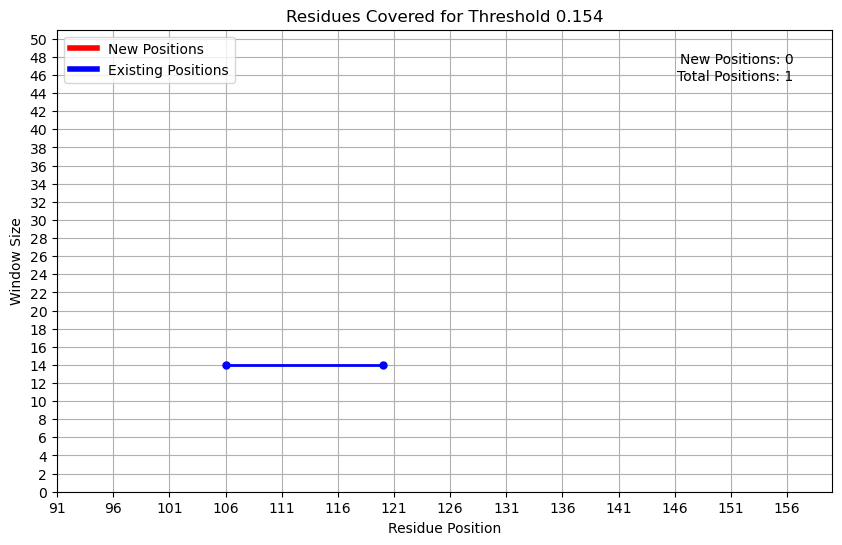

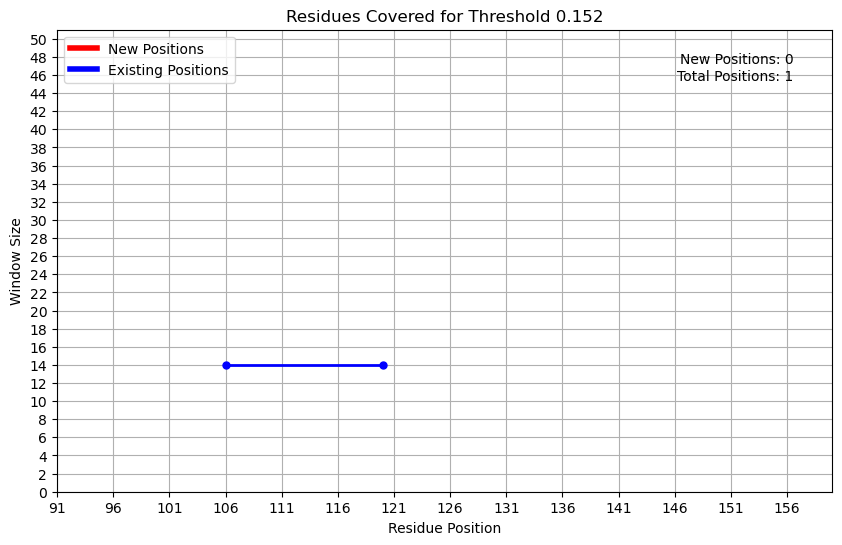

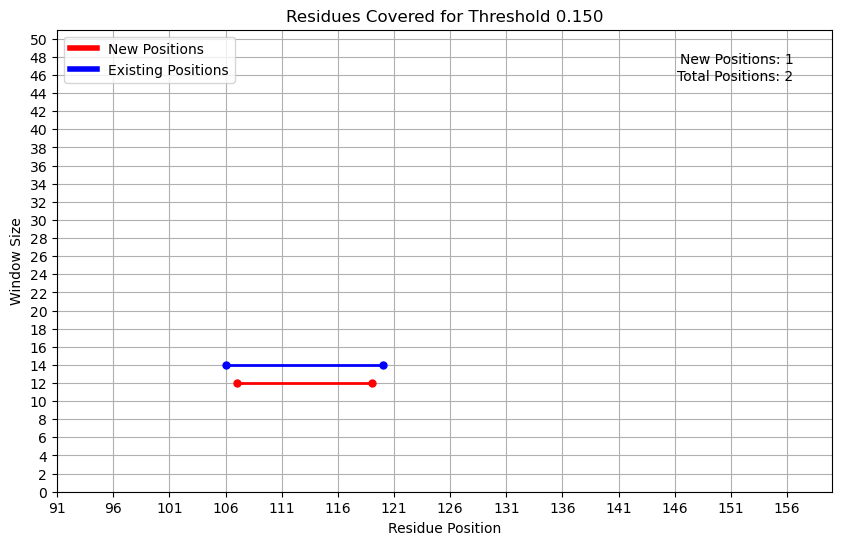

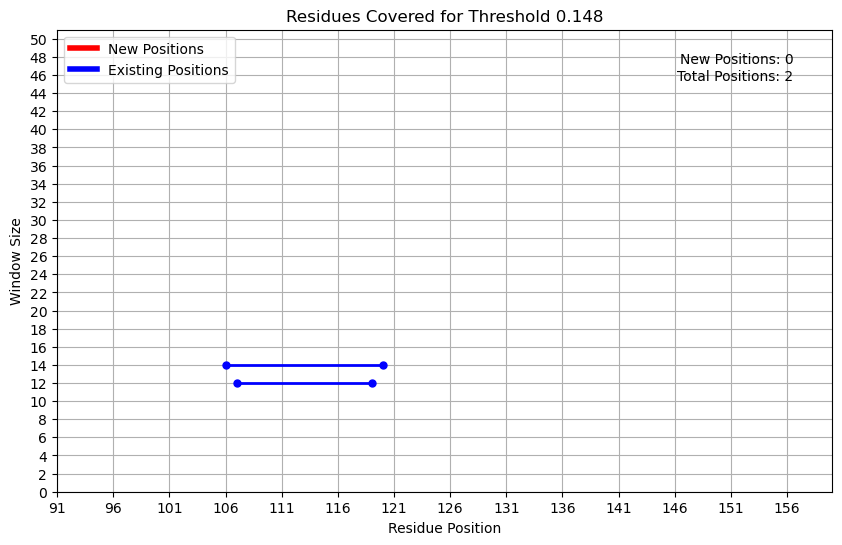

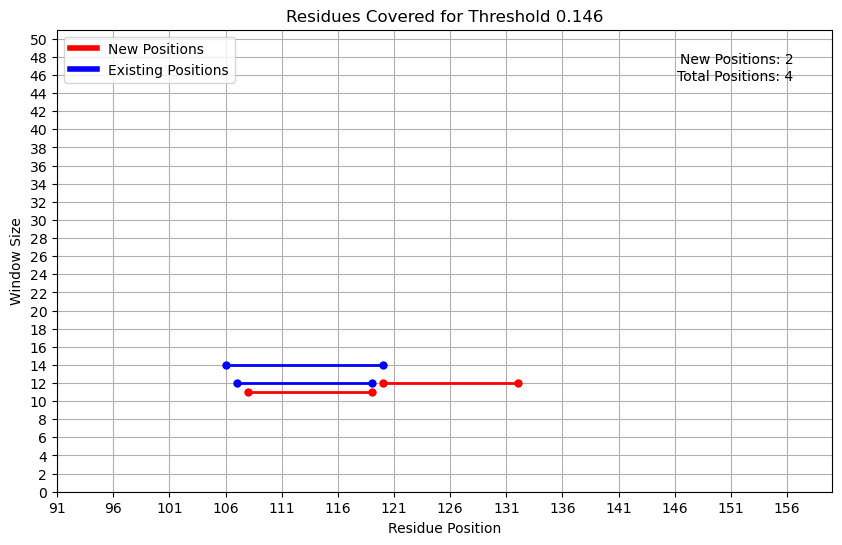

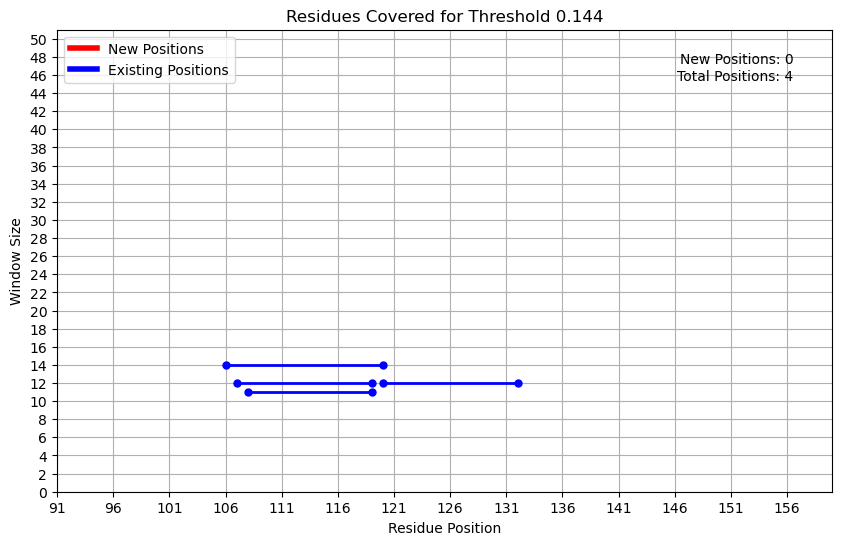

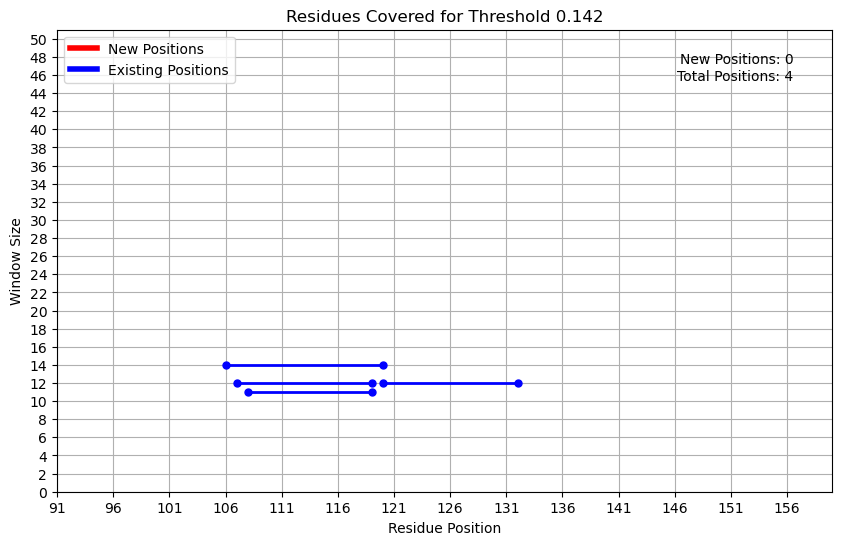

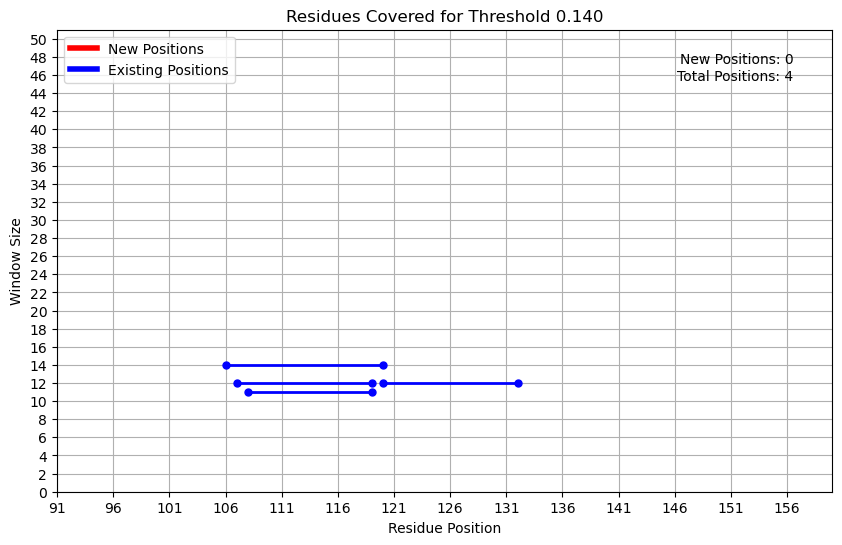

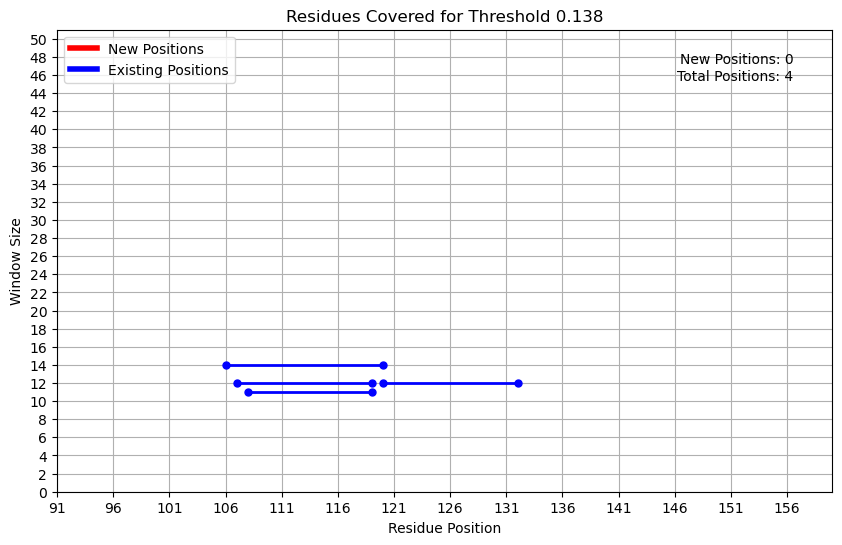

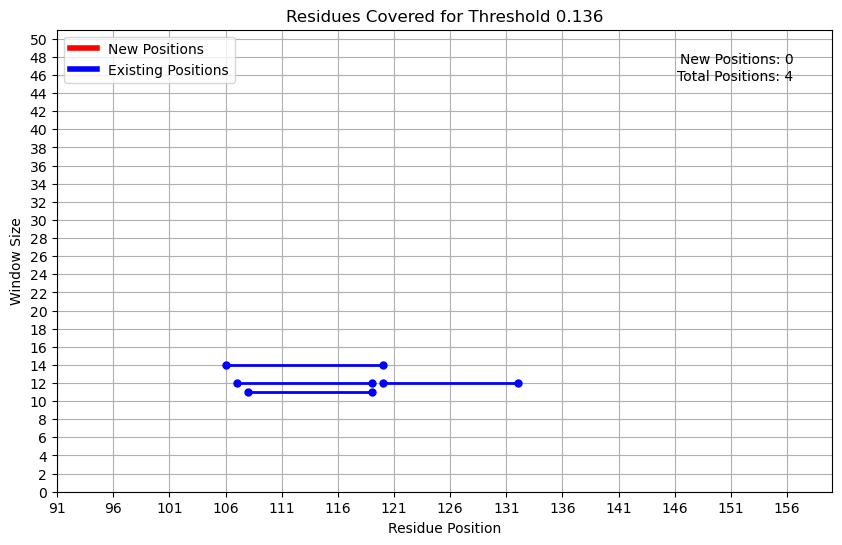

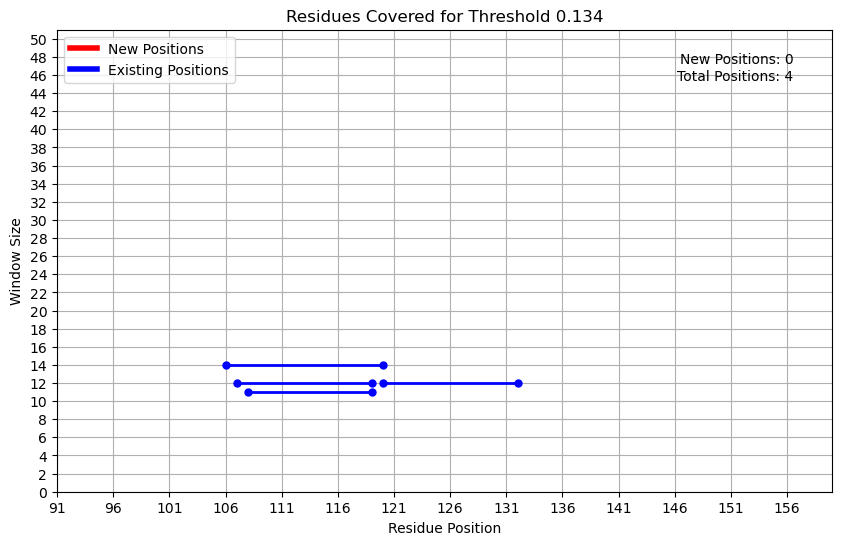

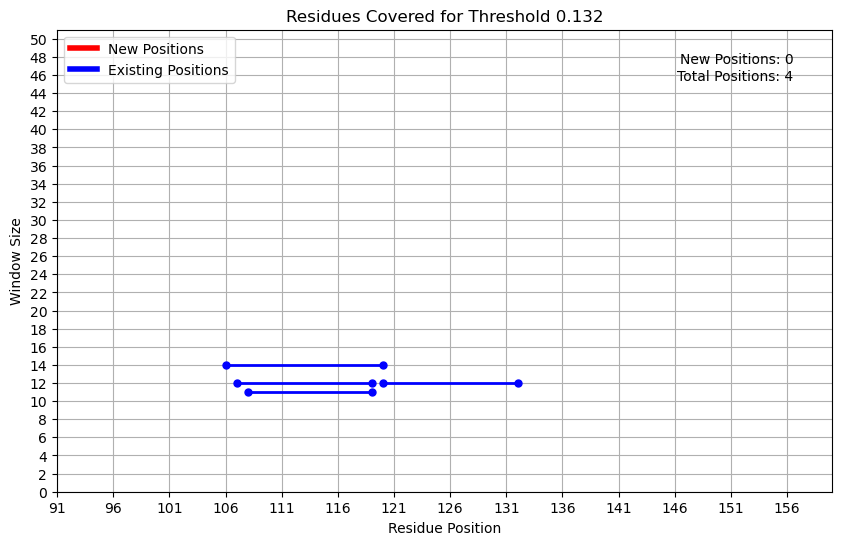

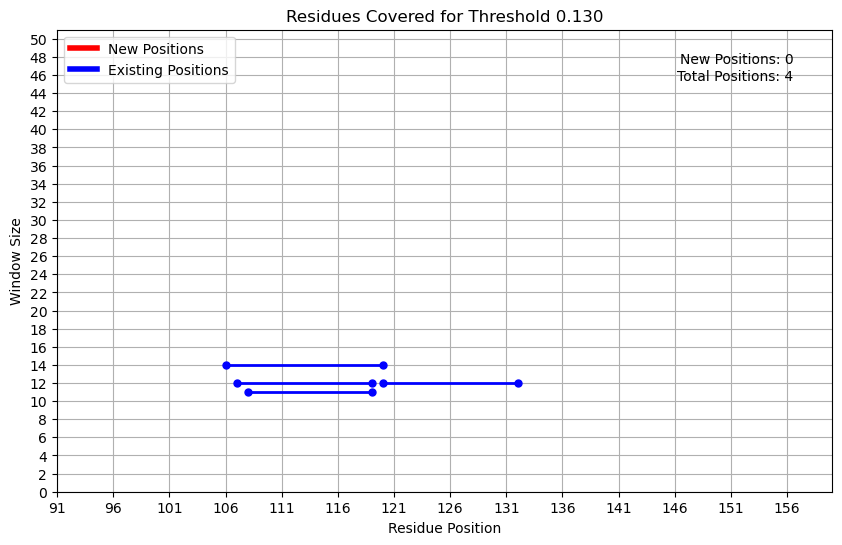

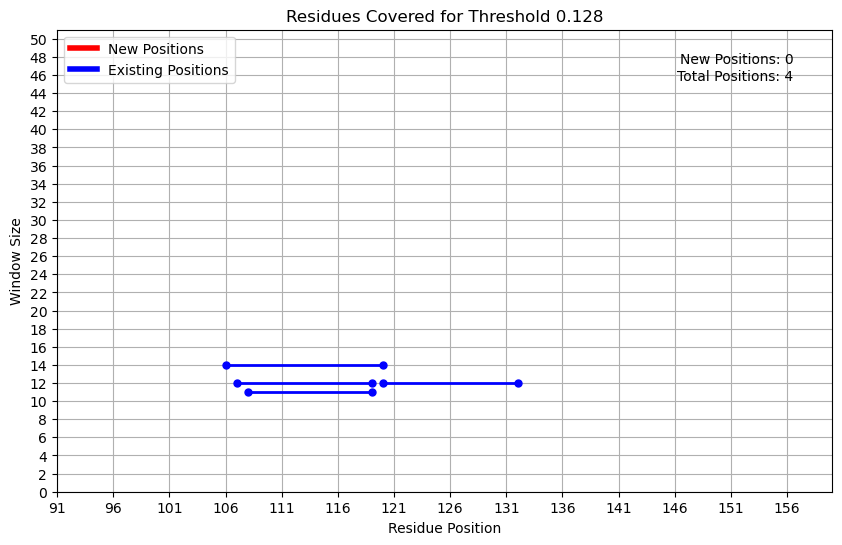

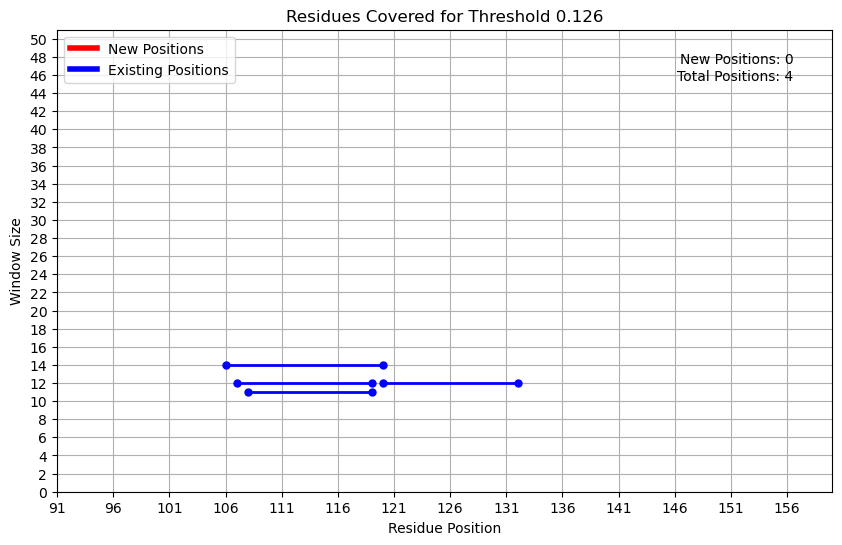

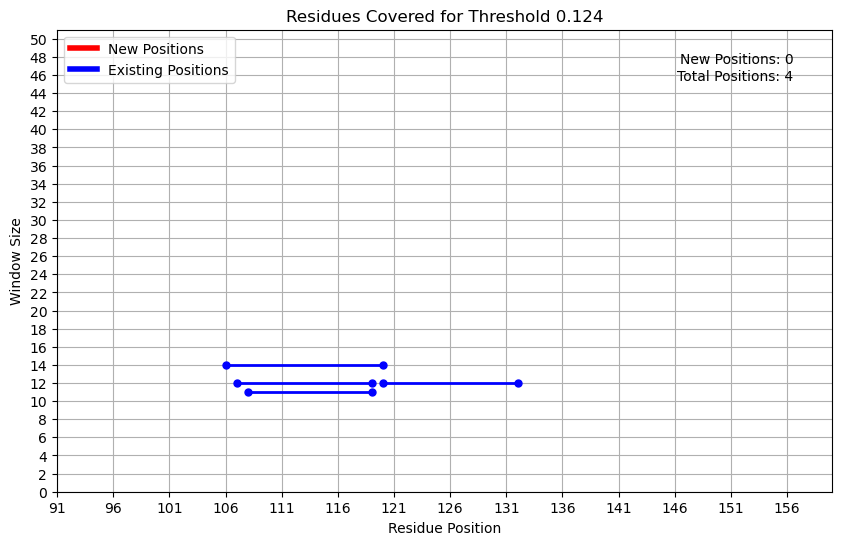

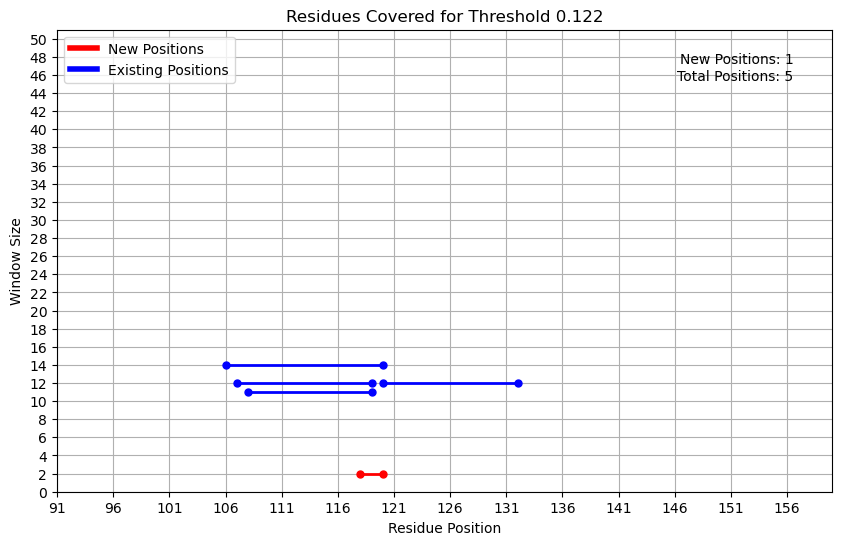

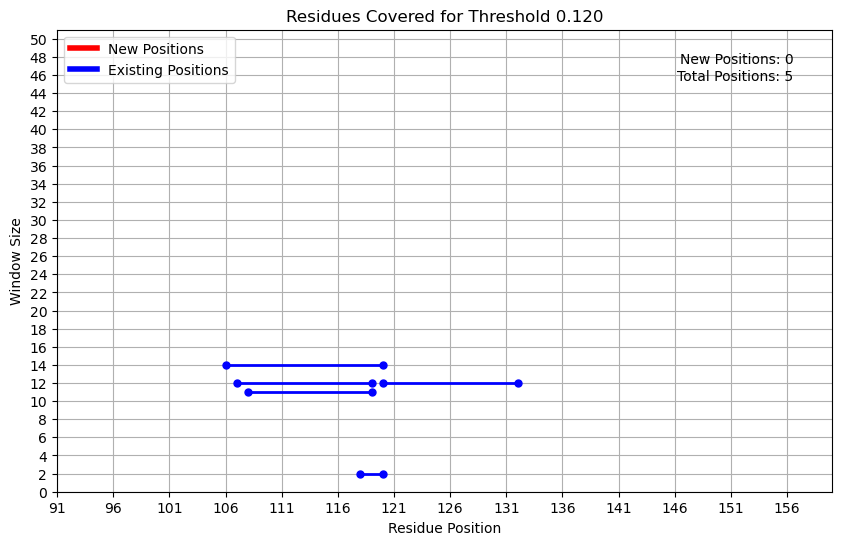

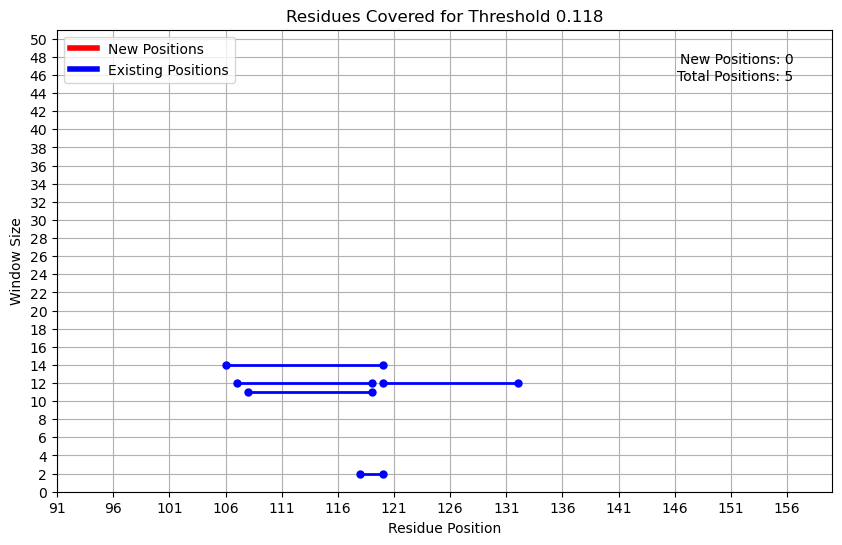

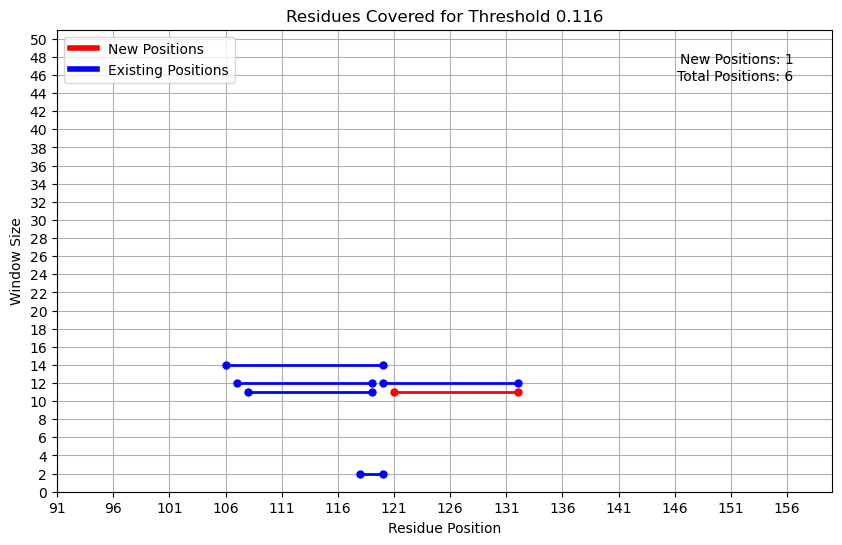

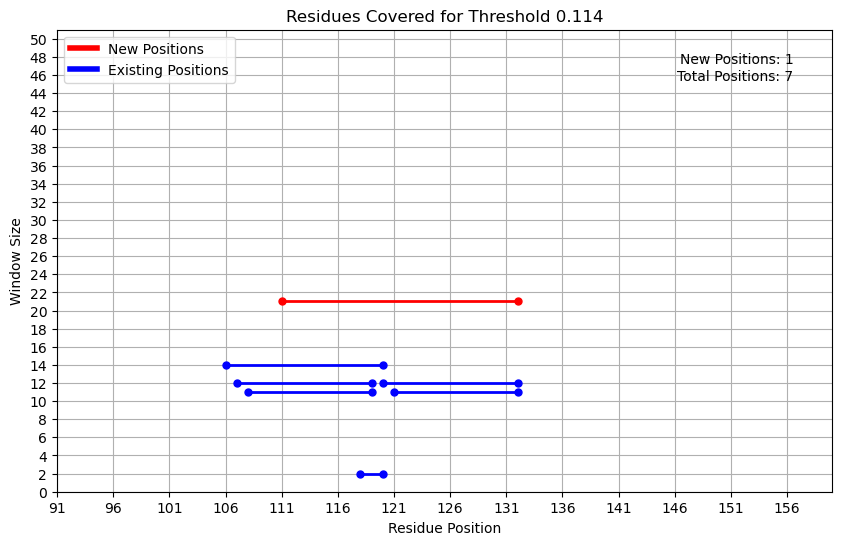

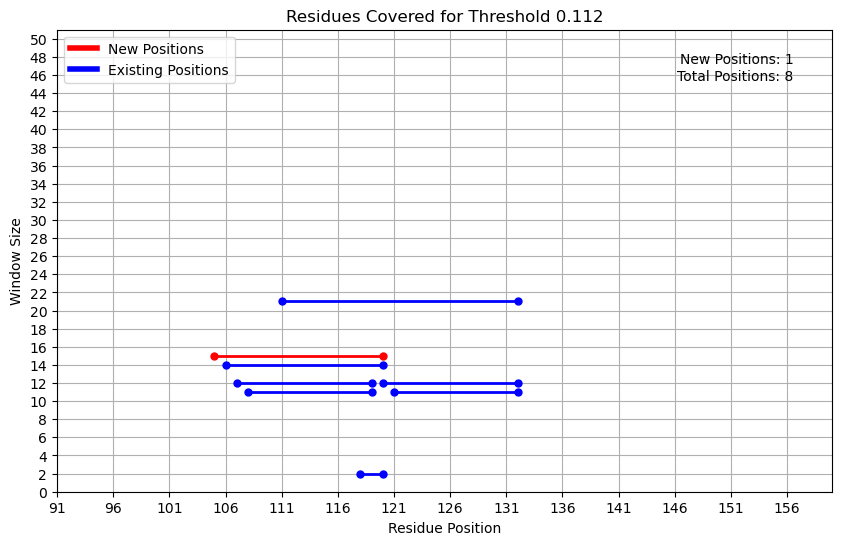

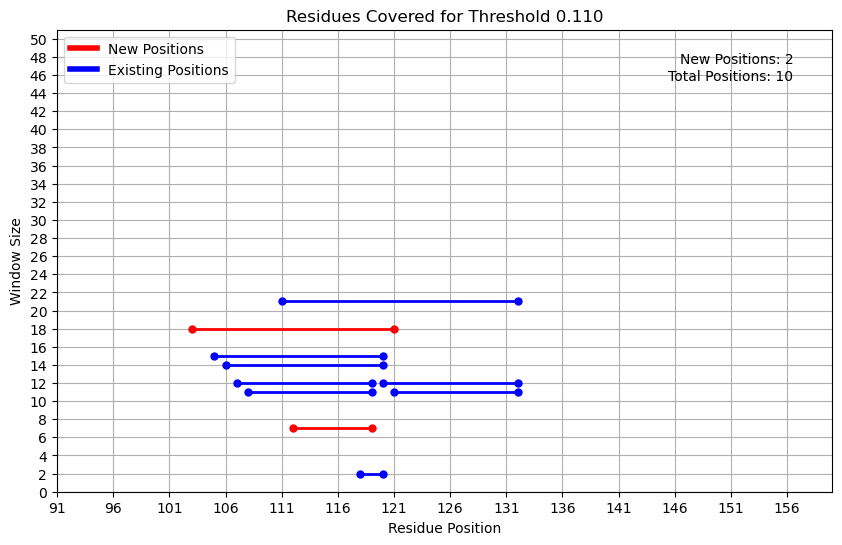

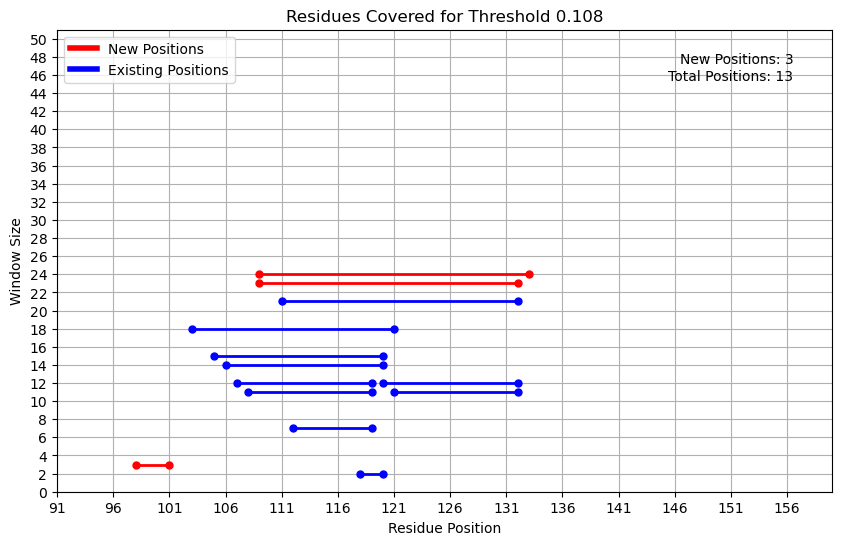

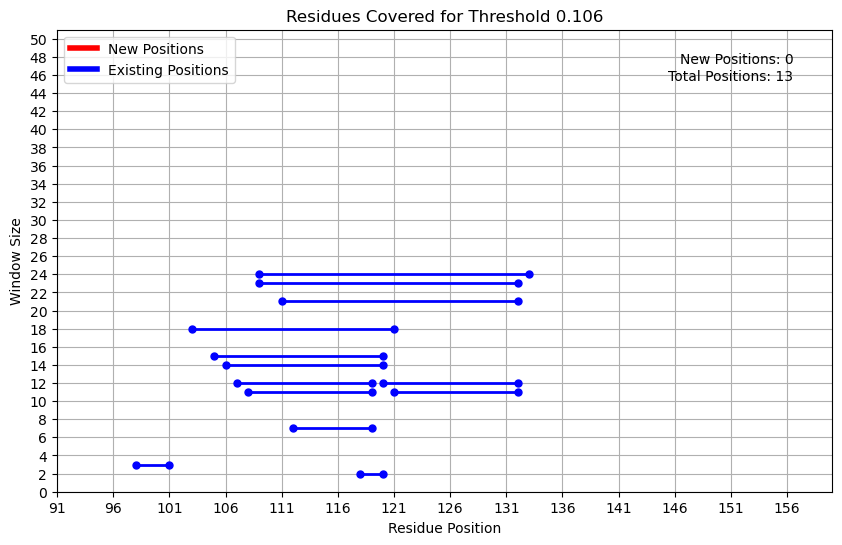

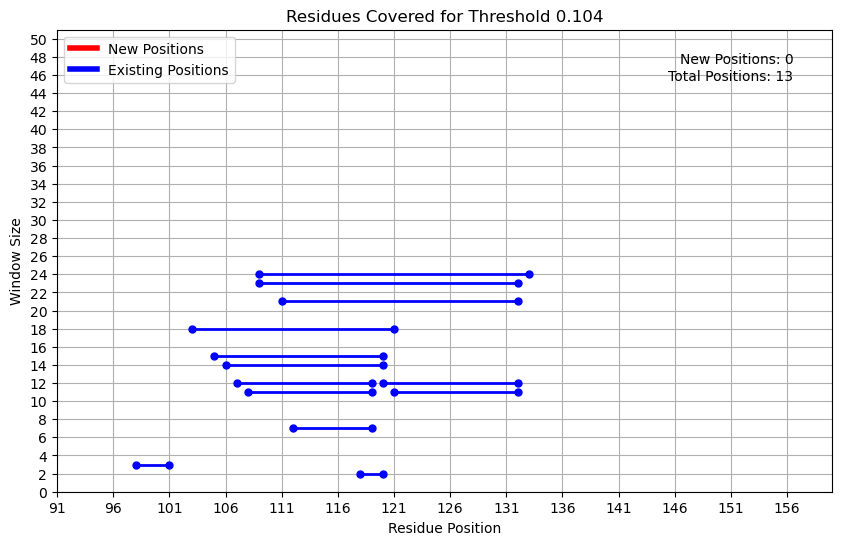

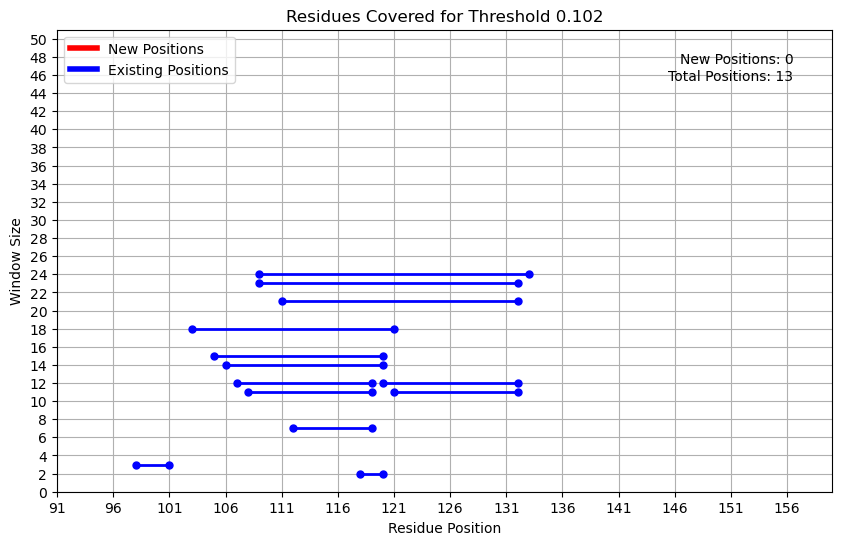

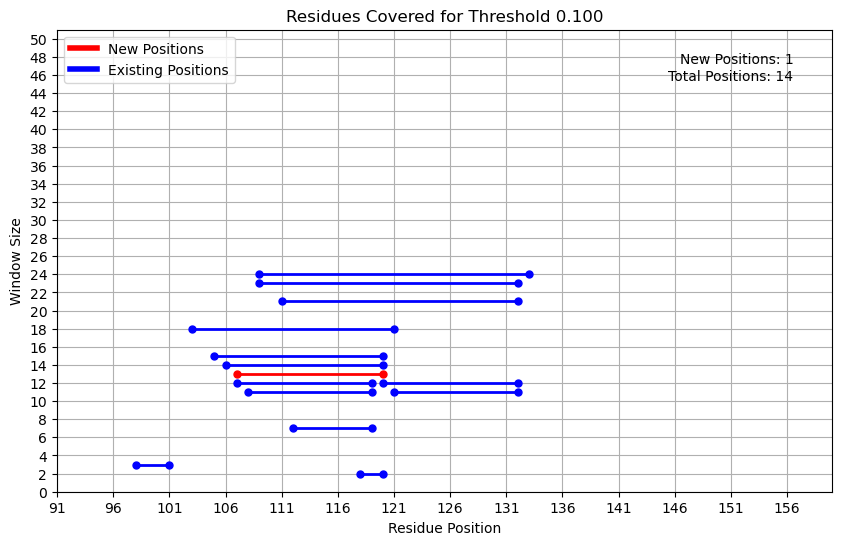

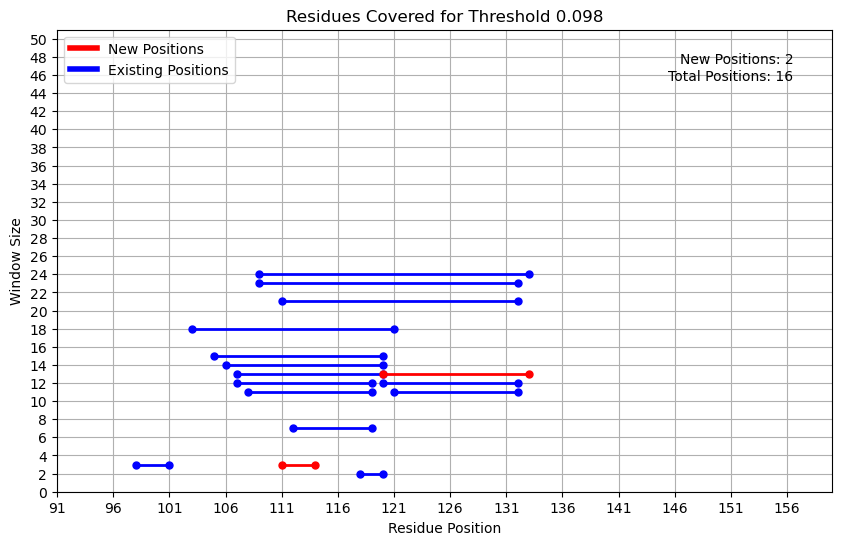

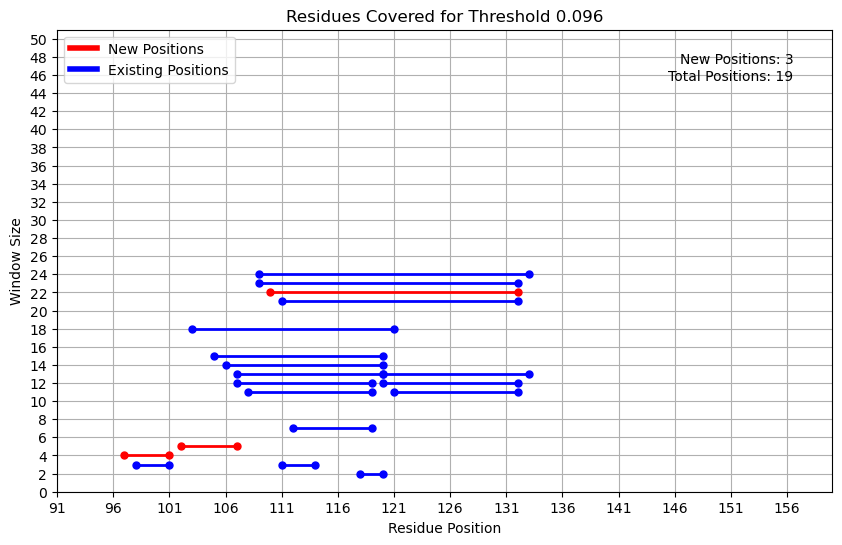

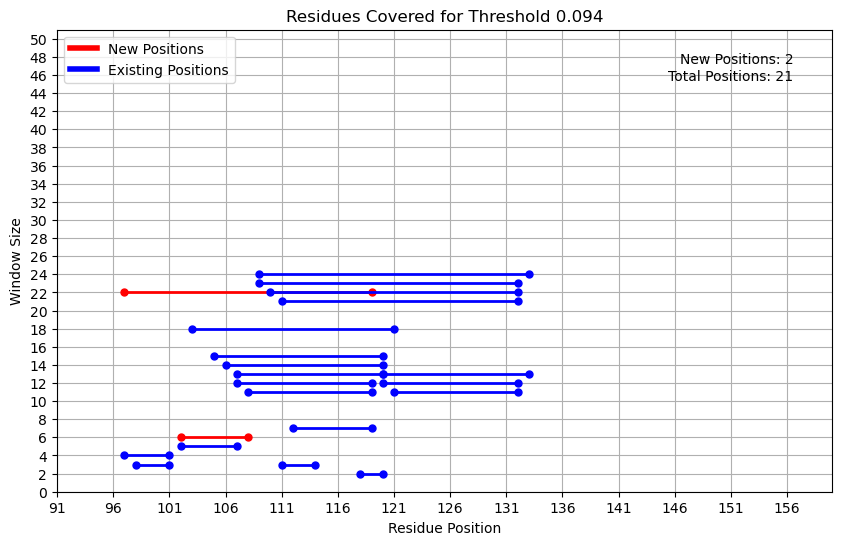

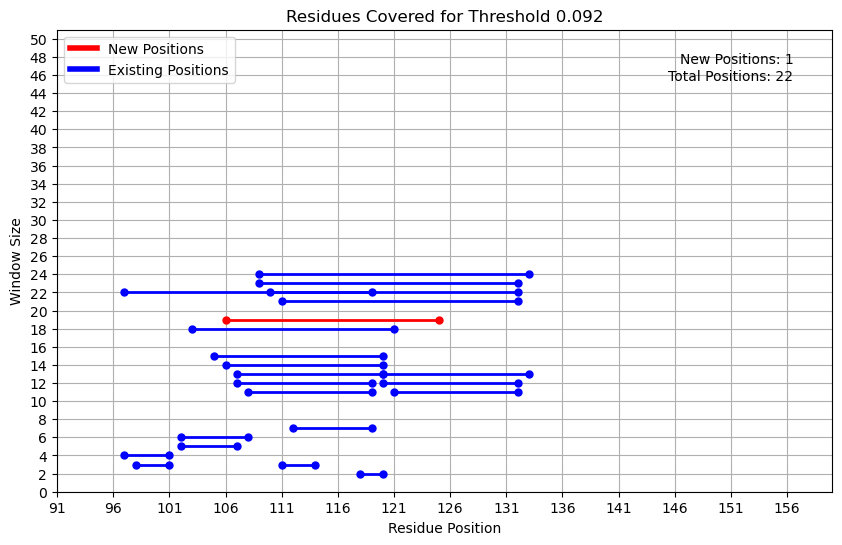

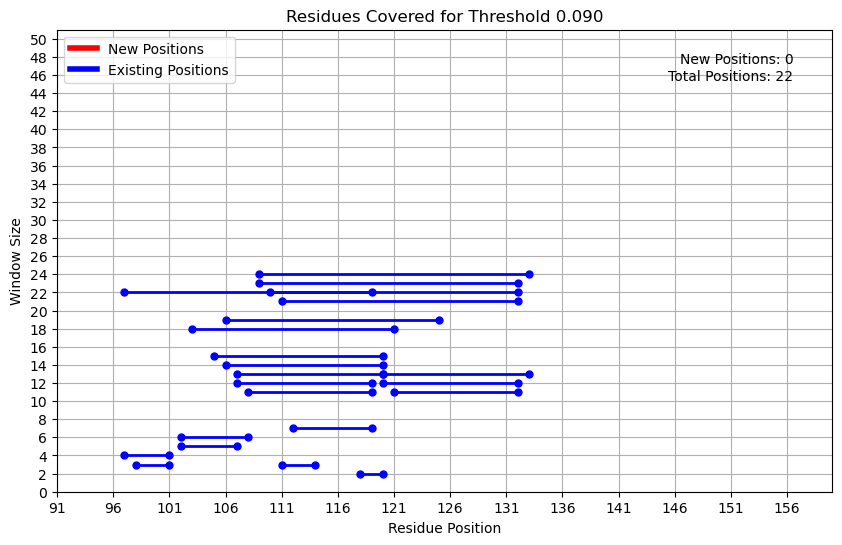

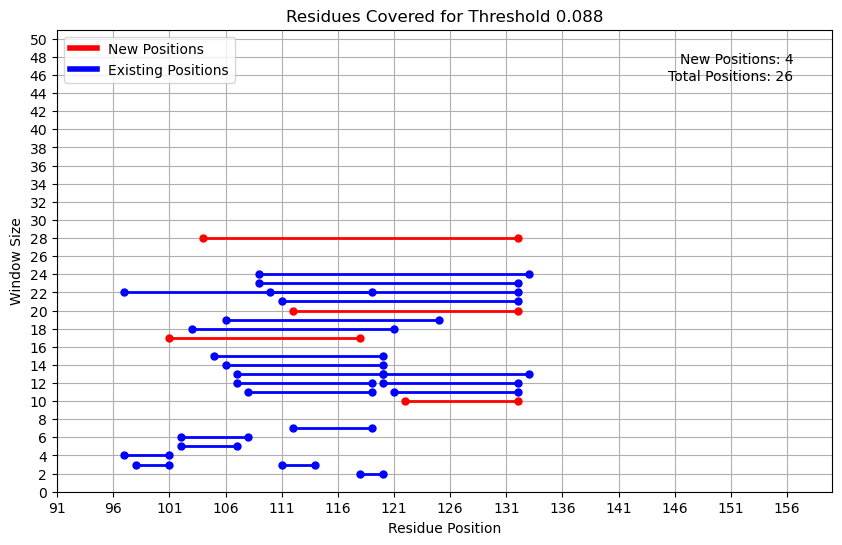

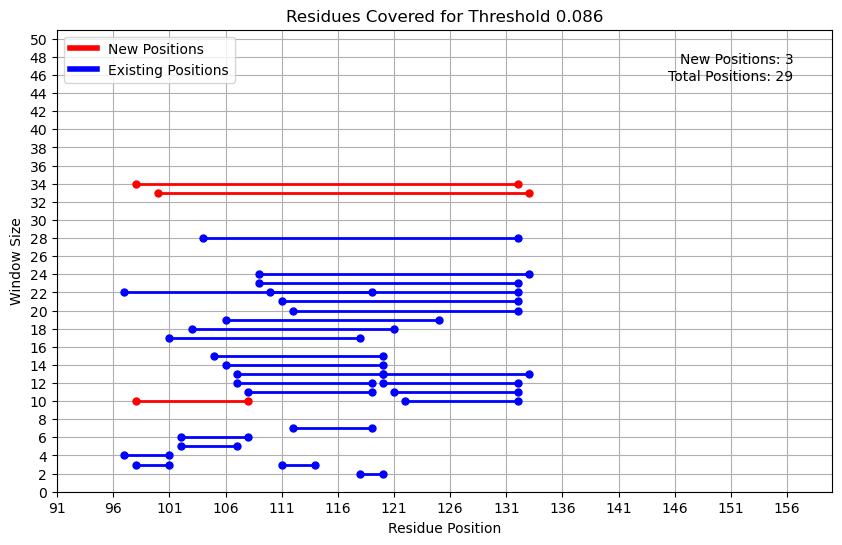

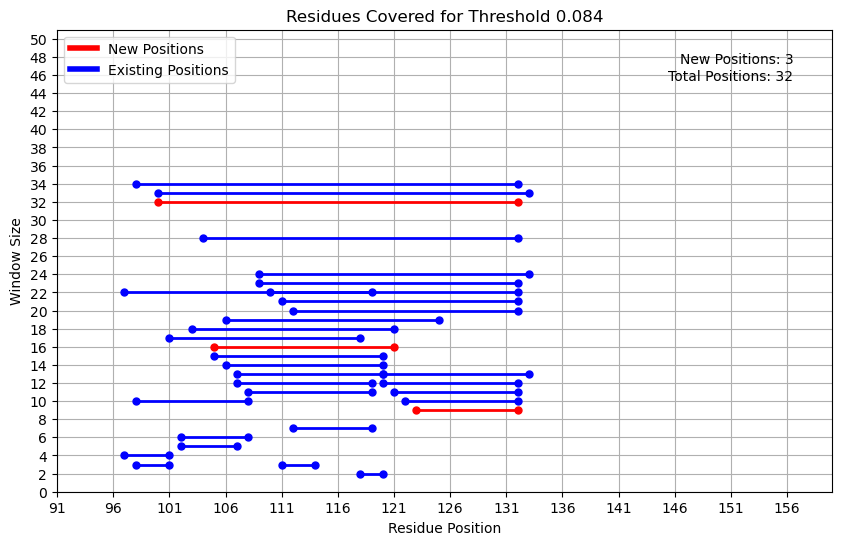

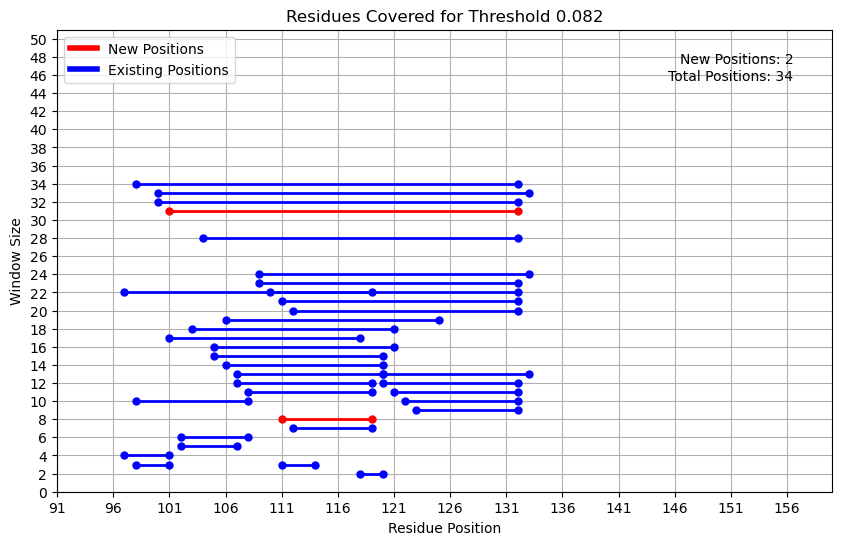

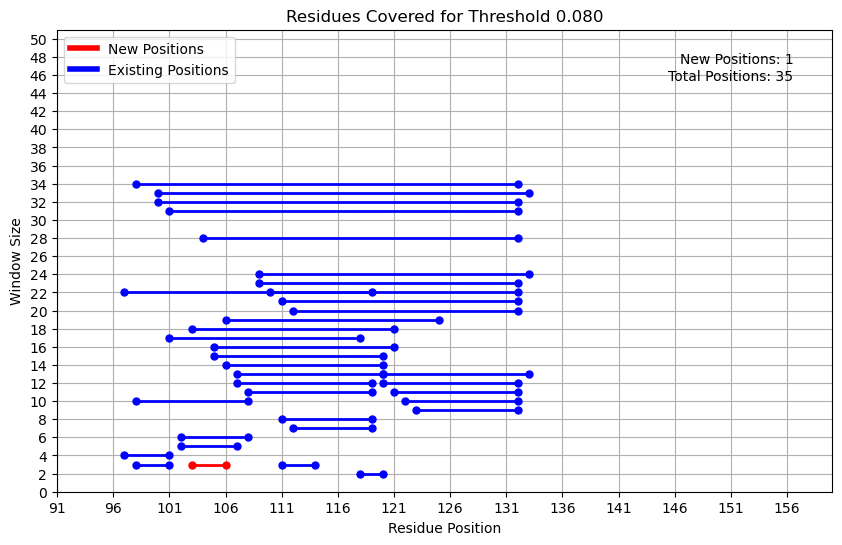

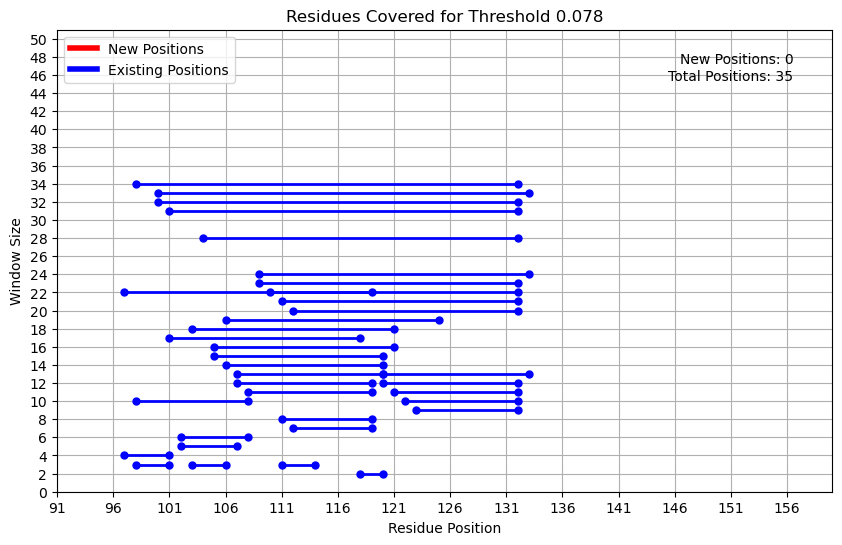

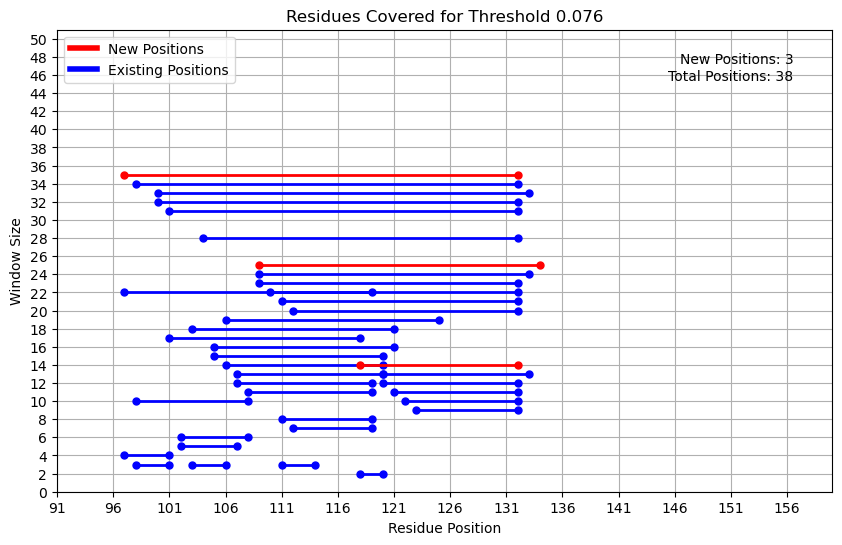

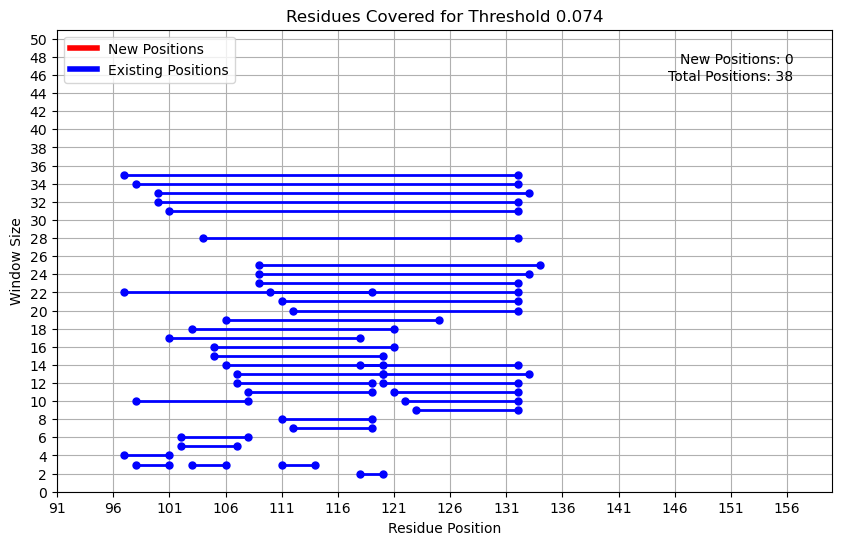

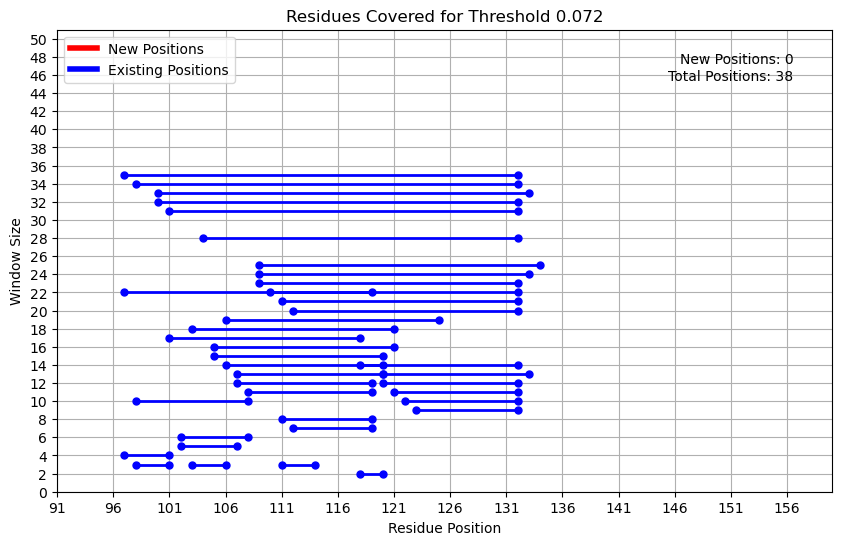

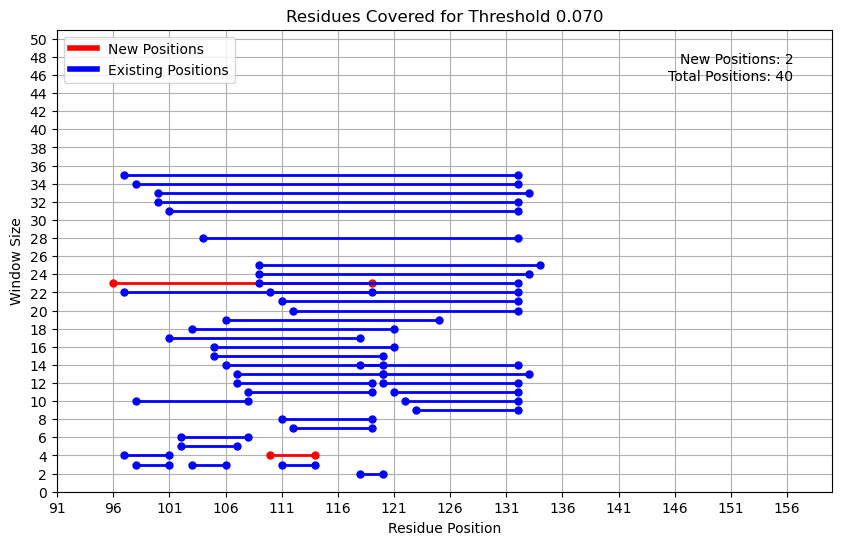

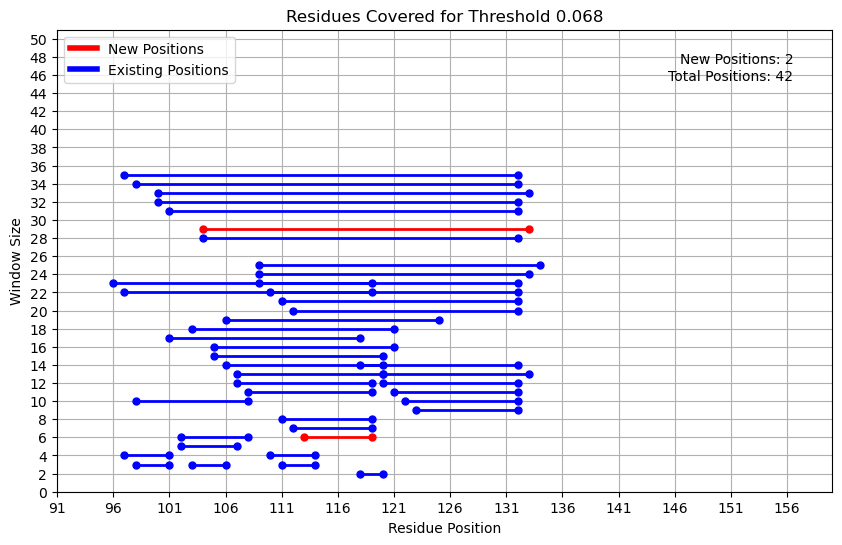

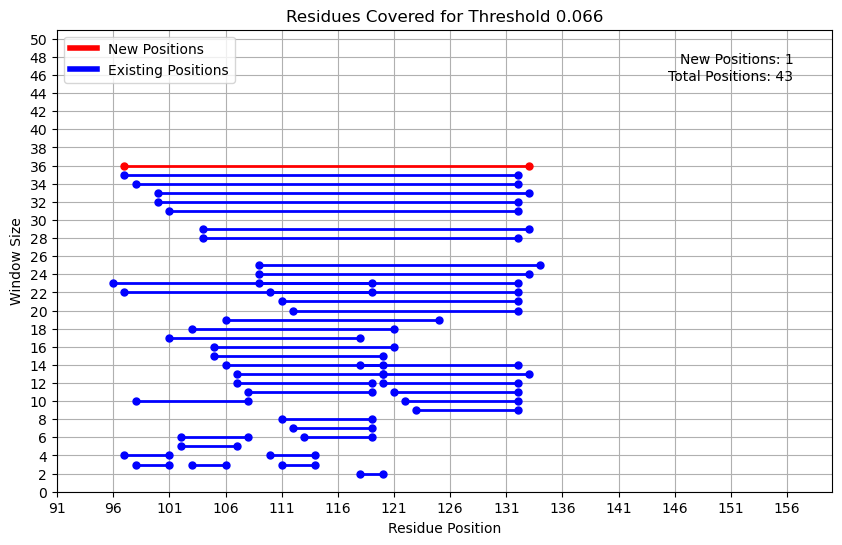

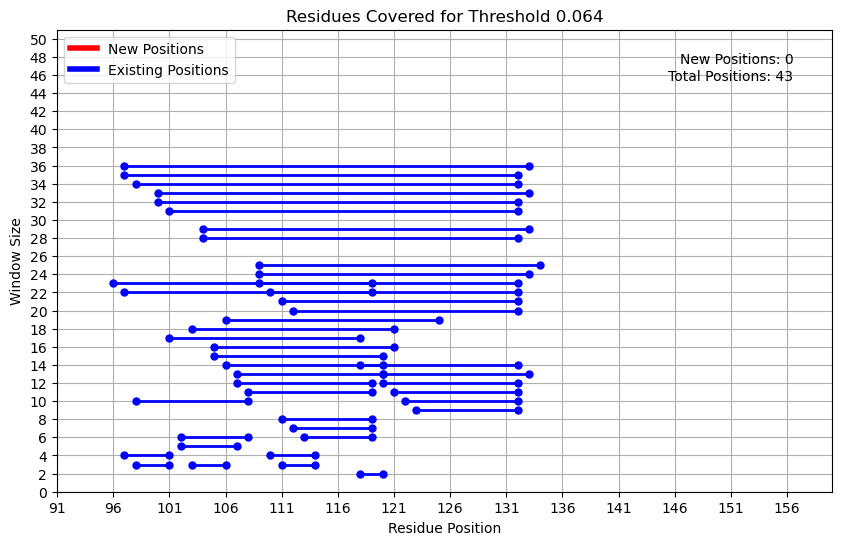

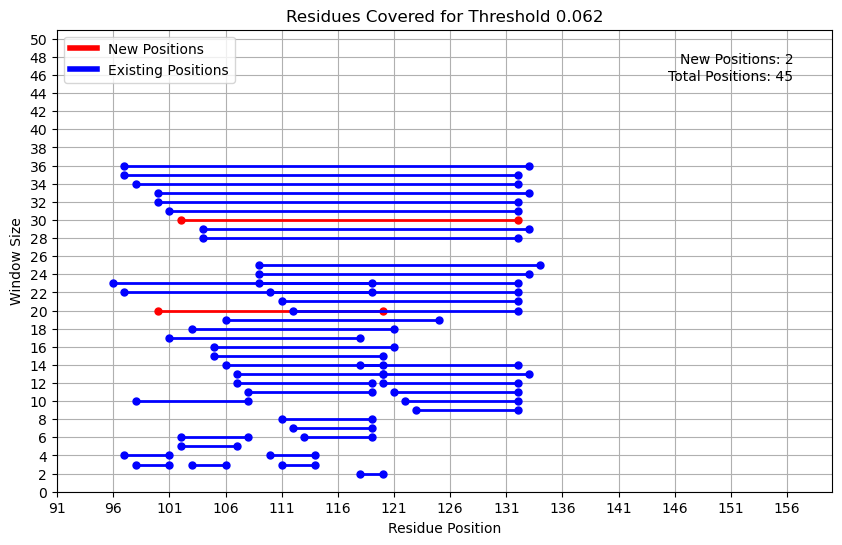

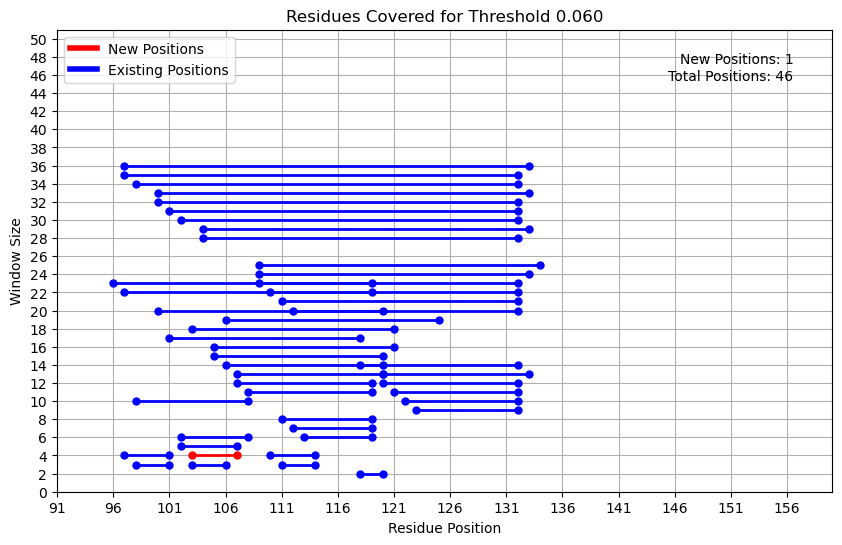

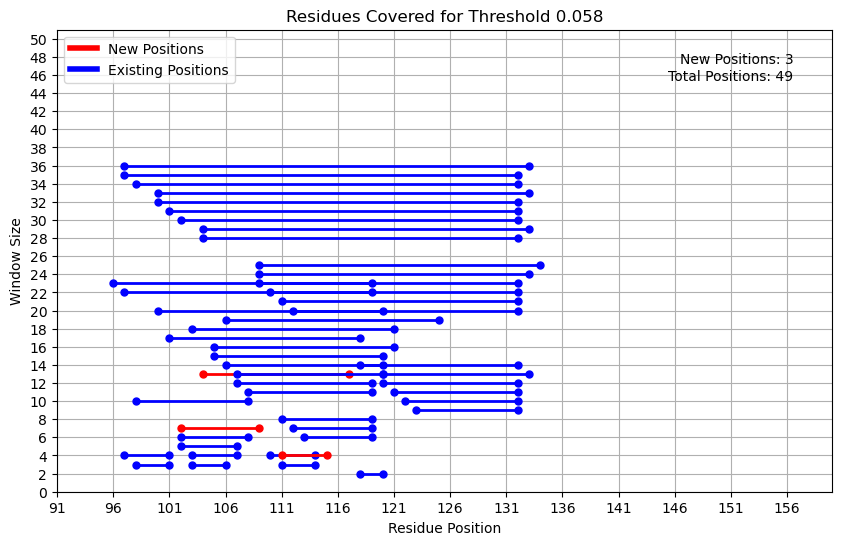

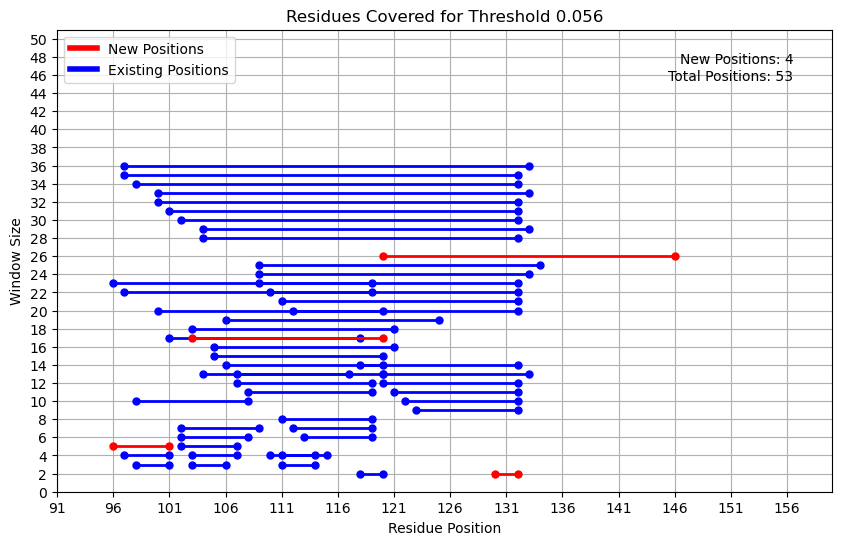

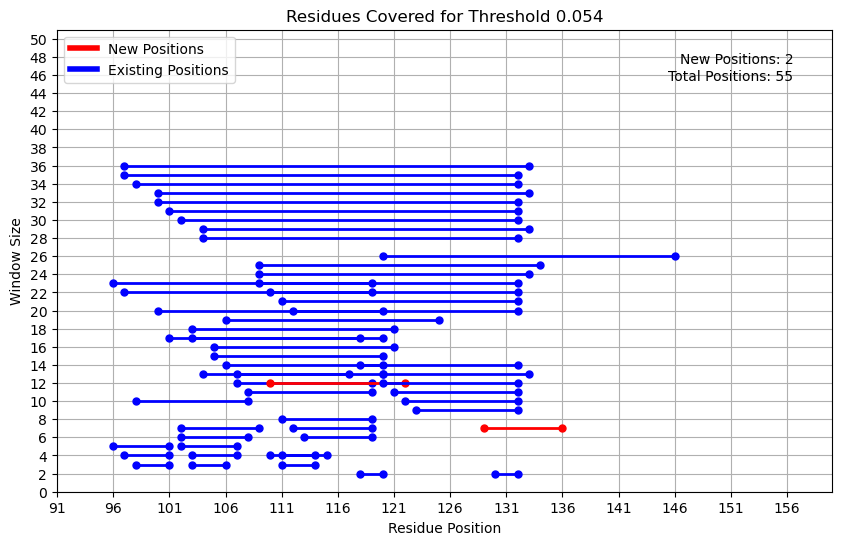

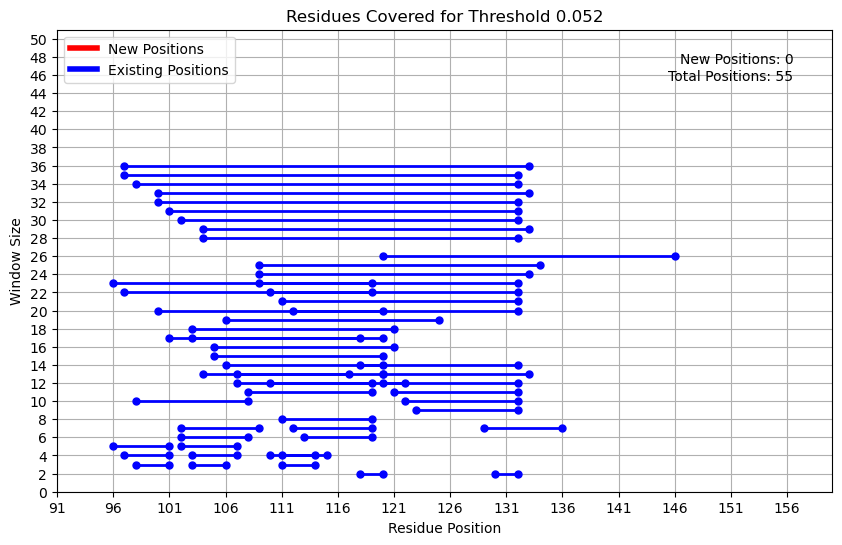

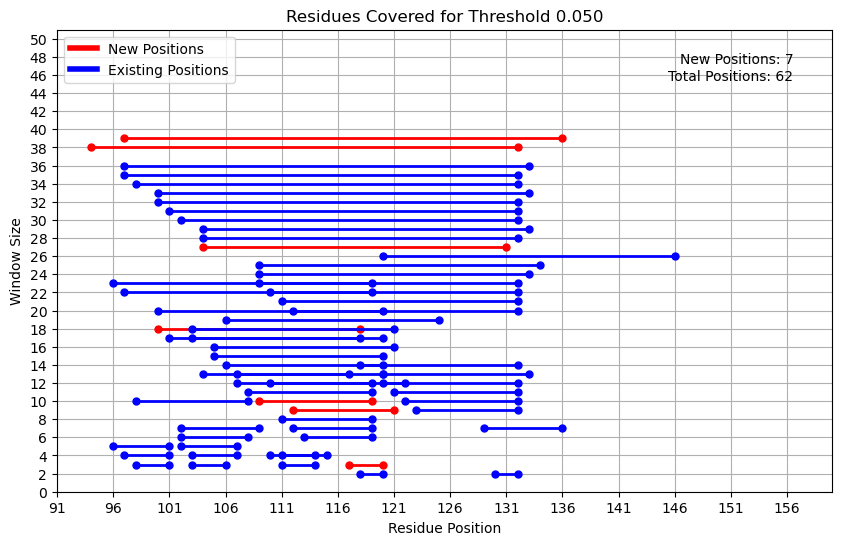

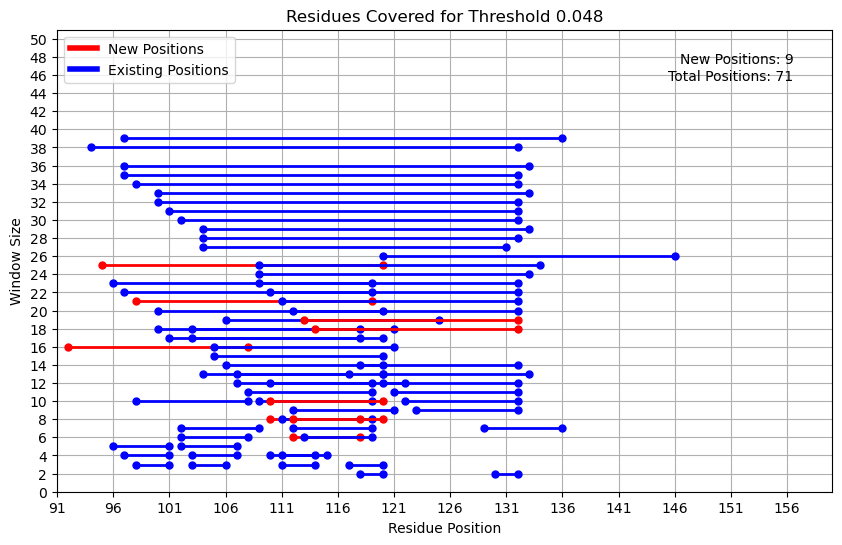

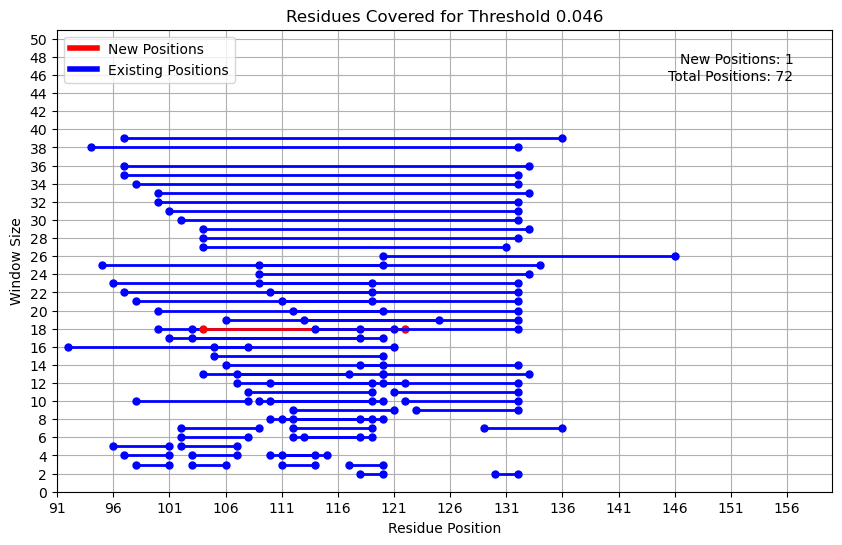

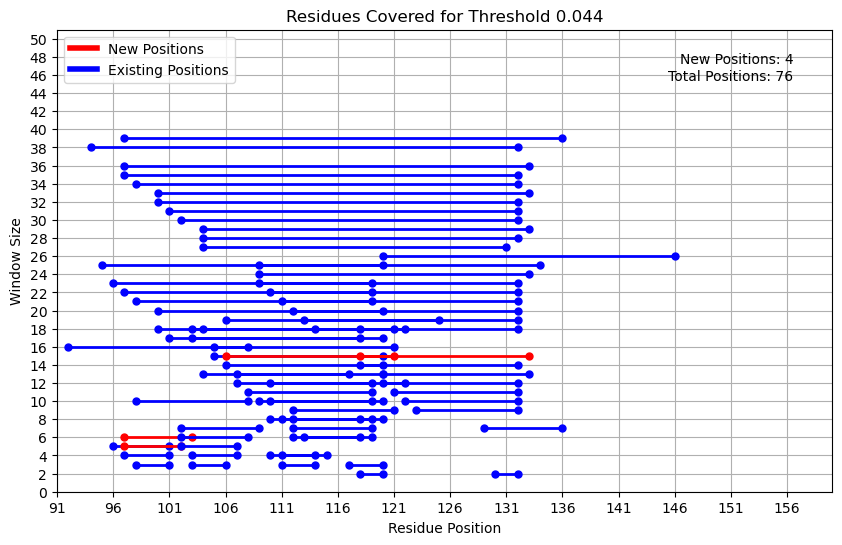

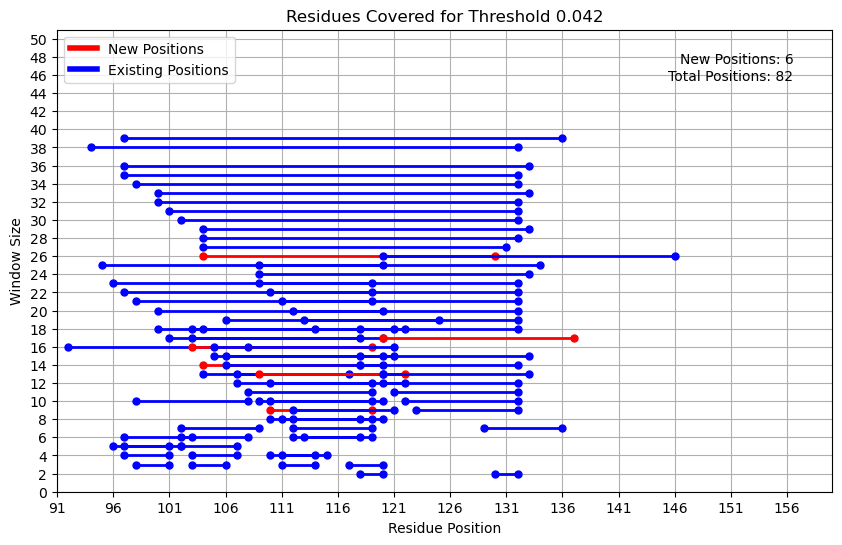

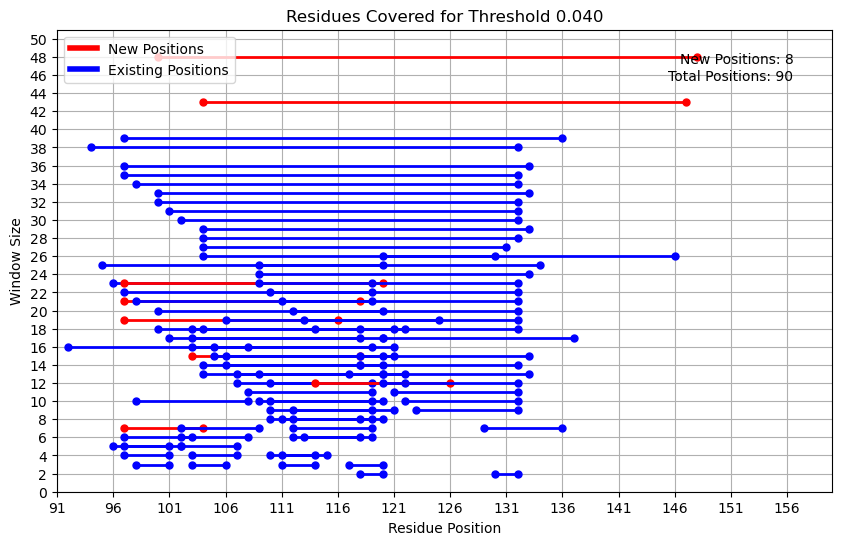

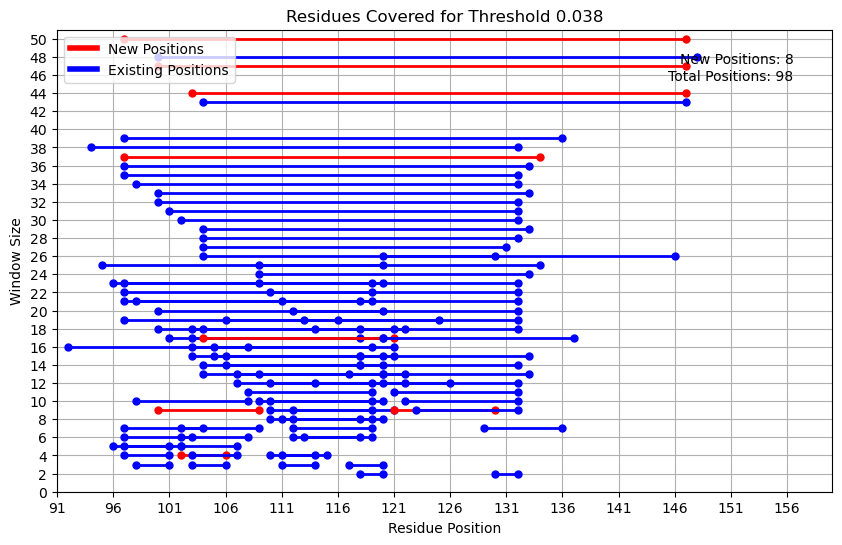

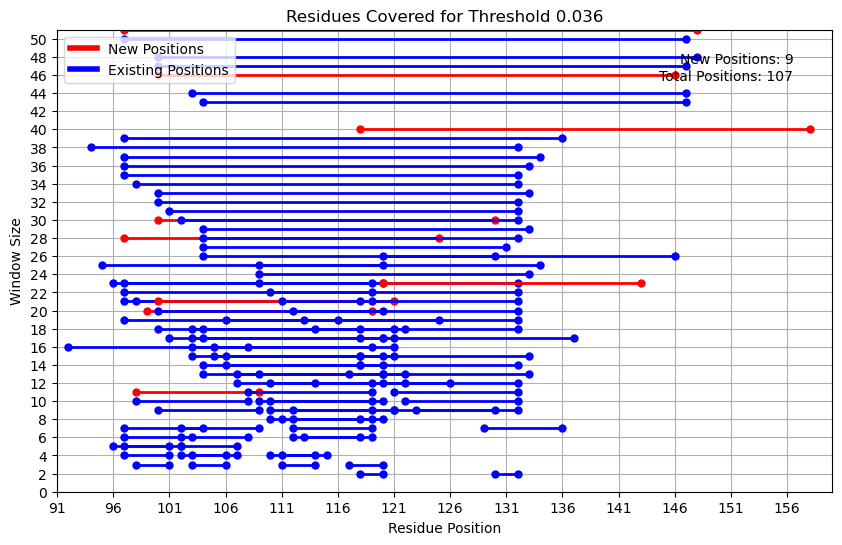

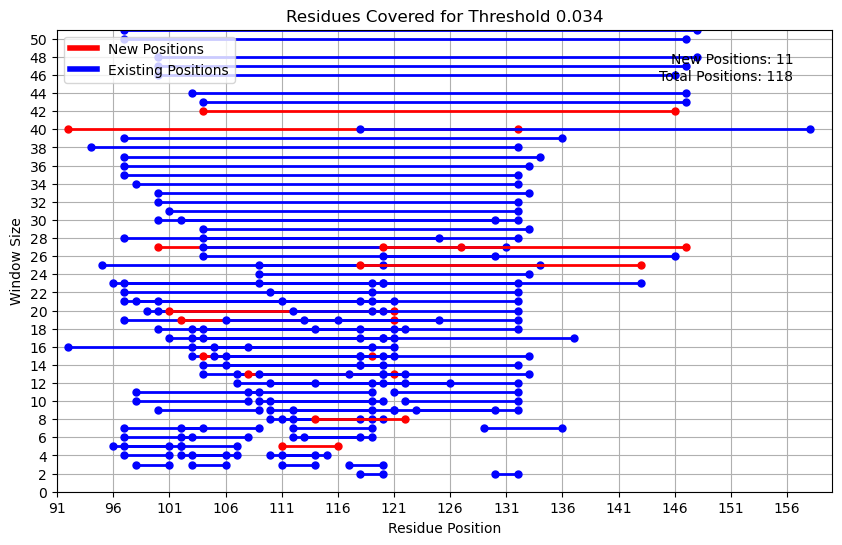

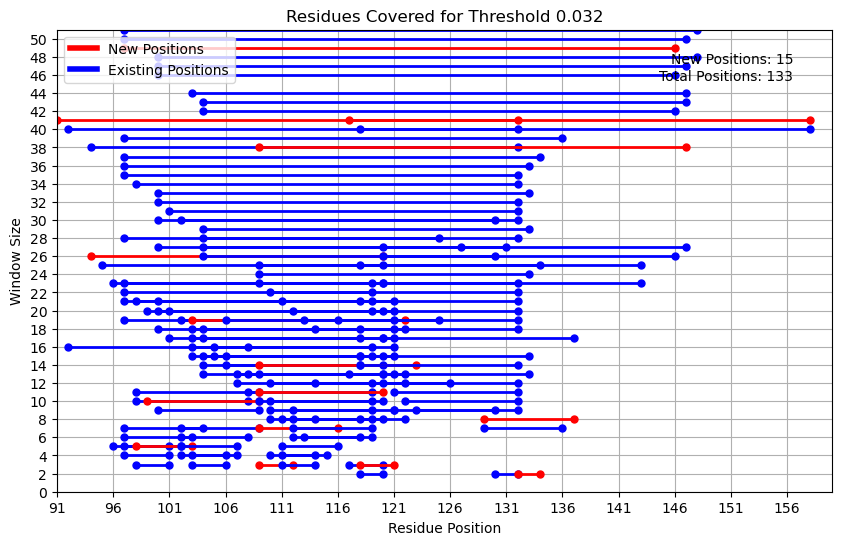

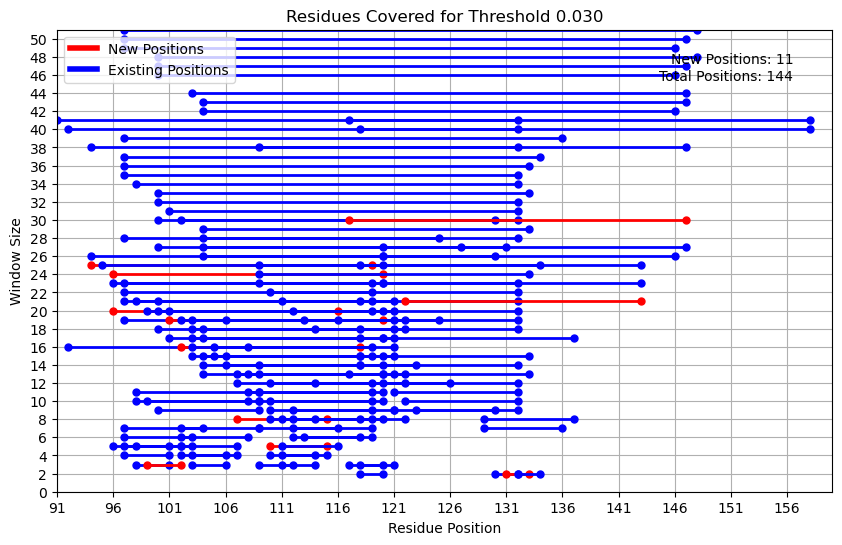

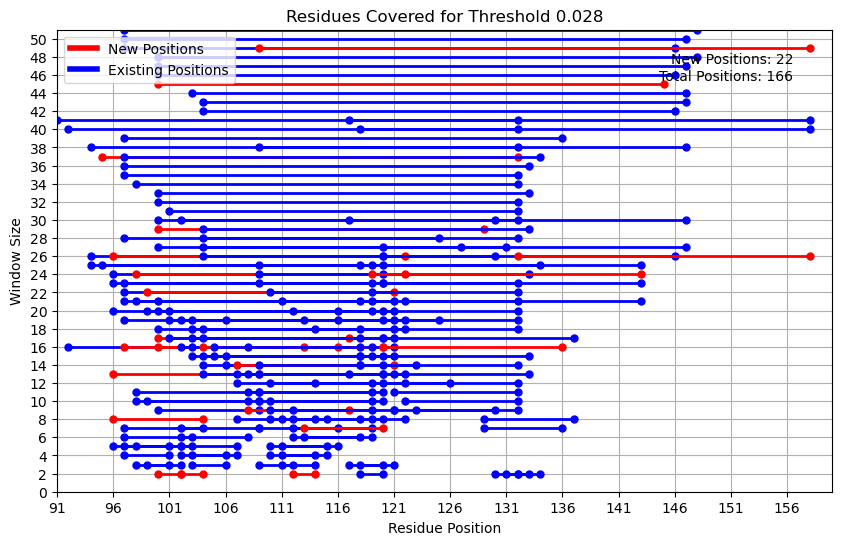

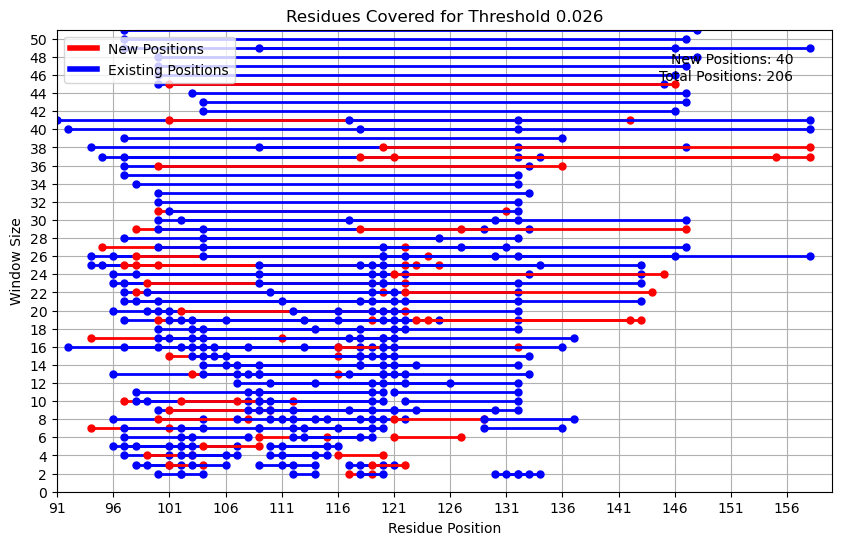

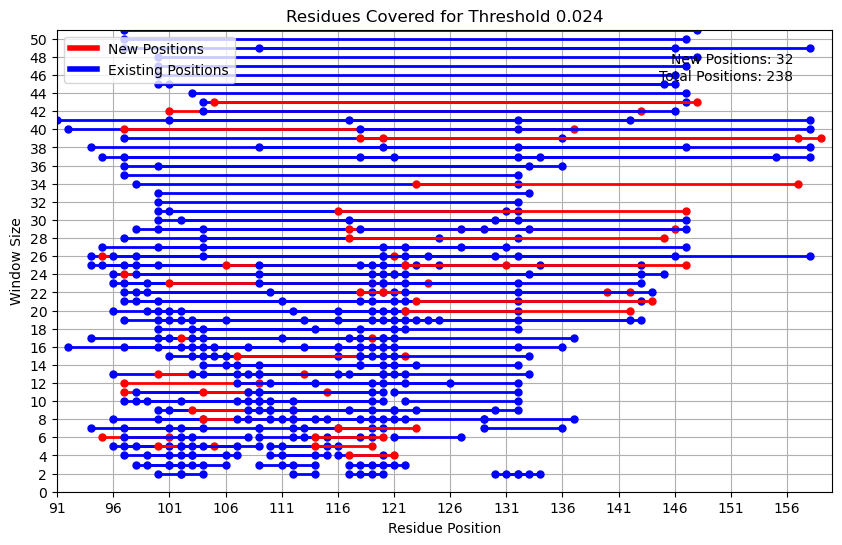

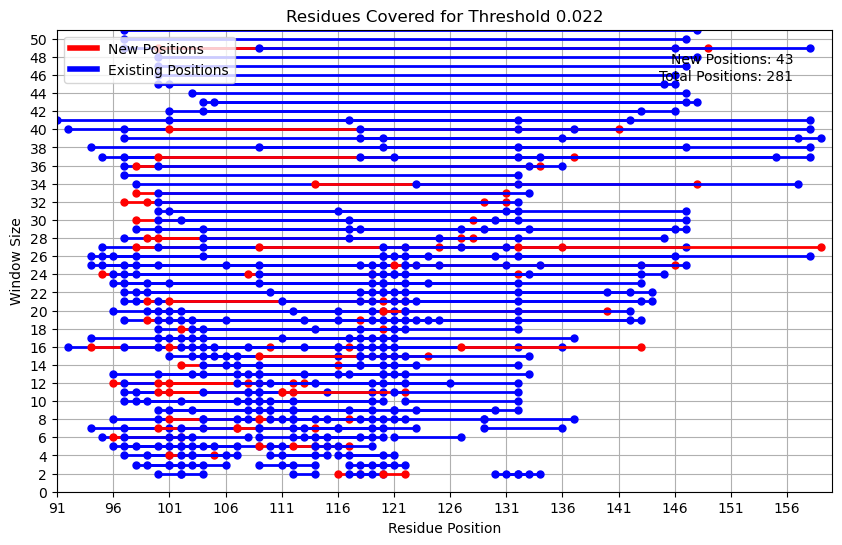

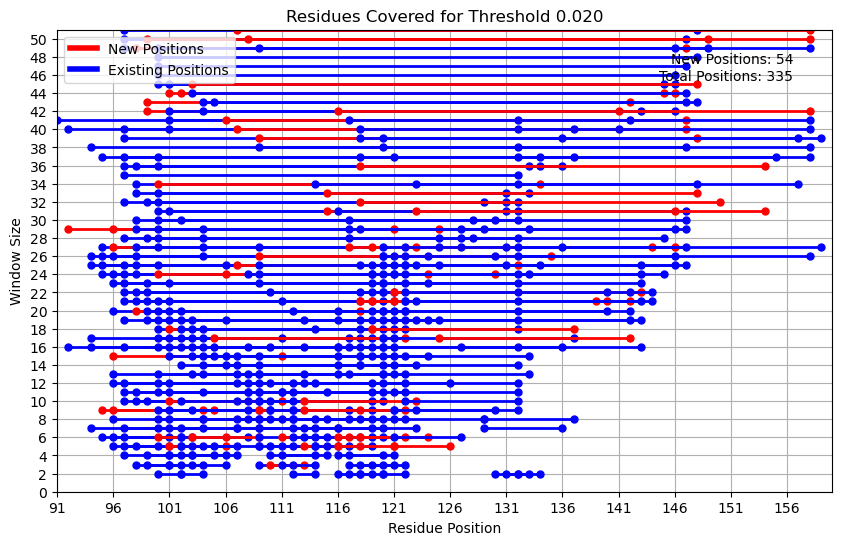

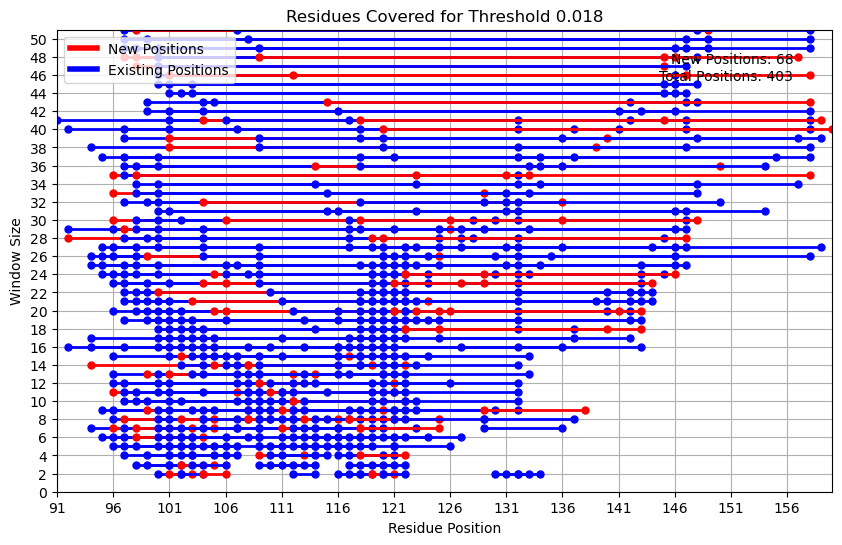

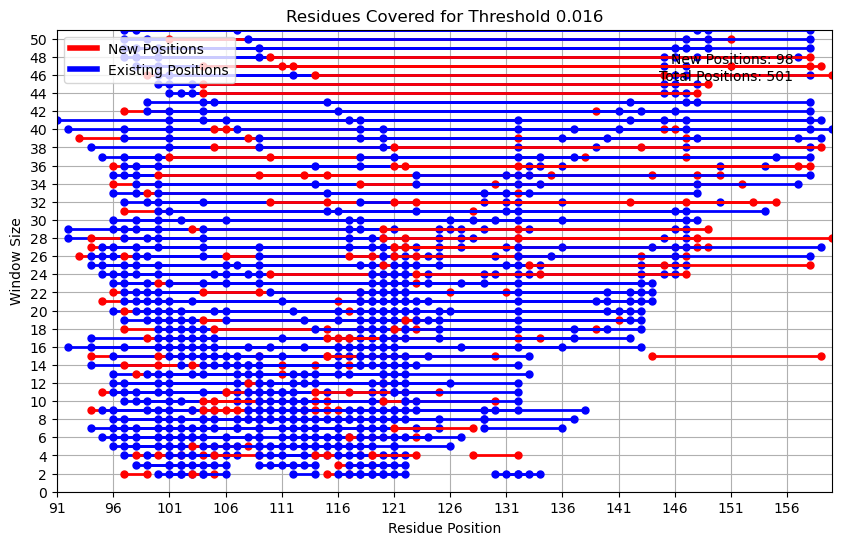

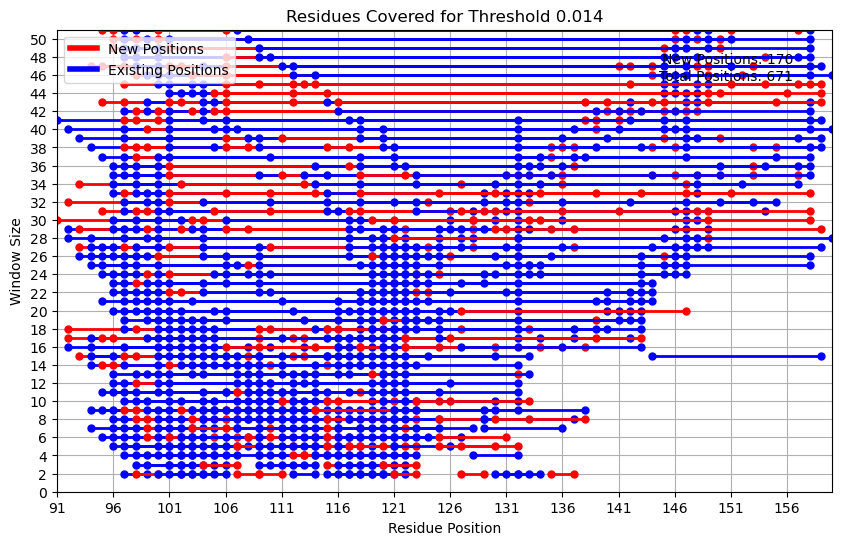

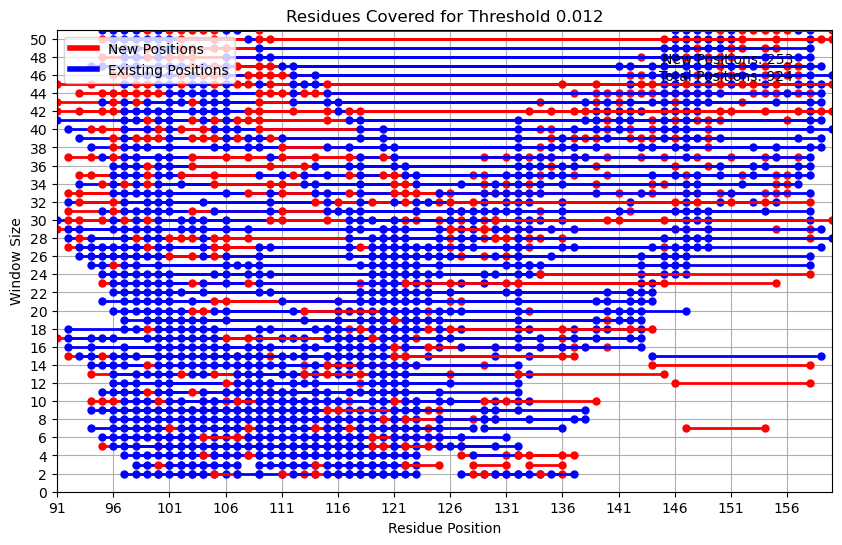

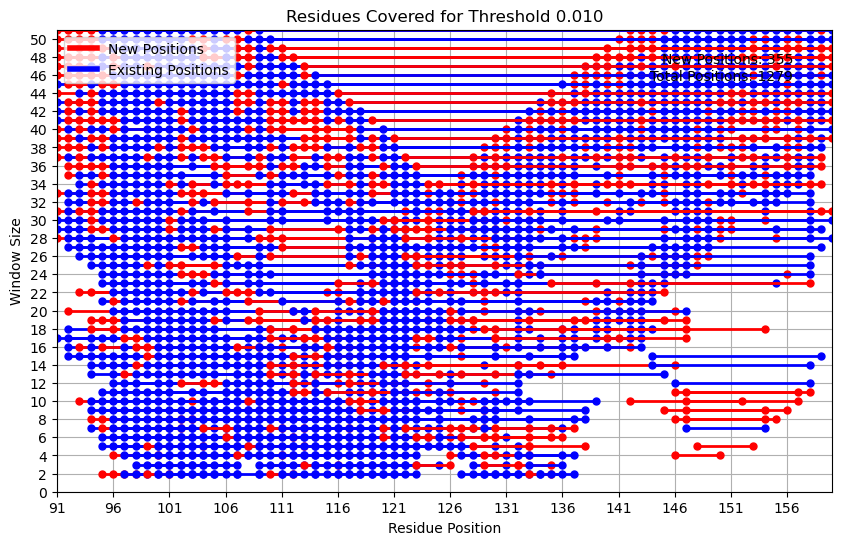

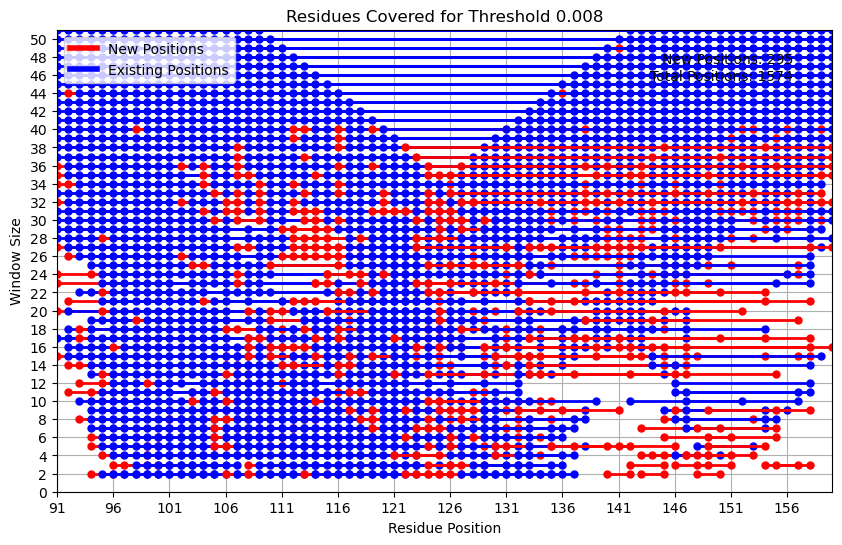

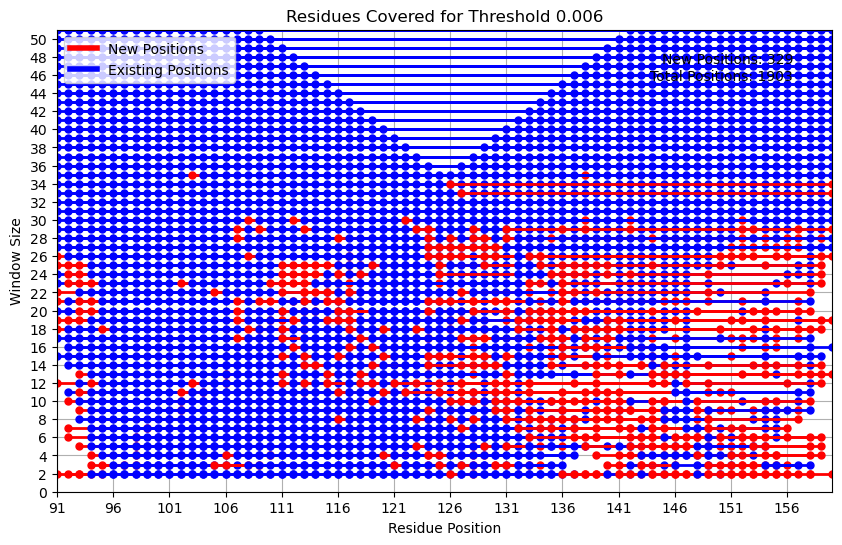

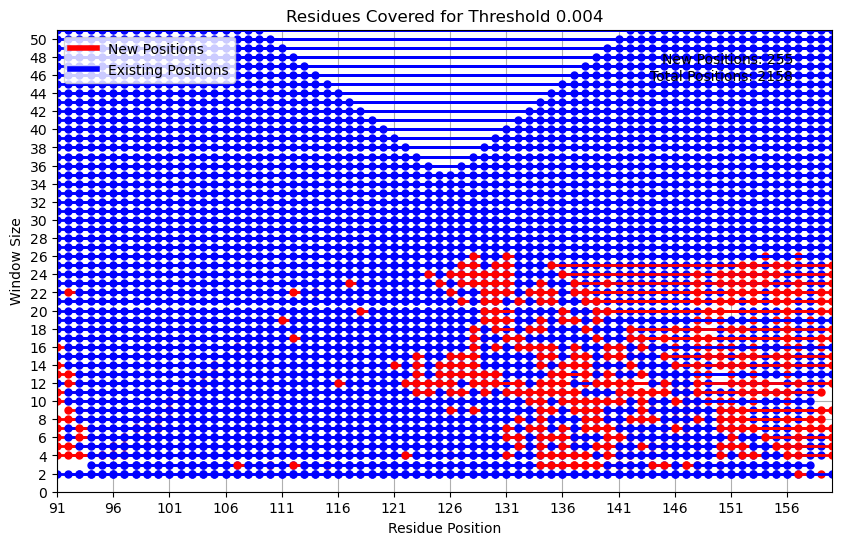

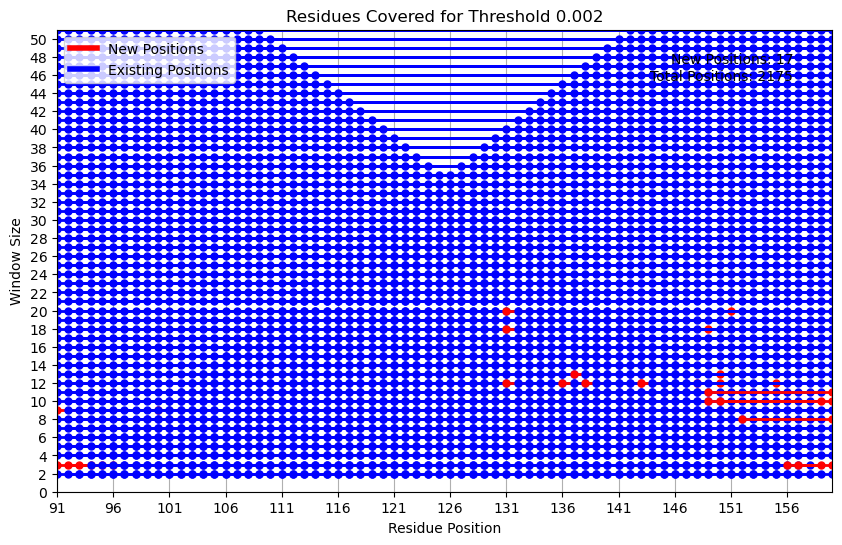

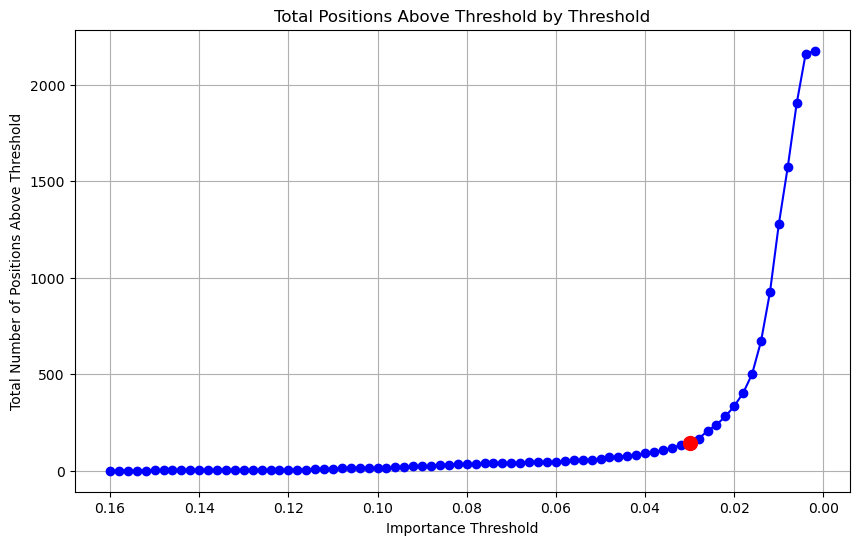

Filtered data already generated
Elbow Threshold: 0.030


In [11]:
# Calculate and plot positions for different importance_thresholds, and save positions above the elbow threshold
importance_thresholds = np.arange(0.16, 0.001, -0.002)
trainer.run_analysis(importance_thresholds)

## Data Import and Preparation

In [12]:
# Load and concatenate dataframes
wt_f = chase_ae_tune.load_and_concatenate('wt', 'wt')
D132H_f = chase_ae_tune.load_and_concatenate('D132H', 'D132H')

In [13]:
# Preprocessing
X_train_f, X_valid_f, y_train_f, y_valid_f = chase_ae_tune.preprocessing(wt_f, D132H_f)

# Tuning 

### Notes:
- Print Val loss graphs 
- Metrics for each trial graphed
- Stop trial if validation loss explodes
- Overlay top 5 trials loss/validation loss graphs

### Tuning Number of Nodes & Layers

In [14]:
# This takes approximately 13 hours to run
# Prepare Keras Tuner with Bayesian Optimization
tuner = BayesianOptimization(
    lambda hp: chase_ae_tune.build_autoencoder(hp, X_train_f.shape[1:]),
    objective='val_loss',
    max_trials=50,
    executions_per_trial=2,
    num_initial_points=10,
    directory='AE_Tuning',
    project_name='AET_Nodes_Layers'
)

# Start tuning
tuner.search(
    X_train_f, X_train_f,
    epochs=400,
    batch_size=256,
    validation_data=(X_valid_f, X_valid_f)
)

# Update Tracker
chase_ae_tune.update_best_overall(tuner, 'nodes_layers', additional_details={
    'num_layers': tuner.get_best_hyperparameters()[0].get('num_layers'),
    'nodes_per_layer': [tuner.get_best_hyperparameters()[0].get(f'nodes_{i}') for i in range(tuner.get_best_hyperparameters()[0].get('num_layers'))]
})

Reloading Tuner from AE_Tuning/AET_Nodes_Layers/tuner0.json


In [15]:
# Get the best model and print summary
best_model = tuner.get_best_models(num_models=1)[0]
best_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 145)]             0         
                                                                 
 dense (Dense)               (None, 288)               42048     
                                                                 
 dense_1 (Dense)             (None, 352)               101728    
                                                                 
 dense_2 (Dense)             (None, 2)                 706       
                                                                 
 dense_3 (Dense)             (None, 352)               1056      
                                                                 
 dense_4 (Dense)             (None, 288)               101664    
                                                                 
 dense_5 (Dense)             (None, 145)               41905 

2024-02-28 12:27:24.766499: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [16]:
# Fetch the full details of the top 5 trials
top_trials = tuner.oracle.get_best_trials(num_trials=5)

# Print the details of the top 5 trials
for i, trial in enumerate(top_trials):
    print(f"Rank: {i+1}")
    print("Hyperparameters:")
    for hp, value in trial.hyperparameters.values.items():
        print(f"{hp}: {value}")
    
    # Include the validation loss for each model
    val_loss = trial.score
    print(f"Validation Loss: {val_loss}\n")

Rank: 1
Hyperparameters:
num_layers: 2
nodes_0: 288
nodes_1: 352
nodes_2: 48
nodes_3: 320
nodes_4: 144
Validation Loss: 0.0009374839428346604

Rank: 2
Hyperparameters:
num_layers: 2
nodes_0: 272
nodes_1: 128
nodes_2: 144
nodes_3: 80
nodes_4: 48
Validation Loss: 0.0009514065750408918

Rank: 3
Hyperparameters:
num_layers: 2
nodes_0: 240
nodes_1: 128
nodes_2: 160
nodes_3: 304
nodes_4: 96
Validation Loss: 0.000953101844061166

Rank: 4
Hyperparameters:
num_layers: 2
nodes_0: 288
nodes_1: 112
nodes_2: 160
nodes_3: 272
nodes_4: 208
Validation Loss: 0.0009568639507051557

Rank: 5
Hyperparameters:
num_layers: 2
nodes_0: 352
nodes_1: 96
nodes_2: 160
nodes_3: 224
nodes_4: 336
Validation Loss: 0.00095793665968813



### Tuning Batch Size & Learning Rate

In [ ]:
# Retrieve best hyperparameters from initial tuning
best_hp = tuner.get_best_hyperparameters()[0]
best_num_layers = best_hp.get('num_layers')
best_nodes_per_layer = [best_hp.get(f'nodes_{i}') for i in range(best_num_layers)]

# Set up a new tuner instance for batch size and learning rate tuning
batch_size_tuner = BayesianOptimization(
    lambda hp: chase_ae_tune.build_autoencoder_for_tuning(hp, best_num_layers, best_nodes_per_layer, X_train_f.shape[1:]),
    objective='val_loss',
    max_trials=50,
    executions_per_trial=2,
    num_initial_points=10,
    directory='AE_Tuning',
    project_name='AET_LR_BS'
)

batch_size_tuner.search(
    X_train_f, X_train_f,
    validation_data=(X_valid_f, X_valid_f),
    epochs=400
)

# Update Tracker
chase_ae_tune.update_best_overall(batch_size_tuner, 'batch_size_lr', {
    'batch_size': batch_size_tuner.get_best_hyperparameters()[0].get('batch_size'),
    'learning_rate': batch_size_tuner.get_best_hyperparameters()[0].get('learning_rate')
})

### Tuning Activation Functions

In [ ]:
best_learning_rate = batch_size_tuner.get_best_hyperparameters()[0].get('learning_rate')

activation_tuner = BayesianOptimization(
    lambda hp: chase_ae_tune.build_autoencoder_for_activation_tuning(hp, best_num_layers, best_nodes_per_layer, best_learning_rate, X_train_f.shape[1:]),
    objective='val_loss',
    max_trials=20,  
    executions_per_trial=2,
    directory='AE_Tuning',
    project_name='AET_AF'
)

activation_tuner.search(
    X_train_f, X_train_f,  
    validation_data=(X_valid_f, X_valid_f),  
    epochs=400,  
    batch_size=batch_size_tuner.get_best_hyperparameters()[0].get('batch_size')
)

# Update Tracker
activation_functions = [activation_tuner.get_best_hyperparameters()[0].get(f'encoder_activation_{i}') for i in range(best_num_layers)]

chase_ae_tune.update_best_overall(activation_tuner, 'activation_functions', {
    'activations': activation_functions
})

### Tuning Loss Function and Optimizer

In [ ]:
best_activations = [activation_tuner.get_best_hyperparameters()[0].get(f'encoder_activation_{i}') for i in range(best_num_layers)]

final_tuner = BayesianOptimization(
    lambda hp: chase_ae_tune.build_autoencoder_for_final_tuning(hp, best_num_layers, best_nodes_per_layer, best_activations, best_learning_rate, X_train_f.shape[1:]),
    objective='val_loss',
    max_trials=100,
    executions_per_trial=3,
    directory='AE_Tuning',
    project_name='AET_LF_Opt'
)

final_tuner.search(
    X_train_f, X_train_f,
    validation_data=(X_valid_f, X_valid_f),
    epochs=200,
    batch_size=activation_tuner.get_best_hyperparameters()[0].get('batch_size')
)

# Update Tracker
chase_ae_tune.update_best_overall(final_tuner, 'loss_optimizer', {
    'loss_function': final_tuner.get_best_hyperparameters()[0].get('loss_function'),
    'optimizer': final_tuner.get_best_hyperparameters()[0].get('optimizer')
})

### Tuning Summary:

In [ ]:
# Print the best overall results
print(f"Best global validation loss: {chase_ae_tune.best_overall['val_loss']}")
print("Best Hyperparameters:")
for key, value in chase_ae_tune.best_overall['details'].get(chase_ae_tune.best_overall['step'], {}).items():
    print(f"{key}: {value}")